In [9]:
import numpy as np
import time
import argparse
import pickle
import torch
import torch.optim as optim
import torch.nn.functional as F
from scipy.sparse import coo_matrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())


gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

import sys
import logging
import numpy as np


def get_logger(filename):
    # Logging configuration: set the basic configuration of the logging system
    log_formatter = logging.Formatter(fmt='%(asctime)s [%(processName)s, %(process)s] [%(levelname)-5.5s]  %(message)s',
                                      datefmt='%m-%d %H:%M')
    logger = logging.getLogger()
    logger.setLevel(logging.DEBUG)
    # File logger
    file_handler = logging.FileHandler("{}.log".format(filename))
    file_handler.setFormatter(log_formatter)
    file_handler.setLevel(logging.DEBUG)
    logger.addHandler(file_handler)
    # Stderr logger
    std_handler = logging.StreamHandler(sys.stdout)
    std_handler.setFormatter(log_formatter)
    std_handler.setLevel(logging.DEBUG)
    logger.addHandler(std_handler)
    return logger


def data_loader(inputs, targets, batch_size, shuffle=True):
    assert inputs.shape[0] == targets.shape[0]
    inputs_size = inputs.shape[0]
    if shuffle:
        random_order = np.arange(inputs_size)
        np.random.shuffle(random_order)
        inputs, targets = inputs[random_order, :], targets[random_order]
    num_blocks = int(inputs_size / batch_size)
    for i in range(num_blocks):
        yield inputs[i * batch_size: (i+1) * batch_size, :], targets[i * batch_size: (i+1) * batch_size]
    if num_blocks * batch_size != inputs_size:
        yield inputs[num_blocks * batch_size:, :], targets[num_blocks * batch_size:]


def multi_data_loader(inputs, targets, batch_size, shuffle=True):
    """
    Both inputs and targets are list of numpy arrays, containing instances and labels from multiple sources.
    """
    assert len(inputs) == len(targets)
    input_sizes = [data.shape[0] for data in inputs]
    max_input_size = max(input_sizes)
    num_domains = len(inputs)
    if shuffle:
        for i in range(num_domains):
            r_order = np.arange(input_sizes[i])
            np.random.shuffle(r_order)
            inputs[i], targets[i] = inputs[i][r_order, :], targets[i][r_order]
    num_blocks = int(max_input_size / batch_size)
    for j in range(num_blocks):
        xs, ys = [], []
        for i in range(num_domains):
            ridx = np.random.choice(input_sizes[i], batch_size)
            xs.append(inputs[i][ridx, :])
            ys.append(targets[i][ridx])
        yield xs, ys

True
Mon Aug 15 10:47:19 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.15       Driver Version: 512.15       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 33%   57C    P2    54W / 180W |   3811MiB /  8192MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+--

In [10]:
from sklearn.metrics import  zero_one_loss,mean_absolute_error,r2_score, mean_squared_error
from math import sqrt
def get_mae(target, prediction):
    assert (target.shape == prediction.shape)

    return mean_absolute_error(target, prediction)

def get_mse(target, prediction):
    assert (target.shape == prediction.shape)

    return mean_squared_error(target, prediction)

def get_sae(target, prediction):
    assert (target.shape == prediction.shape)

    r = target.sum()
    r0 = prediction.sum()
    sae = abs(r0 - r) / r
    return sae

def get_nde(target, prediction):
    assert (target.shape == prediction.shape)

    error, squarey = [], []
    for i in range(len(prediction)):
        value = prediction[i] - target[i]
        error.append(value * value)
        squarey.append(target[i] * target[i])
    nde = sqrt(sum(error) / sum(squarey))
    return nde


In [11]:
#####################################################Regression#######################################
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
def dataProvider(file,windowsize,stepsize,threshold):  
    dataframe=pd.read_csv(file,header=0)    
    np_array=np.array(dataframe)
    inputs, targets=np_array[:, 0], np_array[:, 1]
    offset = int(0.5 * (windowsize - 1.0))
#     window_num=inputs.size - 2 * offset
    features=list()
    labels=list()
    i=0
    while (i<=inputs.size-windowsize):
        data_in=inputs[i:i+windowsize]
        tar=targets[i+offset]
        features.append(data_in)
        labels.append(tar)
        i=i+stepsize
    X=np.array(features)
    Y=np.array(labels)
    Y[Y<=threshold] = 0
    # scaler = MinMaxScaler()
    # X=scaler.fit_transform(X)
    x_train_all, X, y_train_all, Y = train_test_split(X, Y, test_size=0.2,random_state=100)
    return X,Y

In [12]:
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable

def EntropyLoss(input_):
    mask = input_.ge(0.000001)
    mask_out = torch.masked_select(input_, mask)
    entropy = -(torch.sum(mask_out * torch.log(mask_out)))
    return entropy / float(input_.size(0))

def guassian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(source.size()[0])+int(target.size()[0])
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    L2_distance = ((total0-total1)**2).sum(2)
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)#/len(kernel_val)

    
def JAN(source_list, target_list, kernel_muls=[2.0, 2.0], kernel_nums=[1, 1], fix_sigma_list=[None, 1.68]):
    batch_size = int(source_list[0].size()[0])
    layer_num = len(source_list)
    joint_kernels = None
    for i in range(layer_num):
        source = source_list[i]
        target = target_list[i]
        kernel_mul = kernel_muls[i]
        kernel_num = kernel_nums[i]
        fix_sigma = fix_sigma_list[i]
        kernels = guassian_kernel(source, target,
            kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
        if i==0:
            joint_kernels=torch.ones_like(kernels)
        if joint_kernels is not None:
            joint_kernels = joint_kernels * kernels
        else:
            joint_kernels = kernels

    loss1 = 0
    for s1 in range(batch_size):
        for s2 in range(s1 + 1, batch_size):
            t1, t2 = s1 + batch_size, s2 + batch_size
            loss1 += joint_kernels[s1, s2] + joint_kernels[t1, t2]
    loss1 = loss1 / float(batch_size * (batch_size - 1) / 2)

    loss2 = 0
    for s1 in range(batch_size):
        for s2 in range(batch_size):
            t1, t2 = s1 + batch_size, s2 + batch_size
            loss2 -= joint_kernels[s1, t2] + joint_kernels[s2, t1]
    loss2 = loss2 / float(batch_size * batch_size)
    return loss1 + loss2

def JAN_Linear(source_list, target_list, kernel_muls=[2.0, 2.0], kernel_nums=[2, 1], fix_sigma_list=[None, 1.68]):
    batch_size = int(source_list[0].size()[0])
    layer_num = len(source_list)
    joint_kernels = None
    for i in range(layer_num):
        source = source_list[i]
        target = target_list[i]
        kernel_mul = kernel_muls[i]
        kernel_num = kernel_nums[i]
        fix_sigma = fix_sigma_list[i]
        kernels = guassian_kernel(source, target,
            kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
        if i==0:
            joint_kernels=torch.ones_like(kernels)
        if joint_kernels is not None:
            joint_kernels = joint_kernels * kernels
        else:
            joint_kernels = kernels

    # Linear version
    loss = 0
    for i in range(batch_size):
        s1, s2 = i, (i+1)%batch_size
        t1, t2 = s1+batch_size, s2+batch_size
        loss += joint_kernels[s1, s2] + joint_kernels[t1, t2]
        loss -= joint_kernels[s1, t2] + joint_kernels[s2, t1]
    return loss / float(batch_size)


# loss_dict = {"DAN":DAN, "DAN_Linear":DAN_Linear, "RTN":RTN, "JAN":JAN, "JAN_Linear":JAN_Linear}

# -*- coding: utf-8 -*-
"""
Created on Tue Sep  8 10:56:20 2020

@author: MXM
"""

import torch

def kernel(X, X2, gamma=0.4):
    '''
    Input: X  Size1*n_feature
           X2 Size2*n_feature
    Output: Size1*Size2
    '''
    X = torch.transpose(X,1,0)
    X2 = torch.transpose(X2,1,0)
    n1, n2 = X.shape[1],X2.shape[1]
    n1sq = torch.sum(X ** 2, 0)
    n1sq = n1sq.float().to(device)
    n2sq = torch.sum(X2 ** 2, 0)
    n2sq = n2sq.float().to(device)
    D = torch.ones((n1, n2)).to(device) * n2sq + torch.transpose((torch.ones((n2, n1)).to(device) * n1sq),1,0)+  - 2 * torch.mm(torch.transpose(X,1,0), X2)
    K = torch.exp(-gamma * D)
    return K

def MLcon_kernel(X_p , Y_p , X_q , Y_q , lamda = 1):
    '''
    dim(X_p_list) = dim(X_q_list) = layer_num*Size*n_feature
    here we set layer_num = 1
    '''
    layer_num = 1
    out = 0
    np = X_p.shape[0]
    nq = X_q.shape[0]
    I1 =torch.eye(np).to(device)
    I2 =torch.eye(nq).to(device)
    Kxpxp = kernel(X_p , X_p)
    Kxqxq = kernel(X_q , X_q)
    Kxqxp = kernel(X_q , X_p)
    Kypyq = kernel(Y_p , Y_q)
    Kyqyq = kernel(Y_q , Y_q)
    Kypyp = kernel(Y_p , Y_p)
    a = torch.mm((torch.inverse(Kxpxp+np*lamda*I1)),Kypyp)
    b = torch.mm(a,(torch.inverse(Kxpxp+np*lamda*I1)))
    c = torch.mm(b,Kxpxp)
    out1 = torch.trace(c)
        
    a1 = torch.mm((torch.inverse(Kxqxq+nq*lamda*I2)),Kyqyq)
    b1 = torch.mm(a1,(torch.inverse(Kxqxq+nq*lamda*I2)))
    c1 = torch.mm(b1,Kxqxq)
    out2 = torch.trace(c1)
        
    a2 = torch.mm((torch.inverse(Kxpxp+np*lamda*I1)),Kypyq)
    b2 = torch.mm(a2,(torch.inverse(Kxqxq+nq*lamda*I2)))
    c2 = torch.mm(b2,Kxqxp)
    out3 = torch.trace(c2)       
    out += (out1 + out2 - 2*out3)        
    return out

In [13]:
import numpy as np 
import pandas as pd 
import torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import math



class GradientReversalLayer(torch.autograd.Function):
    """
    Implement the gradient reversal layer for the convenience of domain adaptation neural network.
    The forward part is the identity function while the backward part is the negative function.
    """
    # @staticmethod
    @staticmethod
    def forward(ctx, inputs):
        ctx.save_for_backward(inputs)
        return inputs
    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.clone()
        grad_input = -grad_input
        return grad_input


mse = torch.nn.MSELoss()


# def weighted_mse(outputs, target, alpha):
#     """
#     Spectral Norm Loss between one source and one target: ||output^T*output-target^T*target||_2
#     Inputs:
#         - output: torch.Tensor, source distribution
#         - target: torch.Tensor, target distribution
#     Output:
#         - loss: float, value of the spectral norm of the difference of covariance matrix
        
#     """
#     loss = torch.sum(torch.stack([alpha[i]*torch.sqrt(mse(outputs[i], target[i])) for i in range(len(outputs))]))
#     return loss

    
def weighted_mse(outputs, target, alpha):
    """
    Spectral Norm Loss between one source and one target: ||output^T*output-target^T*target||_2
    Inputs:
        - output: torch.Tensor, source distribution
        - target: torch.Tensor, target distribution
    Output:
        - loss: float, value of the spectral norm of the difference of covariance matrix
        
    """
    loss = torch.sum(torch.stack([alpha[i]*mse(outputs[i], target[i]) for i in range(len(outputs))]))
    return loss

def weighted_jmmd(source, target, alpha):
    loss = torch.sum(torch.stack([alpha[i]*JAN_Linear(source[i], target) for i in range(len(source))]))
    return loss

def weighted_ceod(sourceList_x, sourceList_y, target_x, target_y, alpha):
    loss = torch.sum(torch.stack([alpha[i]*MLcon_kernel(sourceList_x[i], sourceList_y[i], target_x, target_y) for i in range(len(sourceList_x))]))
    return loss

# def weighted_disc(y_spred, y_sdisc, y_tpred, y_tdisc, alpha):
#     loss = torch.sum(torch.stack([alpha[i]*torch.abs(torch.sqrt(mse(y_spred[i], y_sdisc[i]))-torch.sqrt(mse(y_tpred, y_tdisc[i]))) for i in range(len(y_spred))]))
#     return loss

def weighted_disc(y_spred, y_sdisc, y_tpred, y_tdisc, alpha):
    loss = torch.sum(torch.stack([alpha[i]*torch.abs(mse(y_spred[i], y_sdisc[i])-mse(y_tpred, y_tdisc[i])) for i in range(len(y_spred))]))
    return loss

# def weighted_disc(y_spred, y_sdisc, y_tpred, y_tdisc, alpha):
#     loss = torch.sum(torch.stack([alpha[i]*torch.abs(mse(y_spred[i], y_sdisc[i]) - mse(y_tpred, y_tdisc[i])) for i in range(len(y_spred))]))
#     return loss

class Disc_MSDANet(nn.Module):
    """
    Multi-Source Domain Adaptation with Discrepancy: adapts from multi-source with the hDiscrepancy 
    Learns both a feature representation and weight alpha
    params:
        - 'input_dim': input dimension
        - 'hidden_layers': list of number of neurons in each layer
        - 'output_dim': output dimension (1 in general)
    """
    def __init__(self, params):
        super(Disc_MSDANet, self).__init__()
        self.input_dim = params["input_dim"]
        self.output_dim = params['output_dim']
        self.n_sources = params['n_sources']
        # Parameters of hidden, fully-connected layers, feature learning component.
        self.feature_extractor = params['feature_extractor']
        # Parameter of the final regressor.
        self.h_pred = params['h_pred']
        self.h_disc = params['h_disc']
        self.loss = params['loss']
        self.weighted_loss = params['weighted_loss']
        self.min_pred = params['min_pred']
        self.max_pred = params['max_pred']
        #Parameter
        self.register_parameter(name='alpha', param=torch.nn.Parameter(torch.Tensor(np.ones(self.n_sources)/self.n_sources)) )
        self.register_parameter(name='mu', param=torch.nn.Parameter(torch.Tensor(np.array([params['mu'],1-params['mu']]) )))
        self.register_parameter(name='beta', param=torch.nn.Parameter(torch.Tensor(np.array([params['beta'],1-params['beta']]))))
        self.grls = [GradientReversalLayer() for _ in range(self.n_sources)]
        
        
    def optimizers(self, opt_feat, opt_pred, opt_disc, opt_alpha, opt_mu, opt_beta):
        """
        Defines optimizers for each parameter
        """
        self.opt_feat = opt_feat
        self.opt_pred = opt_pred
        self.opt_disc = opt_disc
        self.opt_alpha = opt_alpha
        self.opt_mu = opt_mu
        self.opt_beta = opt_beta
        
    def reset_grad(self):
        """
        Set all gradients to zero
        """
        self.opt_feat.zero_grad()
        self.opt_pred.zero_grad()
        self.opt_disc.zero_grad()
        self.opt_alpha.zero_grad()
        self.opt_mu.zero_grad()
        self.opt_beta.zero_grad()

    def extract_features(self, x):
        z = x.clone()
        for hidden in self.feature_extractor:
            z = hidden(z)
        return z
    
    def forward(self, X_s, X_t):
        """
        Forward pass
        Inputs:
            - X_s: list of torch.Tensor (m_s, d), source data
            - X_t: torch.Tensor (n, d), target data
        Outputs:
            - y_spred: list of torch.Tensor (m_s), h source prediction
            - y_sdisc: list of torch.Tensor (m_s), h' source prediction
            - y_tpred: list of torch.Tensor (m_s), h target prediction
            - y_tdisc: list of torch.Tensor (m_s), h' target prediction
        """
        # Feature extractor
        sx, tx = X_s.copy(), X_t.clone()
        for i in range(self.n_sources):
            for hidden in self.feature_extractor:
                sx[i] = hidden(sx[i])
#                 print(sx[i].shape)
        for hidden in self.feature_extractor:
            tx = hidden(tx)
            
        # Predictor h
        y_spred = []
        for i in range(self.n_sources):
            y_sx = sx[i].clone()
            y_sx = self.h_pred(y_sx)
            y_spred.append(self.clamp(y_sx))

    
        y_tx = tx.clone()
        y_tx = self.h_pred(y_tx)
        y_tpred = self.clamp(y_tx)
            
        # Discrepant h'
        y_sdisc,y_tdisc = [], []
        for i in range(self.n_sources):
            y_tmp = sx[i].clone()
#             y_tmp =self.grls[i].apply(y_tmp)
            y_tmp = self.h_disc[i](y_tmp)
            y_sdisc.append(self.clamp(y_tmp))
            y_tmp = tx.clone()
#             y_tmp =self.grls[i].apply(y_tmp)
            y_tmp = self.h_disc[i](y_tmp)
            y_tdisc.append(self.clamp(y_tmp))
        return y_spred, y_sdisc, y_tpred, y_tdisc
    
    def train_prediction(self, X_s, X_t, y_s, clip=1, pred_only=False):
        """
        Train phi and h to minimize the source error
        Inputs:
            - X_s: list of torch.Tensor, source data
            - X_t: torch.Tensor, target data
            - y_s: list of torch.Tensor, source y
            - clip: max values of the gradients
        - Outputs:
        """
        #Training
        self.train()

        #Prediction training
        self.reset_grad()
        y_spred, y_sdisc, y_tpred, y_tdisc = self.forward(X_s, X_t)
        loss_pred = self.weighted_loss(y_s, y_spred, self.alpha)
        loss_pred.backward()
        #Clip gradients
        #torch.nn.utils.clip_grad_norm_(self.parameters(),clip)
        #Optimization step
        self.opt_pred.step()
        if not pred_only:
            self.opt_feat.step()
        self.reset_grad()
        return loss_pred
    

    def train_feat_discrepancy(self, X_s, X_t, y_s, clip=1, mu = 0.5):
        """
        Train phi to minimize the discrepancy
        Inputs:
            - X_s: list of torch.Tensor, source data
            - X_t: torch.Tensor, target data
            - y_s: list of torch.Tensor, source y
            - clip: max values of the gradients
        """
        #Training
        self.train()

        #Feature training
        y_spred, y_sdisc, y_tpred, y_tdisc = self.forward(X_s, X_t)            
        disc = torch.abs(self.weighted_loss(y_spred, y_sdisc, self.alpha)-torch.sqrt(self.loss(y_tpred, y_tdisc)))
        source_loss = self.weighted_loss(y_s, y_spred, self.alpha)
        sourceList=[]
        for i in range(self.n_sources):
            z_sfeat=self.extract_features(X_s[i])
            sourceList.append([z_sfeat,y_spred[i]])           
        z_tfeat=self.extract_features(X_t)
        targetList=[z_tfeat,y_tpred]
        loss_jmmd=weighted_jmmd(sourceList, targetList, self.alpha)
        loss = mu*disc + source_loss+ mu*loss_jmmd
        self.reset_grad()
        loss.backward()
        #Clip gradients
        torch.nn.utils.clip_grad_norm_(self.parameters(),clip)
        #Optimization step
        self.opt_feat.step()
        self.reset_grad()
        return loss

    
    def train_all_pred(self, X_s, X_t, y_s, clip=1):
        self.train()
        lam_alpha=0.001       
        #Prediction training
        y_spred, y_sdisc, y_tpred, y_tdisc = self.forward(X_s, X_t)
        source_loss = self.weighted_loss(y_s, y_spred, self.alpha)
        #disc_loss = weighted_disc(y_spred, y_sdisc, y_tpred, y_tdisc, self.alpha)
        sourceList_x=[]
        sourceList_y=[]
        for i in range(self.n_sources):
            z_sfeat=self.extract_features(X_s[i])
            sourceList_x.append(z_sfeat) 
            sourceList_y.append(y_spred[i]) 
        z_tfeat=self.extract_features(X_t)
        target_x = z_tfeat
        target_y = y_tpred
        ceod_loss=weighted_ceod(sourceList_x, sourceList_y, target_x, target_y, self.alpha)*100
        # source_loss=torch.exp(source_loss/1000)/(torch.exp(source_loss/1000)+torch.exp(ceod_loss/1000))
        # ceod_loss=torch.exp(ceod_loss/1000)/(torch.exp(source_loss/1000)+torch.exp(ceod_loss/1000))
        # loss=source_loss+ ceod_loss
        loss=source_loss+ ceod_loss
        self.reset_grad()
        loss.backward()
        #Clip gradients
        torch.nn.utils.clip_grad_norm_(self.parameters(),clip)
        #Optimization step
        self.opt_pred.step()
        self.reset_grad()
        return loss, source_loss, ceod_loss
    
    def train_all_feat(self, X_s, X_t, y_s, clip=1):
        self.train()     
        #Prediction training
        y_spred, y_sdisc, y_tpred, y_tdisc = self.forward(X_s, X_t)
        source_loss = self.weighted_loss(y_s, y_spred, self.alpha)
        disc_loss = weighted_disc(y_spred, y_sdisc, y_tpred, y_tdisc, self.alpha)
        sourceList_x=[]
        sourceList_y=[]
        for i in range(self.n_sources):
            z_sfeat=self.extract_features(X_s[i])
            sourceList_x.append(z_sfeat) 
            sourceList_y.append(y_spred[i]) 
        z_tfeat=self.extract_features(X_t)
        target_x = z_tfeat
        target_y = y_tpred
        ceod_loss=weighted_ceod(sourceList_x, sourceList_y, target_x, target_y, self.alpha)*100
        #loss=source_loss+ 0.1*(self.beta[0]*ceod_loss - self.beta[1]* disc_loss)+lam_alpha*torch.norm(self.alpha, p=2)
        #loss=self.mu[0]*source_loss+ self.mu[1]*(self.beta[0]*ceod_loss + self.beta[1]* disc_loss)+lam_alpha*torch.norm(self.alpha, p=2)
        # source_loss=torch.exp(source_loss/1000)/(torch.exp(source_loss/1000)+torch.exp(disc_loss/1000)+torch.exp(ceod_loss/1000))
        # disc_loss=math.exp(disc_loss/1000)/(torch.exp(source_loss/1000)+torch.exp(disc_loss/1000)+torch.exp(ceod_loss/1000))
        # ceod_loss=math.exp(ceod_loss/1000)/(torch.exp(source_loss/1000)+torch.exp(disc_loss/1000)+torch.exp(ceod_loss/1000))
        loss=self.mu[0]*source_loss+ self.mu[1]*(self.beta[0]*ceod_loss + self.beta[1]* disc_loss)
        self.reset_grad()
        loss.backward()
        #Clip gradients
        torch.nn.utils.clip_grad_norm_(self.parameters(),clip)
        #Optimization step
        self.opt_feat.step()
        self.opt_mu.step()
        self.opt_beta.step()
        self.reset_grad()
        #Normalization (||alpha||_1=1)
        with torch.no_grad():
            self.mu.clamp_(1/100,1-1/100)
            self.mu.div_(torch.norm(F.relu(self.mu), p=1))
            self.beta.clamp_(1/100,1-1/100)
            self.beta.div_(torch.norm(F.relu(self.beta), p=1))
        return loss, source_loss, ceod_loss, disc_loss
    
    
    
        
    def train_all_alpha(self, X_s, X_t, y_s, clip=1):
        self.train()
        lam_alpha=0.001       
        #Prediction training
        y_spred, y_sdisc, y_tpred, y_tdisc = self.forward(X_s, X_t)
        disc_loss = weighted_disc(y_spred, y_sdisc, y_tpred, y_tdisc, self.alpha)
        loss= disc_loss+lam_alpha*torch.norm(self.alpha, p=2)
        self.reset_grad()
        loss.backward()
        #Clip gradients
        torch.nn.utils.clip_grad_norm_(self.parameters(),clip)
        #Optimization step
        self.opt_alpha.step()
        self.reset_grad()
        #Normalization (||alpha||_1=1)
        with torch.no_grad():
            self.alpha.clamp_(1/(self.n_sources*10),1-1/(self.n_sources*10))
            self.alpha.div_(torch.norm(F.relu(self.alpha), p=1))
        return loss
    
    
    
    
    def train_disc(self, X_s, X_t, y_s, clip=1):
        self.train()     
        #Prediction training
        y_spred, y_sdisc, y_tpred, y_tdisc = self.forward(X_s, X_t)
        disc = self.weighted_loss(y_s, y_sdisc, self.alpha)
        disc_loss = -weighted_disc(y_spred, y_sdisc, y_tpred, y_tdisc, self.alpha)
        loss= disc + disc_loss
        self.reset_grad()
        loss.backward()
        #Clip gradients
        torch.nn.utils.clip_grad_norm_(self.parameters(),clip)
        #Optimization step
        self.opt_disc.step()
        self.reset_grad()
        return loss
    
    def predict(self, X):
        z = X.clone()
        for hidden in self.feature_extractor:
            z = hidden(z)
#         for hidden in self.h_pred:
        z = self.h_pred(z)
        return self.clamp(z)
    
    def clamp(self, x):
        return torch.clamp(x, self.min_pred, self.max_pred)

In [14]:
import logging
import torch
import torch.nn as nn
import torch.nn.functional as F


logger = logging.getLogger(__name__)



class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)
            
        
def block(in_feat, out_feat):
    layers = [nn.Linear(in_feat, out_feat)]
    layers.append(nn.BatchNorm1d(out_feat))
    layers.append(nn.LeakyReLU(0.2, inplace=True))
    return layers
        
def conv(in_feat, out_feat, filter_size=5, stride=1,padding=True):
    if padding==True: 
        p=int((filter_size-1)/2)
    else:
        p=0
    conv_layers = [nn.Conv1d(in_feat, out_feat,filter_size,stride,padding=p)]
    conv_layers.append(nn.LeakyReLU(0.2, inplace=True))
    return conv_layers

def flat():
    flatten=Flatten()
    layers = [flatten]
    #layers.append(nn.LeakyReLU(0.2, inplace=True))
    return layers

def get_feature_extractor():
        g1 = nn.Sequential(
            *conv(in_feat=1,out_feat=30,filter_size=10,stride=1,padding=True),            
        )
        
        g2 = nn.Sequential(
            *conv(in_feat=30,out_feat=30,filter_size=8,stride=1,padding=True),
        )
        
        g3= nn.Sequential(
            *conv(in_feat=30,out_feat=40,filter_size=6,stride=1,padding=True),
        )
        
        g4= nn.Sequential(
            *conv(in_feat=40,out_feat=50,filter_size=5,stride=1,padding=True),

        )
        
        g5= nn.Sequential(
            *conv(in_feat=50,out_feat=50,filter_size=5,stride=1,padding=True),           
            *flat(),
        )

        g6 = nn.Sequential(
            *block(800, 1024),
        )
        extractor=nn.ModuleList([g1,g2,g3,g4,g5,g6])                           
        return extractor

def get_predictor(output_dim=1):
    return nn.Linear(1024, output_dim) 
#            nn.Sequential(
#            nn.Linear(1024, output_dim))
#            nn.Linear(1024, output_dim),nn.LeakyReLU(0,inplace=False))
#     return  nn.ModuleList([
#             #nn.Linear(100,10, bias=False), nn.ELU(), nn.Dropout(p=0.1),
#             nn.Linear(1024, output_dim, bias=False)])

def get_discriminator(num_domains, output_dim=1):
    return nn.ModuleList([
           nn.Linear(1024, output_dim) for _ in range(num_domains)])

#     return nn.ModuleList([
#             #nn.Linear(100, 10, bias=False), nn.ELU(), nn.Dropout(p=0.1),
#             nn.Linear(1024, output_dim, bias=False)])
#            *[nn.Linear(1024, output_dim),nn.LeakyReLU(0,inplace=False)]) for _ in range(num_domains)])


In [15]:
# ######################################Fridge###############################################################
# #trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# # trainfile1="F:/NILM//training_data/fridge_house_3_training_.csv"

# # trainfile2="F:/NILM/ukdale_training/fridge_house_2_training_.csv"
# # # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# # trainfile3="F:/NILM/refit_training/fridge/fridge_house_12_training_.csv"
# # trainfile4="F:/NILM/refit_training/fridge/fridge_house_15_training_.csv"
# trainfile1="F:/NILM//training_data/washingmachine_test_.csv"

# trainfile2="F:/NILM/ukdale_training/washingmachine_house_1_training_.csv"
# # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# trainfile3="F:/NILM/refit_training/washingmachine/washingmachine_house_9_training_.csv"
# trainfile4="F:/NILM/refit_training/washingmachine/washingmachine_house_16_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[2,16,16,16]
# data_insts, data_labels, num_insts,on = [], [], [],[]
# threshold=50
# for i in range(len(fileList)):
#     X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
#     Y=Y.reshape(-1,1)
#     data_insts.append(X)
#     data_labels.append(Y)
#     num_insts.append(X.shape[0])
# min_size=min(num_insts)
# x_tem, y_tem=[],[]
# for j in range(len(fileList)):
#   ridx = np.random.choice(num_insts[j], min_size)
#   x_tem.append(data_insts[j][ridx, :])
#   y_tem.append(data_labels[j][ridx, :])
#   num_insts[j]=x_tem[j].shape[0]
# data_insts=x_tem
# data_labels=y_tem 
# print(num_insts)

In [16]:
trainfile1="F:/NILM/training_data/fridge_test_.csv"
trainfile2="F:/NILM/training_data/fridge_house_2_training_.csv"
trainfile3="F:/NILM/ukdale_training/fridge_house_1_training_.csv"
trainfile4="F:/NILM/ukdale_training/fridge_house_2_training_.csv"
trainfile5="F:/NILM/refit_training/fridge/fridge_house_12_training_.csv"
trainfile6="F:/NILM/refit_training/fridge/fridge_house_15_training_.csv"
fileList=[trainfile1,trainfile2,trainfile3,trainfile4,trainfile5,trainfile6]
stepsizeList=[2,2,16,16,16,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=50
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    Y=Y.reshape(-1,1)
    data_insts.append(X)
    data_labels.append(Y)
    num_insts.append(X.shape[0])
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[15017, 15017, 15017, 15017, 15017, 15017]


In [17]:
from hyperopt import fmin, tpe, hp, partial, Trials, STATUS_OK,STATUS_FAIL

space = {'epochs_pretrain': hp.randint('epochs_pretrain', 70),
        'pred': hp.randint('pred', 4),
        'adapt': hp.randint('adapt', 4),
        'alpha': hp.randint('alpha', 4),
        'disc': hp.randint('disc', 4),
        "lr": hp.uniform('lr', 1e-5, 1e-3),
        "lr1": hp.uniform('lr1', 1e-5, 1e-3),
        'mu':hp.uniform('mu', 0,1),
        'beta':hp.uniform('beta', 0,1)
         }


In [18]:
def model_tuning(argsDic):
    num_data_sets=len(fileList)
    num_domains=num_data_sets-1
    nb_experiments = 1
    params= {'input_dim': 19, 'output_dim': 1, 'n_sources': num_data_sets-1, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': 0, 'max_pred': np.inf, 'mu':argsDic['mu'], 'beta':argsDic['beta']}

    #Number of epochs
    epochs_pretrain=argsDic['epochs_pretrain']
    epochs_adapt =70-epochs_pretrain

    for exp in range(nb_experiments):
        print('\n ----------------------------- %i / %i -----------------------------'%(exp+1, nb_experiments))
        for i in range(1):
            print('\n---------------------------------------------- domain num %i is running----------------------------------'%(i))
            # Build source instances.
            source_insts = []
            source_labels = []
            for j in range(num_data_sets):
                if j != i:
                    source_insts.append(data_insts[j])
                    source_labels.append(data_labels[j])
            # Build target instances.
            target_idx = i
            target_insts = data_insts[i]
            target_labels = data_labels[i]
            target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
            X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
            X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)

            X=np.concatenate(source_insts, axis=0)
            Y=np.concatenate(source_labels, axis=0)

            x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
            x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
            x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)

            ############################# Build and define model ####################################
            params['feature_extractor'] = get_feature_extractor()
            params['h_pred'] = get_predictor(output_dim=1)
            params['h_disc'] = get_discriminator(num_domains, output_dim=1)
            model = Disc_MSDANet(params).to(device)

    #         #Pre-training
            print('------------Pre-training------------')
            lr = 0.0001
            lr1=0.00001
            batch_size =64
            b1=0.99
            b2=0.999
    #         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
    #         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
            opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
            opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
            opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
            opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
            opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
            opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
            model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
            for epoch in range(epochs_pretrain):
                running_loss=0.0
                model.train()

                loader = multi_data_loader(source_insts, source_labels, batch_size)

                for x_bs, y_bs in loader:
                    for j in range(num_domains):
                        x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                        x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                        y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                    ridx = np.random.choice(target_insts.shape[0], batch_size)
                    tinputs = target_insts[ridx, :]
                    tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                    x_t = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                    loss_pred = model.train_prediction(x_bs, x_t, y_bs, clip=1, pred_only=False)     


            print('------------Domain Adaptation------------')
#             disc_losslist, ceod_losslist, loss_list=[],[],[]
#             mae_loss,mse_loss=[],[]
            lr = argsDic['lr']
            lr1=argsDic['lr1']
            batch_size =64
            b1=0.99
            b2=0.999
            
            opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
            opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
            opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
            opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
            opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
            opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
            model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)

            for epoch in range(epochs_adapt):
                model.train()
                loader = multi_data_loader(source_insts, source_labels, batch_size)
                for x_bs, y_bs in loader:
                    for j in range(num_domains):
                        x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                        x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                        y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                    ridx = np.random.choice(target_insts.shape[0], batch_size)
                    tinputs = target_insts[ridx, :]
                    tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                    x_bt = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)

                    #Train h to minimize source loss

                #stage 1
                    for a in range(argsDic['disc']+1):
                        disc_loss1 = model.train_disc(x_bs, x_bt, y_bs, clip=1)
                    for b in range(argsDic['adapt']+1):
                        loss,source_loss,ceod_loss,disc_loss=model.train_all_feat(x_bs, x_bt, y_bs, clip=1)
    #                     print("extractor is:", model.feature_extractor[5][0].weight) 
    #                     print("discriminator is ", model.h_disc[0].weight.data)
    #                     print("Hybrid loss is ", loss)
                #stage 2  
                   # loss,source_loss,ceod_loss,disc_loss=model.train_all(x_bs, x_bt, y_bs, clip=1)
                #maximize discrepancy by opt_disc
    #                 print("###############finish test########################")
                    for c in range(argsDic['pred']+1):
                        loss,source_loss,ceod_loss=model.train_all_pred(x_bs, x_bt, y_bs, clip=1)
                    for d in range(argsDic['alpha']+1):
                        disc_loss=model.train_all_alpha(x_bs, x_bt, y_bs, clip=1)
    #                     print("predictor is ", model.h_pred.weight.data)
    loss=get_tranformer_score(model,X_t, y_t)
    print(loss)
    print(argsDic)
    return {'loss':loss, 'status':STATUS_OK}
        


In [19]:
def model_best(argsDic):
    num_data_sets=len(fileList)
    num_domains=num_data_sets-1
    nb_experiments = 1
    params= {'input_dim': 19, 'output_dim': 1, 'n_sources': num_data_sets-1, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': 0, 'max_pred': np.inf, 'mu':argsDic['mu'], 'beta':argsDic['beta']}

    #Number of epochs
    epochs_pretrain=argsDic['epochs_pretrain']
    epochs_adapt =70-epochs_pretrain

    for exp in range(nb_experiments):
        print('\n ----------------------------- %i / %i -----------------------------'%(exp+1, nb_experiments))
        mse_list, mae_list =  {}, {}
        alphas = {}
        for i in range(num_data_sets):
            print('\n---------------------------------------------- domain num %i is running----------------------------------'%(i))
            # Build source instances.
            source_insts = []
            source_labels = []
            for j in range(num_data_sets):
                if j != i:
                    source_insts.append(data_insts[j])
                    source_labels.append(data_labels[j])
            # Build target instances.
            target_idx = i
            target_insts = data_insts[i]
            target_labels = data_labels[i]
            target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
            X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
            X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)

            X=np.concatenate(source_insts, axis=0)
            Y=np.concatenate(source_labels, axis=0)

            x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
            x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
            x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)

            ############################# Build and define model ####################################
            params['feature_extractor'] = get_feature_extractor()
            params['h_pred'] = get_predictor(output_dim=1)
            params['h_disc'] = get_discriminator(num_domains, output_dim=1)
            model = Disc_MSDANet(params).to(device)

    #         #Pre-training
            print('------------Pre-training------------')
            lr = 0.0001
            lr1=0.00001
            batch_size =64
            b1=0.99
            b2=0.999
    #         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
    #         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
            opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
            opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
            opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
            opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
            opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
            opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
            model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
            mae_loss,mse_loss=[],[]
            for epoch in range(epochs_pretrain):
                running_loss=0.0
                model.train()
    #             input_sizes = [data.shape[0] for data in source_insts]
    #             max_input_size = max(input_sizes)
    #             K=int(max_input_size/batch_size)
    #             print('K value is:', K)

                loader = multi_data_loader(source_insts, source_labels, batch_size)

                for x_bs, y_bs in loader:
                    for j in range(num_domains):
                        x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                        x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                        y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                    ridx = np.random.choice(target_insts.shape[0], batch_size)
                    tinputs = target_insts[ridx, :]
                    tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                    x_t = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                    loss_pred = model.train_prediction(x_bs, x_t, y_bs, clip=1, pred_only=False)
    #                 print("predictor is:", model.h_pred.weight.data) 
                    running_loss+=loss_pred
                print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
                stopT=get_mae(y_t, prediction)
                mae_loss.append(stopT)
                print(stopT)
                cur_loss=get_mse(y_t, prediction)
                mse_loss.append(cur_loss)
                print(cur_loss)
                if (epoch+1)%10==0:
                    model.eval()
                    prediction=model.predict(X_t).cpu().detach().numpy()
    #                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                    reg_loss = get_mae(y_t, prediction)
                    reg_mse = get_mse(y_t, prediction)
                    print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch+1, reg_loss))
                    print('Epoch: %i; Test MSE loss on target data is: %.3f'%(epoch+1, reg_mse))
                    plt.plot(range(len(X_t)), y_t, label='real')
                    plt.plot(range(len(X_t)),prediction, label='predict')
                    plt.legend()               
                    plt.show()

                    prediction=model.predict(x_test).cpu().detach().numpy()
                    reg_loss = get_mae(y_test, prediction)
                    reg_mse = get_mse(y_test, prediction)
                    print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch+1, reg_loss))
                    print('Epoch: %i; Test MSE loss on source data is: %.3f'%(epoch+1, reg_mse))
                    plt.plot(range(len(x_test)), y_test, label='real')
                    plt.plot(range(len(x_test)),prediction, label='predict')
                    plt.legend()               
                    plt.show()

            plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
            plt.show()
            plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
            plt.show()        


            print('------------Domain Adaptation------------')
            disc_losslist, ceod_losslist, loss_list=[],[],[]
            mae_loss,mse_loss=[],[]
            lr = argsDic['lr']
            lr1=argsDic['lr1']
            batch_size =64
            b1=0.99
            b2=0.999
    #         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
    #         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
            opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
            opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
            opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
            opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
            opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
            opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
            model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)

            for epoch in range(epochs_adapt):
                running_loss = 0.0
                discloss = 0.0
                ceodloss = 0.0
                model.train()
                loader = multi_data_loader(source_insts, source_labels, batch_size)
                for x_bs, y_bs in loader:
                    for j in range(num_domains):
                        x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                        x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                        y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                    ridx = np.random.choice(target_insts.shape[0], batch_size)
                    tinputs = target_insts[ridx, :]
                    tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                    x_bt = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)

                    #Train h to minimize source loss

                #stage 1
                    for a in range(argsDic['disc']+1):
                        disc_loss1 = model.train_disc(x_bs, x_bt, y_bs, clip=1)
                    for b in range(argsDic['adapt']+1):
                        loss,source_loss,ceod_loss,disc_loss=model.train_all_feat(x_bs, x_bt, y_bs, clip=1)
    #                     print("extractor is:", model.feature_extractor[5][0].weight) 
    #                     print("discriminator is ", model.h_disc[0].weight.data)
    #                     print("Hybrid loss is ", loss)
                #stage 2  
                   # loss,source_loss,ceod_loss,disc_loss=model.train_all(x_bs, x_bt, y_bs, clip=1)
                #maximize discrepancy by opt_disc
    #                 print("###############finish test########################")
                    for c in range(argsDic['pred']+1):
                        loss,source_loss,ceod_loss=model.train_all_pred(x_bs, x_bt, y_bs, clip=1)
                    for d in range(argsDic['alpha']+1):
                        disc_loss=model.train_all_alpha(x_bs, x_bt, y_bs, clip=1)
    #                     print("predictor is ", model.h_pred.weight.data)
                    running_loss += loss.item()
                    discloss += disc_loss.item()
                    ceodloss+=ceod_loss.item()
                loss_list.append(running_loss)
                disc_losslist.append(discloss)
                ceod_losslist.append(ceodloss)
                print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
                print('Epoch: %i; disc loss: %.3f'%(epoch, discloss))
                print('Epoch: %i; ceod loss: %.3f'%(epoch, ceodloss))
                model.eval()
    #             print(X_t)
                prediction=model.predict(X_t).cpu().detach().numpy()
    #             print(prediction)
                stopT=get_mae(y_t, prediction)
                mae_loss.append(stopT)
                print(stopT)
                cur_loss=get_mse(y_t, prediction)
                mse_loss.append(cur_loss)
                print(cur_loss)
                print(model.alpha)
                if (epoch+1)%10==0:
                    print('--------------------------results as follows ---------------------------------')
                    model.eval()
                    prediction=model.predict(X_t).cpu().detach().numpy()
            #                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                    reg_loss = get_mae(y_t, prediction)
                    print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch, reg_loss))
                    plt.plot(range(len(X_t)), y_t, label='real')
                    plt.plot(range(len(X_t)),prediction, label='predict')
                    plt.legend()               
                    plt.show()

                    prediction=model.predict(x_test).cpu().detach().numpy()
                    reg_loss = get_mae(y_test, prediction)
                    print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch, reg_loss))
                    plt.plot(range(len(x_test)), y_test, label='real')
                    plt.plot(range(len(x_test)),prediction, label='predict')
                    plt.legend()               
                    plt.show()
                if (epoch+1)%10==0:
                    print('--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------')
                    plt.plot(range(len(loss_list)),disc_losslist,label='discripency')
                    plt.show()
                    plt.plot(range(len(loss_list)),ceod_losslist,label='CEOD loss')
                    plt.show()
                    print('-------------------------- total running losses in 10 epoches as follows---------------------------------')
                    plt.plot(range(len(loss_list)),loss_list,label='Total_loss')
                    plt.show()
    #             if disc_loss<=100:
    #                 break;

                # if stopT<=28:
                #     break;
            plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
            plt.show()
            plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
            plt.show()
            model.eval()
            prediction=model.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            print(stopT)
            print(get_sae(y_t, prediction))
            print(get_nde(y_t, prediction))
            print(model.alpha)
    return model

In [20]:
def get_tranformer_score(tranformer,x_predict, y_predict):
    gru = tranformer
    prediction = gru.predict(x_predict).cpu().detach().numpy()
    return mean_absolute_error(y_predict, prediction)

In [ ]:
trials = Trials()
algo = partial(tpe.suggest, n_startup_jobs=50)
best = fmin(model_tuning, space, algo=algo, max_evals=20, pass_expr_memo_ctrl=None, trials=trials)

                                                                                                                       
 ----------------------------- 1 / 1 -----------------------------
                                                                                                                       
---------------------------------------------- domain num 0 is running----------------------------------
------------Pre-training------------                                                                                   
------------Domain Adaptation------------                                                                              
60.58072876012224                                                                                                      
{'adapt': 3, 'alpha': 3, 'beta': 0.14307772260835772, 'disc': 0, 'epochs_pretrain': 38, 'lr': 0.00023100276716906697, 'lr1': 0.00032483164042034504, 'mu': 0.7024244944597192, 'pred': 1}
                                          

In [ ]:
print(best)

In [ ]:
model=model_best(best)

In [ ]:
torch.save(model, "/content/drive/MyDrive/training_data")


 ----------------------------- 1 / 1 -----------------------------

---------------------------------------------- domain num 0 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 836834.750
49.26115776088774
6443.47752147225
Epoch: 1; MSE loss: 679770.125
49.50588680839244
6039.933888641409
Epoch: 2; MSE loss: 638122.062
50.68021631448125
5638.3380740242255
Epoch: 3; MSE loss: 699825.188
51.24916244319869
5232.4777113966675
Epoch: 4; MSE loss: 570492.125
52.44871705138978
4922.010205613825
Epoch: 5; MSE loss: 577700.188
52.08575329462288
4882.194418683588
Epoch: 6; MSE loss: 565474.438
51.4157156023443
4743.81230860959
Epoch: 7; MSE loss: 600866.312
49.729654842603615
4725.855171246384
Epoch: 8; MSE loss: 533498.375
49.07460125334204
4487.090269722388
Epoch: 9; MSE loss: 552817.938
49.050836099078516
4466.9521382612
Epoch: 10; Test MAE loss on target data is: 49.051
Epoch: 10; Test MSE loss on target data is: 4466.952


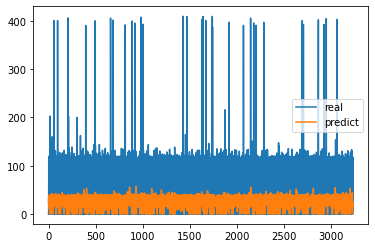

Epoch: 10; Test MAE loss on source data is: 36.305
Epoch: 10; Test MSE loss on source data is: 2080.713


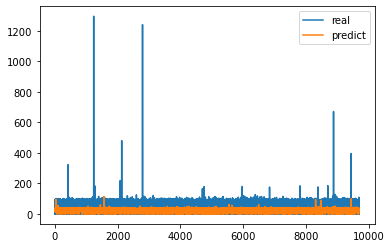

Epoch: 10; MSE loss: 518811.688
49.29586211050496
4229.441354130137
Epoch: 11; MSE loss: 559589.062
46.73573310738185
4210.790055132155
Epoch: 12; MSE loss: 509816.469
45.83832010318175
4229.597923121037
Epoch: 13; MSE loss: 504025.281
45.50161933349863
4221.180493856358
Epoch: 14; MSE loss: 510304.344
45.27428552501905
3975.0737277493827
Epoch: 15; MSE loss: 435624.906
44.931711959312224
4048.2609312546538
Epoch: 16; MSE loss: 486092.625
42.526235750119504
3878.9757622683182
Epoch: 17; MSE loss: 457853.656
43.570966110034185
4004.4106006043908
Epoch: 18; MSE loss: 494475.969
43.20158130661966
3767.620674667088
Epoch: 19; MSE loss: 455526.188
44.366509919911856
3917.796670848889
Epoch: 20; Test MAE loss on target data is: 44.367
Epoch: 20; Test MSE loss on target data is: 3917.797


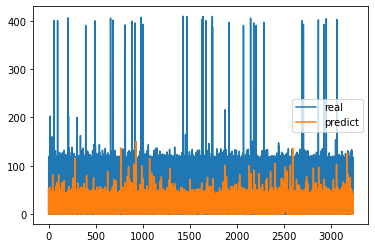

Epoch: 20; Test MAE loss on source data is: 32.487
Epoch: 20; Test MSE loss on source data is: 1779.057


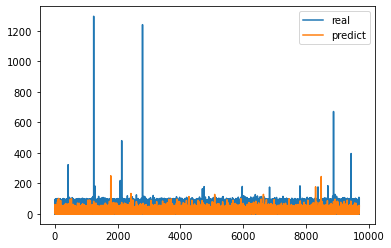

Epoch: 20; MSE loss: 535835.750
43.65286336393316
3984.763999864453
Epoch: 21; MSE loss: 464043.219
44.20569277049216
3995.649029393717
Epoch: 22; MSE loss: 403978.125
42.28088102959776
3734.8424777351365
Epoch: 23; MSE loss: 448591.938
42.67715066266023
3907.680430440544
Epoch: 24; MSE loss: 426501.375
43.68894143960391
4022.0987778348717
Epoch: 25; MSE loss: 417031.281
44.43745693729318
3999.7709935052403
Epoch: 26; MSE loss: 424450.656
44.52176753522071
4006.2858982613543
Epoch: 27; MSE loss: 498226.562
44.7449185928707
4061.0741291894647
Epoch: 28; MSE loss: 443858.500
45.16238328213393
4092.865427916899
Epoch: 29; MSE loss: 386759.938
43.76583592510297
3896.2481755919507
Epoch: 30; Test MAE loss on target data is: 43.766
Epoch: 30; Test MSE loss on target data is: 3896.248


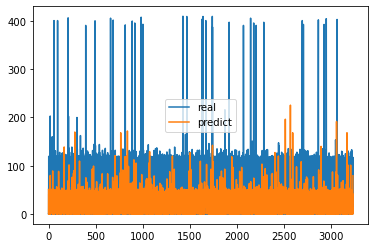

Epoch: 30; Test MAE loss on source data is: 30.258
Epoch: 30; Test MSE loss on source data is: 1661.126


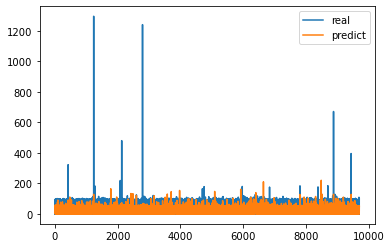

Epoch: 30; MSE loss: 480058.875
43.88157556180423
4098.8202643824525
Epoch: 31; MSE loss: 421323.281
43.66139725996224
4053.046220790054
Epoch: 32; MSE loss: 471628.219
44.323542735749825
4140.863045836151
Epoch: 33; MSE loss: 399925.188
43.75070355818298
3851.694286423057
Epoch: 34; MSE loss: 456134.938
43.69413864692881
4136.982621844057
Epoch: 35; MSE loss: 442847.812
44.773398469418424
4097.675325336123
Epoch: 36; MSE loss: 423051.812
43.828291241463035
4046.966946877513
Epoch: 37; MSE loss: 487766.844
44.60569238926196
4103.35472188867
Epoch: 38; MSE loss: 389257.531
43.76699913254353
4041.5338874257686
Epoch: 39; MSE loss: 399419.281
44.248581202112476
4109.709362370124
Epoch: 40; Test MAE loss on target data is: 44.249
Epoch: 40; Test MSE loss on target data is: 4109.709


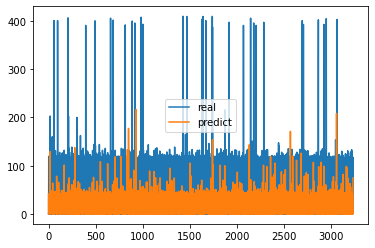

Epoch: 40; Test MAE loss on source data is: 29.633
Epoch: 40; Test MSE loss on source data is: 1658.301


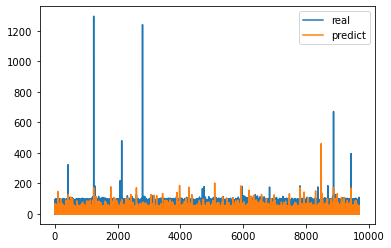

Epoch: 40; MSE loss: 391200.562
43.48519164084896
3947.98462650738
Epoch: 41; MSE loss: 380152.125
44.397989526757996
4196.320230712299
Epoch: 42; MSE loss: 387744.312
44.093645637407555
4135.346985426795
Epoch: 43; MSE loss: 487988.156
44.27033625722147
4144.323080036993
Epoch: 44; MSE loss: 418922.281
42.97537132862731
3993.870400005676
Epoch: 45; MSE loss: 405155.000
43.593278811482776
3994.7416418704215
Epoch: 46; MSE loss: 405760.469
43.88579720502075
4037.058008140333
Epoch: 47; MSE loss: 431337.531
44.074237137607604
4163.354544052271
Epoch: 48; MSE loss: 422451.406
43.30226538430041
3925.802303680562
Epoch: 49; MSE loss: 411196.188
43.470957459474825
3980.2511685549985
Epoch: 50; Test MAE loss on target data is: 43.471
Epoch: 50; Test MSE loss on target data is: 3980.251


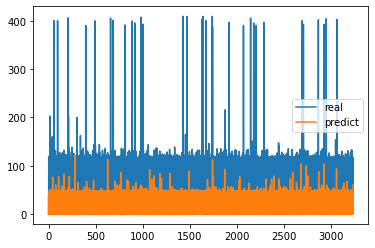

Epoch: 50; Test MAE loss on source data is: 29.104
Epoch: 50; Test MSE loss on source data is: 1659.800


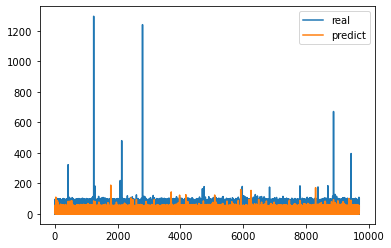

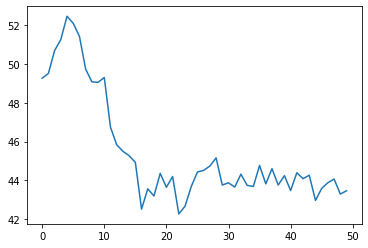

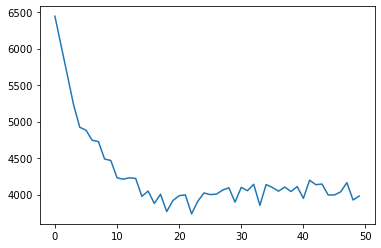

------------Domain Adaptation------------
Epoch: 0; MSE loss: 445203.182
Epoch: 0; disc loss: 68399.319
Epoch: 0; ceod loss: 1233.414
43.386740536759774
4010.422461757688
Parameter containing:
tensor([0.3331, 0.3281, 0.3388], device='cuda:0', requires_grad=True)
Epoch: 1; MSE loss: 415363.628
Epoch: 1; disc loss: 53142.810
Epoch: 1; ceod loss: 1222.913
42.76289997596308
3790.3387274032266
Parameter containing:
tensor([0.3442, 0.3106, 0.3451], device='cuda:0', requires_grad=True)
Epoch: 2; MSE loss: 406213.914
Epoch: 2; disc loss: 39102.471
Epoch: 2; ceod loss: 1218.826
43.58691487239846
4041.378982719572
Parameter containing:
tensor([0.3636, 0.2951, 0.3413], device='cuda:0', requires_grad=True)
Epoch: 3; MSE loss: 409441.872
Epoch: 3; disc loss: 35348.792
Epoch: 3; ceod loss: 1193.204
43.224788391507204
4075.787710166986
Parameter containing:
tensor([0.3825, 0.2863, 0.3313], device='cuda:0', requires_grad=True)
Epoch: 4; MSE loss: 431538.499
Epoch: 4; disc loss: 28234.440
Epoch: 4; ceo

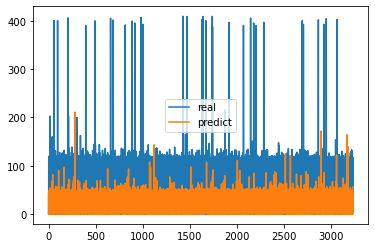

Epoch: 9; Test MAE loss on source data is: 29.269


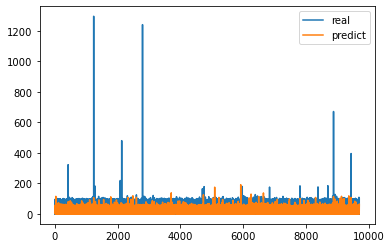

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


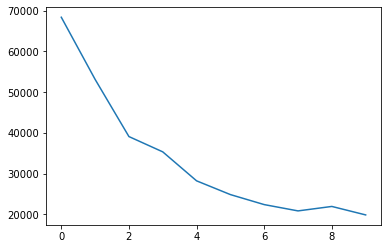

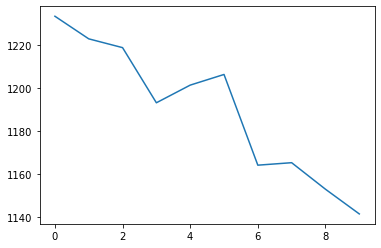

-------------------------- total running losses in 10 epoches as follows---------------------------------


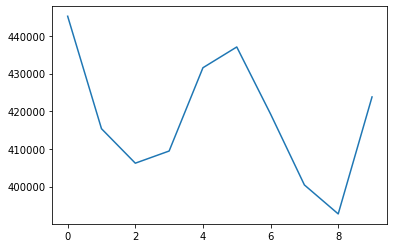

Epoch: 10; MSE loss: 409521.339
Epoch: 10; disc loss: 17355.584
Epoch: 10; ceod loss: 1132.814
43.24415450004927
3938.6744735868388
Parameter containing:
tensor([0.5315, 0.2590, 0.2095], device='cuda:0', requires_grad=True)
Epoch: 11; MSE loss: 397875.701
Epoch: 11; disc loss: 17732.634
Epoch: 11; ceod loss: 1114.359
44.25945261694733
3908.8946307857746
Parameter containing:
tensor([0.5657, 0.2495, 0.1848], device='cuda:0', requires_grad=True)
Epoch: 12; MSE loss: 413687.609
Epoch: 12; disc loss: 16587.885
Epoch: 12; ceod loss: 1121.859
43.44070522889595
3935.630441417307
Parameter containing:
tensor([0.6059, 0.2378, 0.1563], device='cuda:0', requires_grad=True)
Epoch: 13; MSE loss: 469353.293
Epoch: 13; disc loss: 14247.693
Epoch: 13; ceod loss: 1106.118
44.062114074268884
4198.121705282194
Parameter containing:
tensor([0.6444, 0.2313, 0.1244], device='cuda:0', requires_grad=True)
Epoch: 14; MSE loss: 408038.547
Epoch: 14; disc loss: 13797.785
Epoch: 14; ceod loss: 1115.795
43.2507916

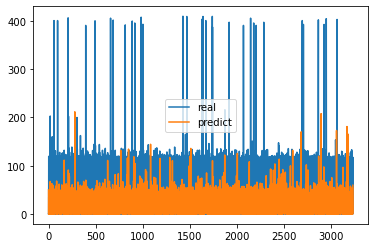

Epoch: 19; Test MAE loss on source data is: 27.363


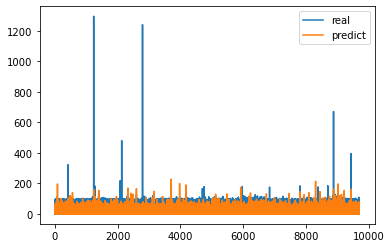

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


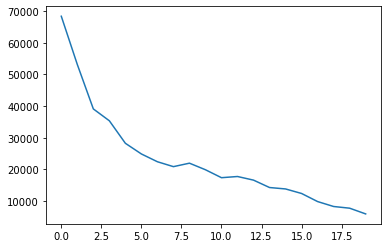

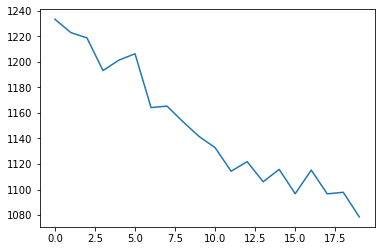

-------------------------- total running losses in 10 epoches as follows---------------------------------


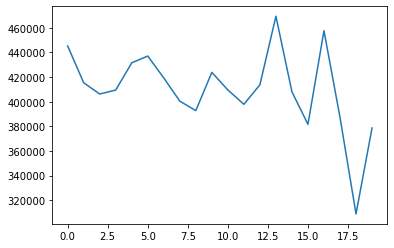

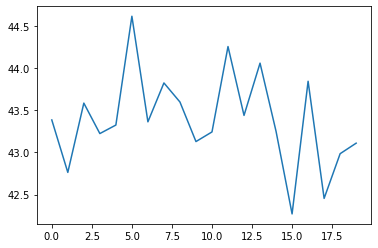

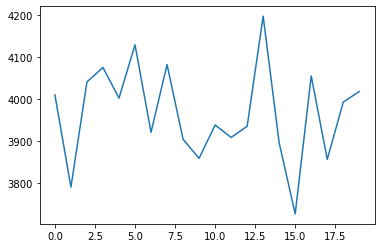

43.11057127961666
0.4157409502169886
0.7739183266227645
Parameter containing:
tensor([0.9320, 0.0347, 0.0333], device='cuda:0', requires_grad=True)

---------------------------------------------- domain num 1 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 1002223.500
39.26087614121563
4284.006805244604
Epoch: 1; MSE loss: 967049.625
39.000960316621864
4103.164040466094
Epoch: 2; MSE loss: 964788.812
39.61434718123544
3798.8985558074
Epoch: 3; MSE loss: 852592.562
40.080264513533116
3605.252535185092
Epoch: 4; MSE loss: 785958.875
40.63943513959784
3233.7788623080105
Epoch: 5; MSE loss: 788234.188
41.105330594227155
3060.476996349023
Epoch: 6; MSE loss: 722010.750
41.117882051055176
3032.8121692191016
Epoch: 7; MSE loss: 833480.750
40.680279813225525
2942.214414050387
Epoch: 8; MSE loss: 728342.062
40.44879473355675
2815.113727841425
Epoch: 9; MSE loss: 658866.562
40.040625582983175
2883.3547543598092
Epoch: 10; Test MAE loss on tar

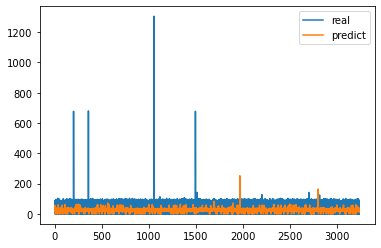

Epoch: 10; Test MAE loss on source data is: 39.226
Epoch: 10; Test MSE loss on source data is: 2640.177


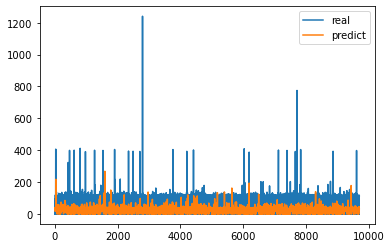

Epoch: 10; MSE loss: 708449.000
39.49367902708201
2735.125549142538
Epoch: 11; MSE loss: 671218.500
39.67700103150085
2714.3361826822393
Epoch: 12; MSE loss: 679637.000
40.02604878251851
2710.456052508235
Epoch: 13; MSE loss: 679493.188
38.980820235614615
2625.1299264261825
Epoch: 14; MSE loss: 681918.875
39.60567831860443
2630.989370897317
Epoch: 15; MSE loss: 712853.000
39.23611212013494
2655.1703569060187
Epoch: 16; MSE loss: 647813.688
39.281524809932414
2645.8587030344897
Epoch: 17; MSE loss: 700235.438
38.80796909011681
2623.9241515214835
Epoch: 18; MSE loss: 737680.375
38.35999032481008
2593.2015854754354
Epoch: 19; MSE loss: 713203.750
39.4090246141786
2572.852714574608
Epoch: 20; Test MAE loss on target data is: 39.409
Epoch: 20; Test MSE loss on target data is: 2572.853


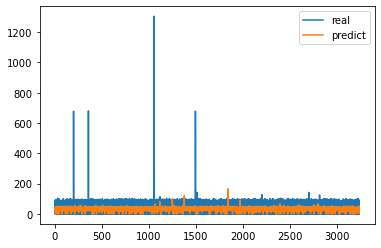

Epoch: 20; Test MAE loss on source data is: 41.512
Epoch: 20; Test MSE loss on source data is: 2571.324


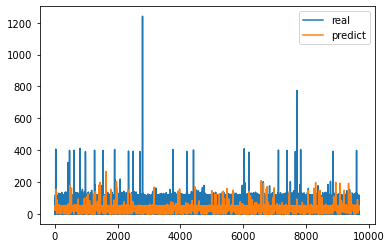

Epoch: 20; MSE loss: 680124.000
39.14558225586849
2614.201854810569
Epoch: 21; MSE loss: 643847.188
38.99434817079599
2561.0225699042207
Epoch: 22; MSE loss: 668963.375
37.11463698574343
2512.126441373164
Epoch: 23; MSE loss: 719048.250
38.5946350480342
2569.330486723364
Epoch: 24; MSE loss: 647637.812
38.34166224338172
2511.761893818795
Epoch: 25; MSE loss: 709054.250
36.28870746995419
2511.89035154192
Epoch: 26; MSE loss: 663201.750
37.68973324430597
2496.4236188170203
Epoch: 27; MSE loss: 667533.812
39.308063883353974
2528.299024400573
Epoch: 28; MSE loss: 621059.812
36.43373949715675
2491.670542876268
Epoch: 29; MSE loss: 599093.625
38.122258990625326
2519.5923833778147
Epoch: 30; Test MAE loss on target data is: 38.122
Epoch: 30; Test MSE loss on target data is: 2519.592


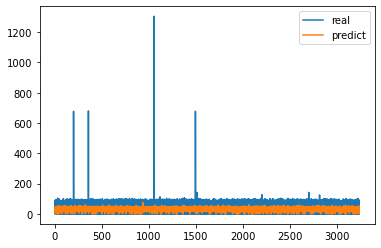

Epoch: 30; Test MAE loss on source data is: 39.776
Epoch: 30; Test MSE loss on source data is: 2419.692


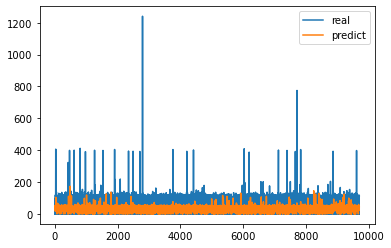

Epoch: 30; MSE loss: 658517.688
35.70363725435789
2500.925054684601
Epoch: 31; MSE loss: 644695.938
35.14714047588189
2503.5731012486185
Epoch: 32; MSE loss: 651824.500
35.3022706951756
2405.4035933869304
Epoch: 33; MSE loss: 628696.750
32.86564981801064
2362.7617111008904
Epoch: 34; MSE loss: 601516.062
33.73868871838822
2414.88131245188
Epoch: 35; MSE loss: 647733.750
34.23290527652736
2401.3985591859937
Epoch: 36; MSE loss: 597774.812
32.74724974508816
2420.4092643158515
Epoch: 37; MSE loss: 585773.688
31.954286563009532
2298.696157655063
Epoch: 38; MSE loss: 530435.812
32.90450071509139
2387.452166660616
Epoch: 39; MSE loss: 602950.000
32.46008026256259
2308.825581629036
Epoch: 40; Test MAE loss on target data is: 32.460
Epoch: 40; Test MSE loss on target data is: 2308.826


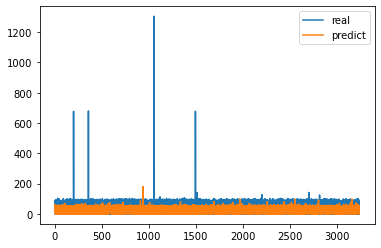

Epoch: 40; Test MAE loss on source data is: 34.671
Epoch: 40; Test MSE loss on source data is: 2237.942


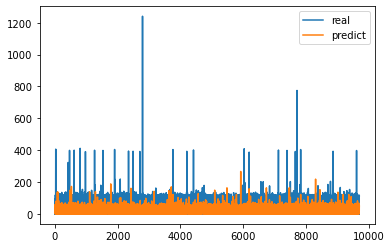

Epoch: 40; MSE loss: 557798.500
32.02820715093539
2261.246826836414
Epoch: 41; MSE loss: 563983.375
32.346988532900625
2300.866408029607
Epoch: 42; MSE loss: 509947.344
31.650069702325684
2282.773567740751
Epoch: 43; MSE loss: 554448.438
31.962734245719645
2258.219505363528
Epoch: 44; MSE loss: 536095.312
32.1211012226813
2260.3817978993366
Epoch: 45; MSE loss: 518306.562
31.04677147266485
2215.2562655833967
Epoch: 46; MSE loss: 572587.188
31.653527847830627
2276.712626580088
Epoch: 47; MSE loss: 571194.688
31.962205459575934
2344.0845087186444
Epoch: 48; MSE loss: 620866.312
31.927364372580644
2264.981515273482
Epoch: 49; MSE loss: 544258.688
31.90457667346347
2245.1307221096627
Epoch: 50; Test MAE loss on target data is: 31.905
Epoch: 50; Test MSE loss on target data is: 2245.131


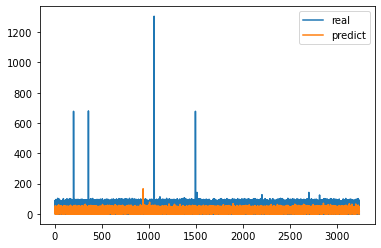

Epoch: 50; Test MAE loss on source data is: 34.247
Epoch: 50; Test MSE loss on source data is: 2224.846


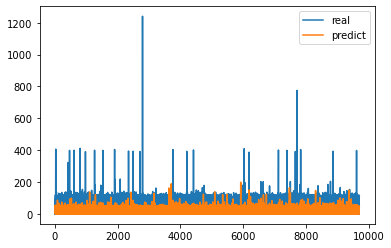

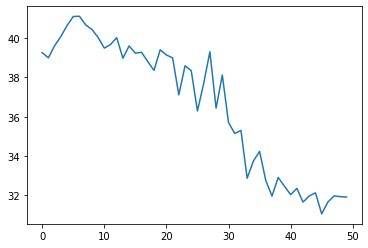

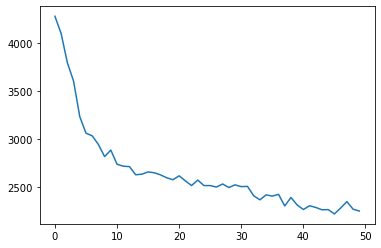

------------Domain Adaptation------------
Epoch: 0; MSE loss: 561386.065
Epoch: 0; disc loss: 149007.298
Epoch: 0; ceod loss: 1573.923
31.01305205149481
2239.357009246679
Parameter containing:
tensor([0.3355, 0.3304, 0.3340], device='cuda:0', requires_grad=True)
Epoch: 1; MSE loss: 540319.658
Epoch: 1; disc loss: 143061.799
Epoch: 1; ceod loss: 1541.238
32.027636869650166
2327.390344005746
Parameter containing:
tensor([0.3471, 0.3148, 0.3381], device='cuda:0', requires_grad=True)
Epoch: 2; MSE loss: 529374.276
Epoch: 2; disc loss: 152881.581
Epoch: 2; ceod loss: 1554.126
32.685677481360926
2408.9121815516564
Parameter containing:
tensor([0.3661, 0.2892, 0.3447], device='cuda:0', requires_grad=True)
Epoch: 3; MSE loss: 531261.234
Epoch: 3; disc loss: 163352.824
Epoch: 3; ceod loss: 1527.107
33.31384900262957
2427.118772467555
Parameter containing:
tensor([0.3808, 0.2666, 0.3526], device='cuda:0', requires_grad=True)
Epoch: 4; MSE loss: 569629.810
Epoch: 4; disc loss: 188362.511
Epoch: 4

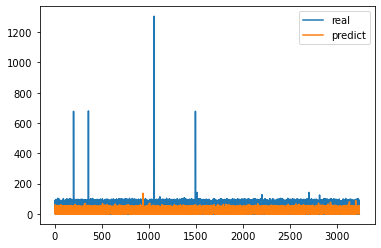

Epoch: 9; Test MAE loss on source data is: 32.715


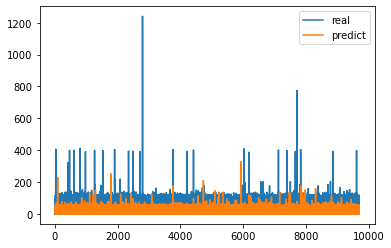

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


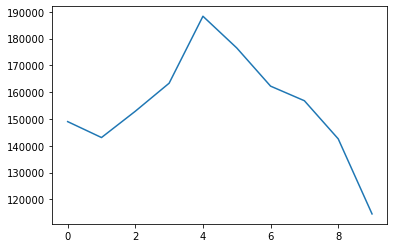

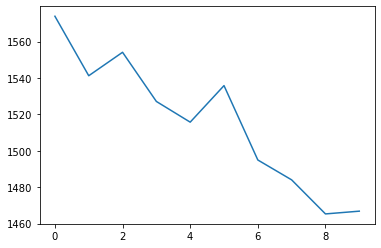

-------------------------- total running losses in 10 epoches as follows---------------------------------


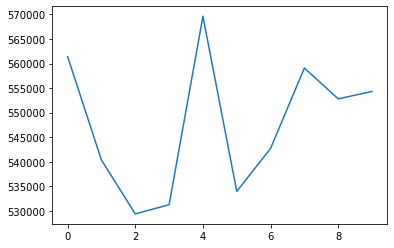

Epoch: 10; MSE loss: 535261.605
Epoch: 10; disc loss: 105352.477
Epoch: 10; ceod loss: 1386.334
32.30266896034872
2304.0114158086367
Parameter containing:
tensor([0.5034, 0.0633, 0.4333], device='cuda:0', requires_grad=True)
Epoch: 11; MSE loss: 573308.197
Epoch: 11; disc loss: 84820.807
Epoch: 11; ceod loss: 1427.353
32.49755427433866
2363.0418701402896
Parameter containing:
tensor([0.5273, 0.0333, 0.4394], device='cuda:0', requires_grad=True)
Epoch: 12; MSE loss: 552413.425
Epoch: 12; disc loss: 80447.619
Epoch: 12; ceod loss: 1383.930
31.978475955197762
2361.819543351359
Parameter containing:
tensor([0.5368, 0.0333, 0.4299], device='cuda:0', requires_grad=True)
Epoch: 13; MSE loss: 554487.867
Epoch: 13; disc loss: 84120.596
Epoch: 13; ceod loss: 1399.657
33.090542612986
2398.316840721604
Parameter containing:
tensor([0.5448, 0.0333, 0.4218], device='cuda:0', requires_grad=True)
Epoch: 14; MSE loss: 566458.309
Epoch: 14; disc loss: 85399.602
Epoch: 14; ceod loss: 1362.648
32.38125046

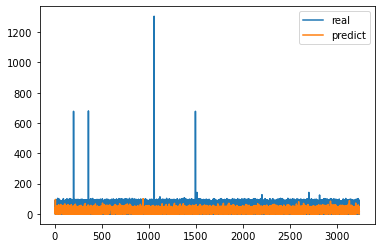

Epoch: 19; Test MAE loss on source data is: 34.124


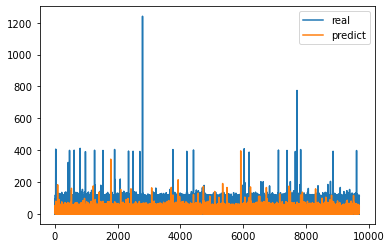

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


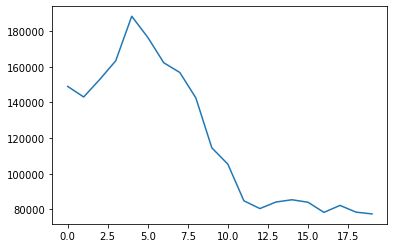

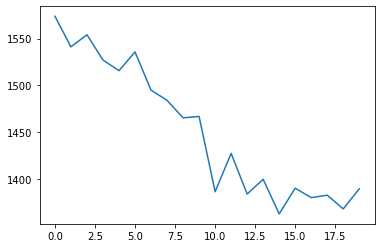

-------------------------- total running losses in 10 epoches as follows---------------------------------


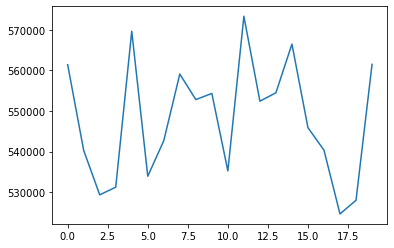

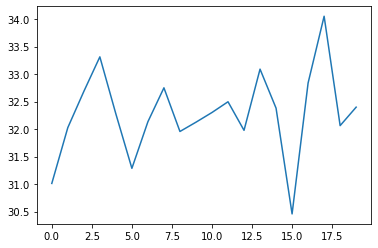

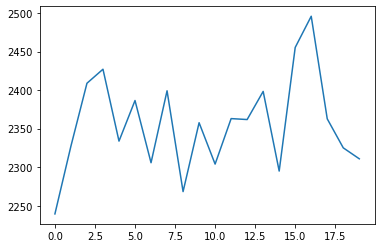

32.39952945204386
0.2146189603357089
0.7287846089332637
Parameter containing:
tensor([0.6142, 0.0333, 0.3524], device='cuda:0', requires_grad=True)

---------------------------------------------- domain num 2 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 1078983.750
30.682922112402814
2521.1179195346635
Epoch: 1; MSE loss: 986484.062
33.02285385497571
2313.3560177610907
Epoch: 2; MSE loss: 878469.562
34.92136899725731
2335.119473107222
Epoch: 3; MSE loss: 858571.750
36.972049610464154
2187.7427543839335
Epoch: 4; MSE loss: 792549.812
37.27352468556562
2127.6078630757584
Epoch: 5; MSE loss: 724561.312
37.621175613939485
1919.7017147748845
Epoch: 6; MSE loss: 645918.500
37.109782729948506
1850.9532244384864
Epoch: 7; MSE loss: 603058.375
34.52569701666073
1842.7181062075667
Epoch: 8; MSE loss: 678821.875
33.28229241463279
1818.6712307417959
Epoch: 9; MSE loss: 591699.188
33.39400071722601
1805.0545261853106
Epoch: 10; Test MAE loss 

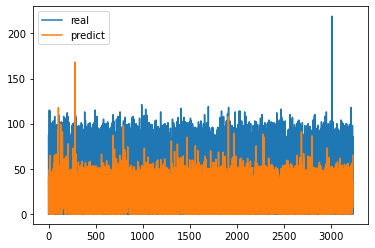

Epoch: 10; Test MAE loss on source data is: 34.171
Epoch: 10; Test MSE loss on source data is: 2409.716


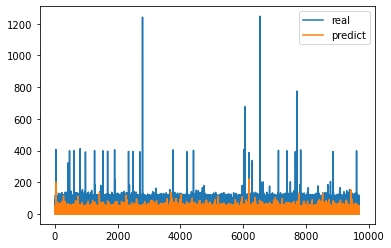

Epoch: 10; MSE loss: 611651.625
32.81562416202963
1832.398989005436
Epoch: 11; MSE loss: 597946.812
32.25150826718929
1889.3568670785887
Epoch: 12; MSE loss: 608404.375
33.45176088621111
1773.0878836819238
Epoch: 13; MSE loss: 593306.312
33.93419970356884
1746.1269377121434
Epoch: 14; MSE loss: 602124.250
33.049348520624584
1774.9288251707374
Epoch: 15; MSE loss: 558517.000
33.35100541306887
1752.229167145305
Epoch: 16; MSE loss: 548610.250
32.479068770493384
1954.8385763651063
Epoch: 17; MSE loss: 537729.750
32.74958265526033
1837.5228490032337
Epoch: 18; MSE loss: 598691.125
32.36474221685478
1889.7135417745046
Epoch: 19; MSE loss: 546468.312
32.236106624738696
1891.3294513722426
Epoch: 20; Test MAE loss on target data is: 32.236
Epoch: 20; Test MSE loss on target data is: 1891.329


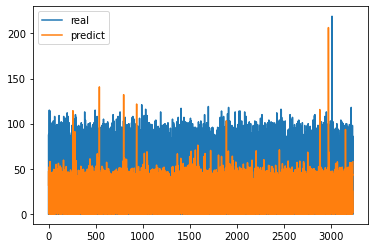

Epoch: 20; Test MAE loss on source data is: 33.125
Epoch: 20; Test MSE loss on source data is: 2378.107


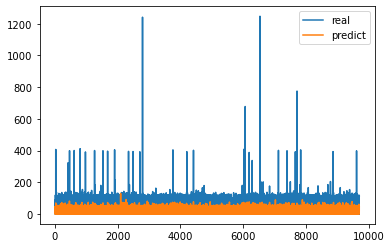

Epoch: 20; MSE loss: 527470.812
32.95625816042862
1762.7087873870107
Epoch: 21; MSE loss: 528622.562
32.709069074227415
1896.1191064491816
Epoch: 22; MSE loss: 496950.906
32.72384052708676
1803.0502578362405
Epoch: 23; MSE loss: 528384.625
32.53529086609528
1884.520913988221
Epoch: 24; MSE loss: 526149.312
32.960433003739375
1913.316550723975
Epoch: 25; MSE loss: 536741.000
32.88836981792354
1793.8527499265238
Epoch: 26; MSE loss: 528193.375
32.66443187987786
1868.8262245744013
Epoch: 27; MSE loss: 561430.750
32.613246550124245
1881.592050708331
Epoch: 28; MSE loss: 495858.625
33.905194591941566
1785.1914966052966
Epoch: 29; MSE loss: 541144.375
32.616005833237395
1835.6582924814622
Epoch: 30; Test MAE loss on target data is: 32.616
Epoch: 30; Test MSE loss on target data is: 1835.658


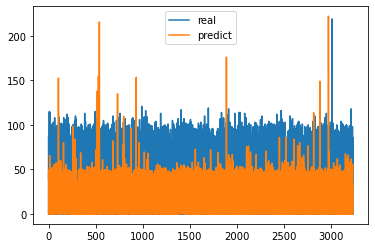

Epoch: 30; Test MAE loss on source data is: 32.564
Epoch: 30; Test MSE loss on source data is: 2263.046


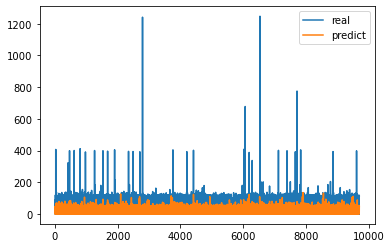

Epoch: 30; MSE loss: 519354.781
32.41602591059676
1836.2519187829307
Epoch: 31; MSE loss: 475357.938
32.342239236619776
2112.0643076602178
Epoch: 32; MSE loss: 487591.375
31.81472733990855
1967.9458568642124
Epoch: 33; MSE loss: 543497.000
32.778525505653676
1982.4363498846303
Epoch: 34; MSE loss: 505725.656
32.52659828095385
1934.1514005004376
Epoch: 35; MSE loss: 504340.844
32.41366875943666
2097.472016361604
Epoch: 36; MSE loss: 503611.344
32.51190349410822
2061.2509896276442
Epoch: 37; MSE loss: 503993.094
32.4904557110998
1916.5915435944617
Epoch: 38; MSE loss: 474223.094
32.13175410825005
2012.9223001751923
Epoch: 39; MSE loss: 503314.188
32.36476278242409
2013.9462759171806
Epoch: 40; Test MAE loss on target data is: 32.365
Epoch: 40; Test MSE loss on target data is: 2013.946


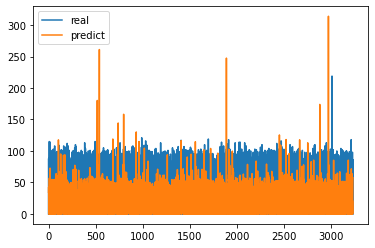

Epoch: 40; Test MAE loss on source data is: 31.367
Epoch: 40; Test MSE loss on source data is: 2188.855


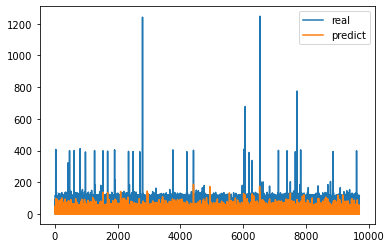

Epoch: 40; MSE loss: 497704.625
32.57014044811589
1971.170744660745
Epoch: 41; MSE loss: 479534.375
33.35924304785463
1812.9195083366767
Epoch: 42; MSE loss: 512076.406
33.083791476547994
1990.5281167429441
Epoch: 43; MSE loss: 481058.188
32.49406078175931
1926.8650879229633
Epoch: 44; MSE loss: 461438.594
33.179482898249695
2206.244307329202
Epoch: 45; MSE loss: 523718.344
33.310512483912234
1850.540275628741
Epoch: 46; MSE loss: 523842.188
32.43847406927548
1967.1335373491993
Epoch: 47; MSE loss: 461795.719
32.67399870450659
1970.0652404613868
Epoch: 48; MSE loss: 451344.219
32.82336609787329
2104.1737494218523
Epoch: 49; MSE loss: 503555.375
32.5818290985211
2126.69902448068
Epoch: 50; Test MAE loss on target data is: 32.582
Epoch: 50; Test MSE loss on target data is: 2126.699


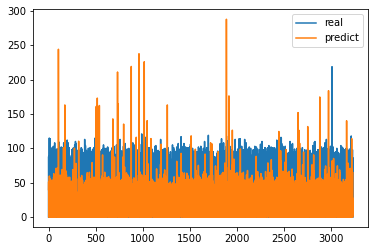

Epoch: 50; Test MAE loss on source data is: 30.207
Epoch: 50; Test MSE loss on source data is: 2104.171


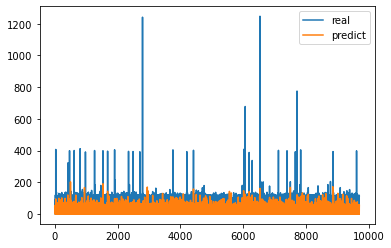

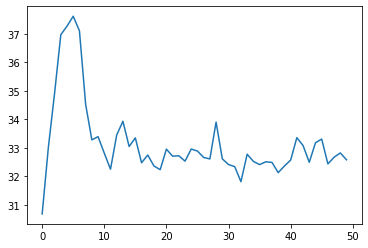

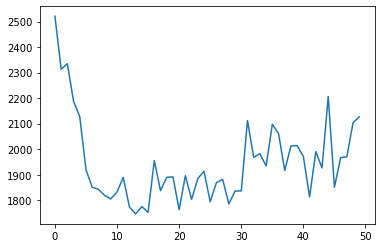

------------Domain Adaptation------------
Epoch: 0; MSE loss: 453289.067
Epoch: 0; disc loss: 143147.266
Epoch: 0; ceod loss: 1282.002
33.52785674188016
1761.7227793343247
Parameter containing:
tensor([0.3304, 0.3363, 0.3334], device='cuda:0', requires_grad=True)
Epoch: 1; MSE loss: 517936.231
Epoch: 1; disc loss: 57835.315
Epoch: 1; ceod loss: 1301.556
33.68197864106118
2420.0042401229257
Parameter containing:
tensor([0.3291, 0.3425, 0.3284], device='cuda:0', requires_grad=True)
Epoch: 2; MSE loss: 442987.772
Epoch: 2; disc loss: 37916.477
Epoch: 2; ceod loss: 1287.839
32.32713800023383
2014.6923031232923
Parameter containing:
tensor([0.3357, 0.3441, 0.3202], device='cuda:0', requires_grad=True)
Epoch: 3; MSE loss: 471311.615
Epoch: 3; disc loss: 29619.772
Epoch: 3; ceod loss: 1282.864
32.32779025020887
2023.766171597134
Parameter containing:
tensor([0.3433, 0.3450, 0.3117], device='cuda:0', requires_grad=True)
Epoch: 4; MSE loss: 452374.351
Epoch: 4; disc loss: 29872.404
Epoch: 4; ce

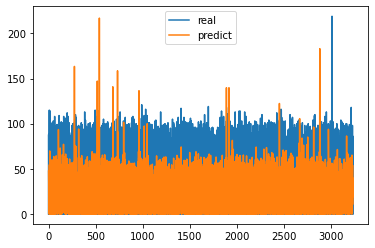

Epoch: 9; Test MAE loss on source data is: 31.248


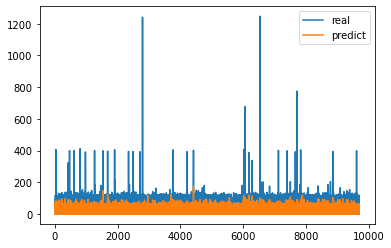

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


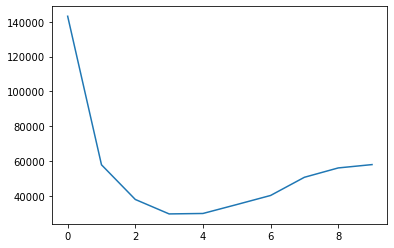

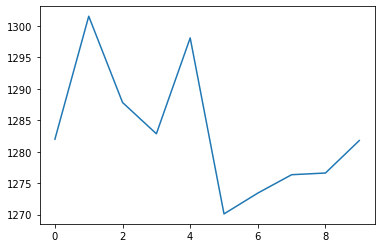

-------------------------- total running losses in 10 epoches as follows---------------------------------


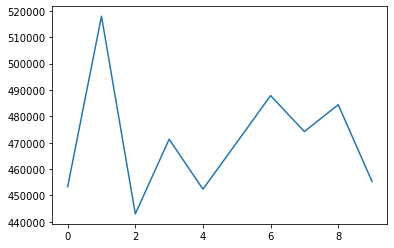

Epoch: 10; MSE loss: 444834.530
Epoch: 10; disc loss: 58200.167
Epoch: 10; ceod loss: 1281.890
32.288304112315
2046.751605645421
Parameter containing:
tensor([0.3770, 0.3370, 0.2860], device='cuda:0', requires_grad=True)
Epoch: 11; MSE loss: 494096.011
Epoch: 11; disc loss: 58743.426
Epoch: 11; ceod loss: 1275.967
32.33189719188066
1898.2315202059167
Parameter containing:
tensor([0.3826, 0.3355, 0.2819], device='cuda:0', requires_grad=True)
Epoch: 12; MSE loss: 441913.006
Epoch: 12; disc loss: 58369.550
Epoch: 12; ceod loss: 1293.159
32.77546939383703
2144.748840607874
Parameter containing:
tensor([0.3893, 0.3334, 0.2773], device='cuda:0', requires_grad=True)
Epoch: 13; MSE loss: 487637.872
Epoch: 13; disc loss: 54998.040
Epoch: 13; ceod loss: 1296.144
32.5130609325961
2177.1063268675425
Parameter containing:
tensor([0.3954, 0.3311, 0.2735], device='cuda:0', requires_grad=True)
Epoch: 14; MSE loss: 466448.045
Epoch: 14; disc loss: 56321.787
Epoch: 14; ceod loss: 1269.569
32.55212474532

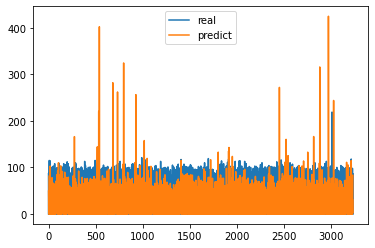

Epoch: 19; Test MAE loss on source data is: 28.257


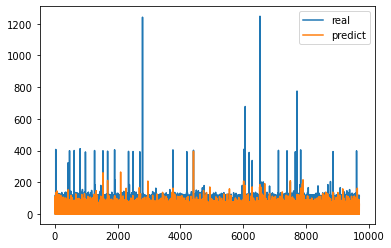

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


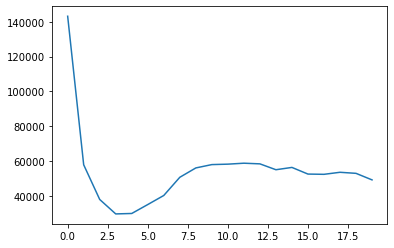

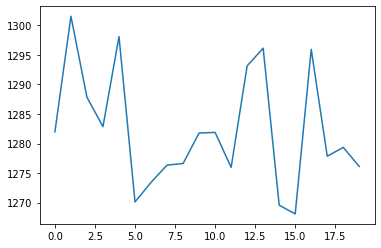

-------------------------- total running losses in 10 epoches as follows---------------------------------


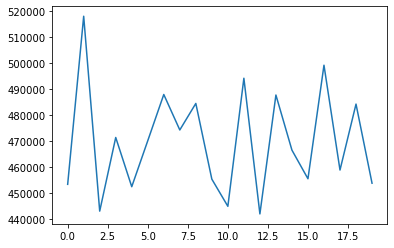

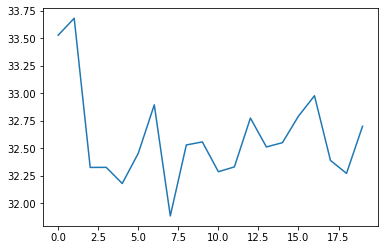

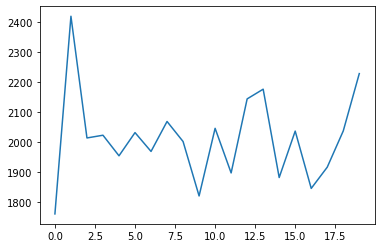

32.70082140053627
0.10940520465624474
0.9005142596386403
Parameter containing:
tensor([0.4458, 0.3248, 0.2293], device='cuda:0', requires_grad=True)

---------------------------------------------- domain num 3 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 1122736.000
25.88130260185271
2947.476641145151
Epoch: 1; MSE loss: 1061729.000
28.704396005787842
2666.9137755272764
Epoch: 2; MSE loss: 982024.812
29.695830121240256
2523.489821936359
Epoch: 3; MSE loss: 926644.688
31.233146206249224
2421.0274957077395
Epoch: 4; MSE loss: 958738.688
33.64888884251048
2341.5635787391866
Epoch: 5; MSE loss: 829413.438
34.84798526380678
2321.2213148844717
Epoch: 6; MSE loss: 872674.812
35.247916830175626
2336.0807662484754
Epoch: 7; MSE loss: 877213.438
36.22516941507412
2351.9155041750655
Epoch: 8; MSE loss: 731807.438
35.699950128416006
2344.2362747293223
Epoch: 9; MSE loss: 750770.625
35.54211337216302
2335.0828183666085
Epoch: 10; Test MAE los

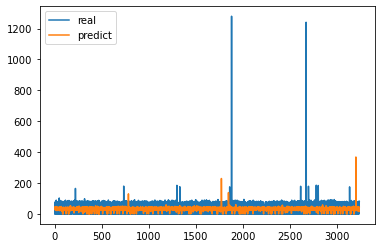

Epoch: 10; Test MAE loss on source data is: 42.769
Epoch: 10; Test MSE loss on source data is: 2999.453


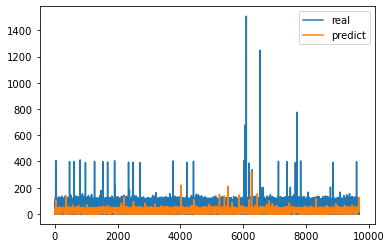

Epoch: 10; MSE loss: 780230.500
36.68983095362898
2406.710647470166
Epoch: 11; MSE loss: 730369.812
35.818060258809346
2304.4889866227913
Epoch: 12; MSE loss: 733749.250
34.48270833208535
2255.3165666673817
Epoch: 13; MSE loss: 694497.375
33.66493349576476
2258.665549261258
Epoch: 14; MSE loss: 643464.625
34.28975615763038
2274.307624931249
Epoch: 15; MSE loss: 664805.375
33.46266591618474
2265.4294865272886
Epoch: 16; MSE loss: 627187.812
32.67996131375179
2268.612308861074
Epoch: 17; MSE loss: 605424.000
33.494576721674136
2308.5996790481295
Epoch: 18; MSE loss: 662383.812
35.19639796190874
2285.0487674357587
Epoch: 19; MSE loss: 623363.750
29.49189604555805
2185.79673096108
Epoch: 20; Test MAE loss on target data is: 29.492
Epoch: 20; Test MSE loss on target data is: 2185.797


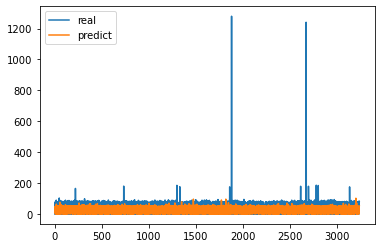

Epoch: 20; Test MAE loss on source data is: 34.103
Epoch: 20; Test MSE loss on source data is: 2609.296


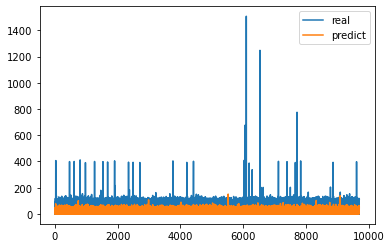

Epoch: 20; MSE loss: 639659.312
31.646275587575698
2225.9088706538914
Epoch: 21; MSE loss: 568417.500
32.65251373777618
2261.917052382868
Epoch: 22; MSE loss: 568648.250
31.604468460493884
2252.6364182435364
Epoch: 23; MSE loss: 627082.625
31.162578403120616
2217.690260885268
Epoch: 24; MSE loss: 609622.562
30.867987753545297
2235.344628500244
Epoch: 25; MSE loss: 590779.375
31.09879721491101
2221.080441915954
Epoch: 26; MSE loss: 605027.938
30.207810186358657
2193.397684140025
Epoch: 27; MSE loss: 540917.125
33.38789419055538
2275.9677392066183
Epoch: 28; MSE loss: 582950.312
31.594579508112975
2244.2247650830286
Epoch: 29; MSE loss: 620522.000
30.708773193002852
2209.5184676315603
Epoch: 30; Test MAE loss on target data is: 30.709
Epoch: 30; Test MSE loss on target data is: 2209.518


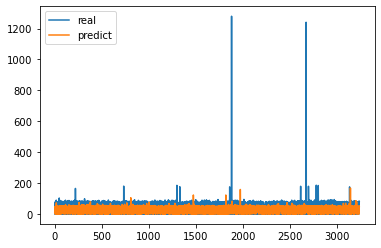

Epoch: 30; Test MAE loss on source data is: 34.119
Epoch: 30; Test MSE loss on source data is: 2518.674


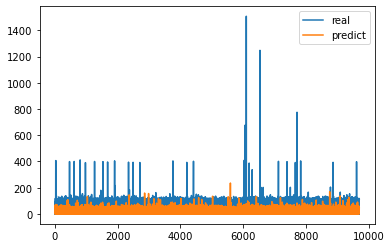

Epoch: 30; MSE loss: 551777.000
31.31039835666947
2240.5182461159093
Epoch: 31; MSE loss: 622337.750
32.216234361241
2264.2035515318457
Epoch: 32; MSE loss: 603023.500
31.82472295918181
2225.1583901511513
Epoch: 33; MSE loss: 591653.250
31.179423839917877
2194.9692634513176
Epoch: 34; MSE loss: 563223.438
30.177855343096407
2275.779205343174
Epoch: 35; MSE loss: 569129.875
29.56051779836186
2244.794573336635
Epoch: 36; MSE loss: 581798.000
30.662102164118515
2222.970253976745
Epoch: 37; MSE loss: 666178.375
31.330966994567117
2286.710322621764
Epoch: 38; MSE loss: 548581.375
31.952659479290293
2349.9125774296754
Epoch: 39; MSE loss: 618170.000
30.660973396763737
2167.6056242801596
Epoch: 40; Test MAE loss on target data is: 30.661
Epoch: 40; Test MSE loss on target data is: 2167.606


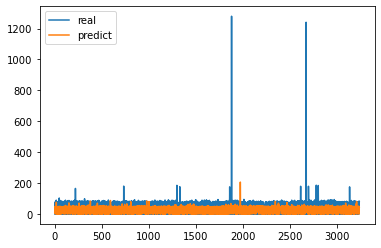

Epoch: 40; Test MAE loss on source data is: 34.142
Epoch: 40; Test MSE loss on source data is: 2513.727


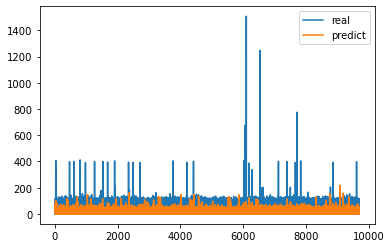

Epoch: 40; MSE loss: 576959.312
31.333728927069874
2311.5405718006555
Epoch: 41; MSE loss: 603781.250
30.840126303119305
2249.7774704742187
Epoch: 42; MSE loss: 566754.250
31.3816236029821
2272.3024627629006
Epoch: 43; MSE loss: 562150.062
30.98000978620196
2291.1669040579186
Epoch: 44; MSE loss: 553668.562
29.99195434018578
2255.907532908407
Epoch: 45; MSE loss: 566035.500
28.645440841158724
2145.5171477251106
Epoch: 46; MSE loss: 580949.125
32.04801708516971
2370.807954471202
Epoch: 47; MSE loss: 510998.031
30.61888371972249
2230.946235280477
Epoch: 48; MSE loss: 551185.125
30.475636987155518
2302.158699530253
Epoch: 49; MSE loss: 555975.812
29.66393887385887
2246.973860957445
Epoch: 50; Test MAE loss on target data is: 29.664
Epoch: 50; Test MSE loss on target data is: 2246.974


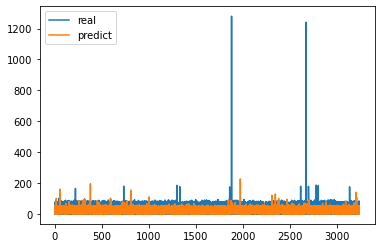

Epoch: 50; Test MAE loss on source data is: 33.220
Epoch: 50; Test MSE loss on source data is: 2474.414


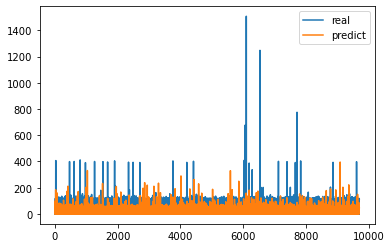

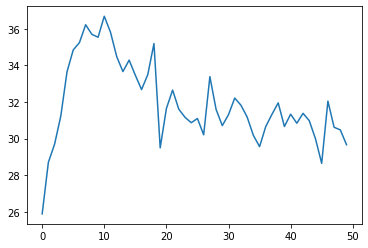

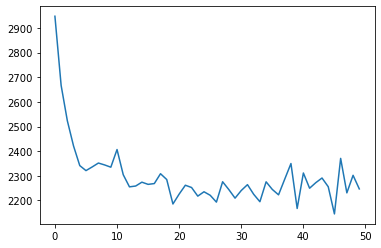

------------Domain Adaptation------------
Epoch: 0; MSE loss: 566145.917
Epoch: 0; disc loss: 134878.438
Epoch: 0; ceod loss: 1219.745
31.31441436336711
2374.9306415247484
Parameter containing:
tensor([0.3320, 0.3361, 0.3319], device='cuda:0', requires_grad=True)
Epoch: 1; MSE loss: 524442.502
Epoch: 1; disc loss: 103170.264
Epoch: 1; ceod loss: 1212.049
31.78028719896419
2359.566596594032
Parameter containing:
tensor([0.3406, 0.3482, 0.3113], device='cuda:0', requires_grad=True)
Epoch: 2; MSE loss: 521184.472
Epoch: 2; disc loss: 107612.353
Epoch: 2; ceod loss: 1180.660
30.032128578544217
2628.705945119599
Parameter containing:
tensor([0.3450, 0.3646, 0.2903], device='cuda:0', requires_grad=True)
Epoch: 3; MSE loss: 532778.146
Epoch: 3; disc loss: 118087.285
Epoch: 3; ceod loss: 1159.282
29.654393414072864
2199.53148986251
Parameter containing:
tensor([0.3414, 0.3852, 0.2734], device='cuda:0', requires_grad=True)
Epoch: 4; MSE loss: 503094.763
Epoch: 4; disc loss: 133204.093
Epoch: 4;

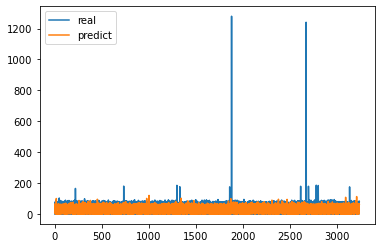

Epoch: 9; Test MAE loss on source data is: 30.969


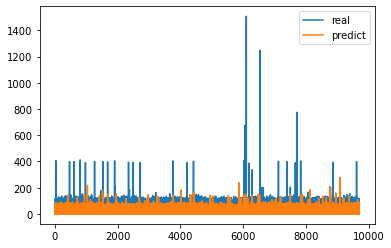

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


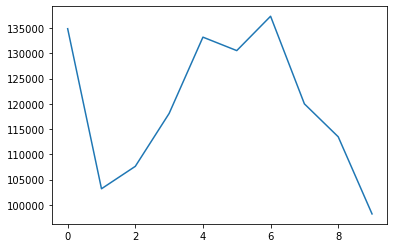

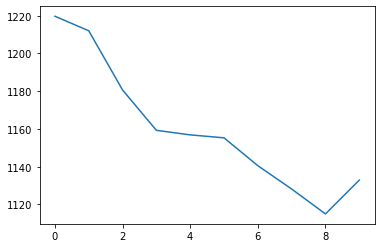

-------------------------- total running losses in 10 epoches as follows---------------------------------


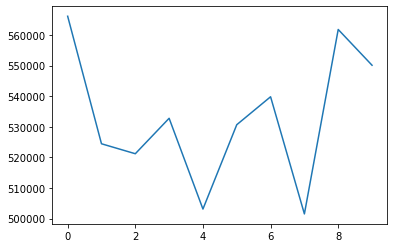

Epoch: 10; MSE loss: 490462.202
Epoch: 10; disc loss: 84416.484
Epoch: 10; ceod loss: 1119.794
28.458346390705756
2293.4219766005253
Parameter containing:
tensor([0.2927, 0.5533, 0.1540], device='cuda:0', requires_grad=True)
Epoch: 11; MSE loss: 428739.520
Epoch: 11; disc loss: 85675.617
Epoch: 11; ceod loss: 1105.300
31.051755663932198
2765.050708667785
Parameter containing:
tensor([0.2847, 0.5894, 0.1259], device='cuda:0', requires_grad=True)
Epoch: 12; MSE loss: 494580.597
Epoch: 12; disc loss: 74484.694
Epoch: 12; ceod loss: 1083.324
30.589307020408846
2251.478170823695
Parameter containing:
tensor([0.2752, 0.6310, 0.0938], device='cuda:0', requires_grad=True)
Epoch: 13; MSE loss: 484729.519
Epoch: 13; disc loss: 60715.065
Epoch: 13; ceod loss: 1075.432
28.744775198241104
2173.6544038128513
Parameter containing:
tensor([0.2656, 0.6777, 0.0566], device='cuda:0', requires_grad=True)
Epoch: 14; MSE loss: 461356.330
Epoch: 14; disc loss: 47966.962
Epoch: 14; ceod loss: 1061.941
30.2409

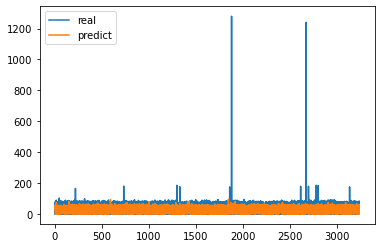

Epoch: 19; Test MAE loss on source data is: 32.606


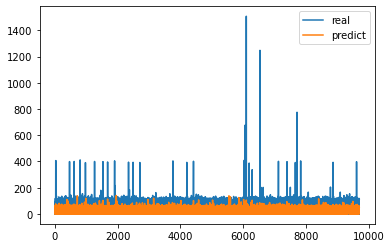

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


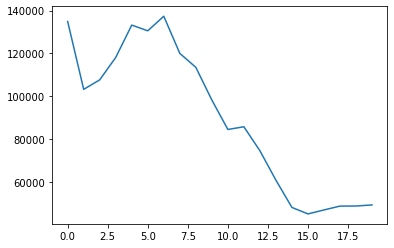

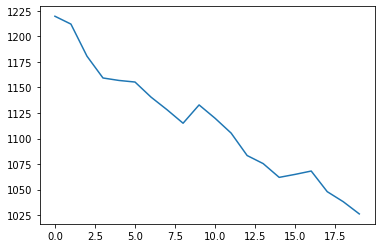

-------------------------- total running losses in 10 epoches as follows---------------------------------


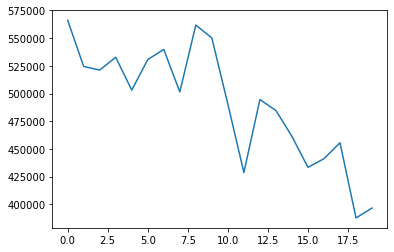

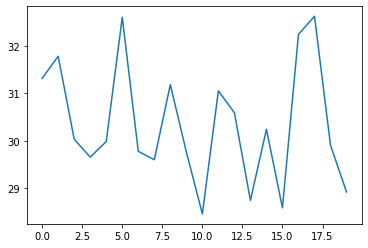

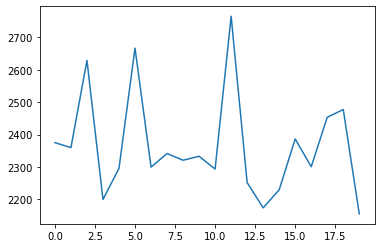

28.921236516316487
0.20770786738092661
0.8518946321240721
Parameter containing:
tensor([0.1134, 0.8533, 0.0333], device='cuda:0', requires_grad=True)


In [ ]:
import importlib
import matplotlib.pyplot as plt

#Number of experiments to launch
num_data_sets=len(fileList)
num_domains=num_data_sets-1
nb_experiments = 1

#-np.inf
params= {'input_dim': 19, 'output_dim': 1, 'n_sources': num_data_sets-1, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': 0, 'max_pred': np.inf}

#Number of epochs
epochs_pretrain, epochs_adapt =50,20

for exp in range(nb_experiments):
    print('\n ----------------------------- %i / %i -----------------------------'%(exp+1, nb_experiments))
    mse_list, mae_list =  {}, {}
    alphas = {}
    for i in range(num_data_sets):
        print('\n---------------------------------------------- domain num %i is running----------------------------------'%(i))
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        
        ############################# Build and define model ####################################
        params['feature_extractor'] = get_feature_extractor()
        params['h_pred'] = get_predictor(output_dim=1)
        params['h_disc'] = get_discriminator(num_domains, output_dim=1)
        model = Disc_MSDANet(params).to(device)

#         #Pre-training
        print('------------Pre-training------------')
        lr = 0.0001
        lr1=0.00001
        batch_size =64
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        mae_loss,mse_loss=[],[]
        for epoch in range(epochs_pretrain):
            running_loss=0.0
            model.train()
#             input_sizes = [data.shape[0] for data in source_insts]
#             max_input_size = max(input_sizes)
#             K=int(max_input_size/batch_size)
#             print('K value is:', K)

            loader = multi_data_loader(source_insts, source_labels, batch_size)
    
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_t = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                loss_pred = model.train_prediction(x_bs, x_t, y_bs, clip=1, pred_only=False)
#                 print("predictor is:", model.h_pred.weight.data) 
                running_loss+=loss_pred
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            model.eval()
            prediction=model.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            if (epoch+1)%10==0:
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()        
     
                
        print('------------Domain Adaptation------------')
        disc_losslist, ceod_losslist, loss_list=[],[],[]
        mae_loss,mse_loss=[],[]
        lr = 0.0001
        lr1=0.000001
        batch_size =64
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        
        for epoch in range(epochs_adapt):
            running_loss = 0.0
            discloss = 0.0
            ceodloss = 0.0
            model.train()
            loader = multi_data_loader(source_insts, source_labels, batch_size)
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_bt = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)

                #Train h to minimize source loss

            #stage 1
                for a in range(5):
                    disc_loss1 = model.train_disc(x_bs, x_bt, y_bs, clip=1)
                for b in range(1):
                    loss,source_loss,ceod_loss,disc_loss=model.train_all_feat(x_bs, x_bt, y_bs, clip=1)
#                     print("extractor is:", model.feature_extractor[5][0].weight) 
#                     print("discriminator is ", model.h_disc[0].weight.data)
#                     print("Hybrid loss is ", loss)
            #stage 2  
               # loss,source_loss,ceod_loss,disc_loss=model.train_all(x_bs, x_bt, y_bs, clip=1)
            #maximize discrepancy by opt_disc
#                 print("###############finish test########################")
                for c in range(1):
                    loss,source_loss,ceod_loss=model.train_all_pred(x_bs, x_bt, y_bs, clip=1)
                for d in range(2):
                    disc_loss=model.train_all_alpha(x_bs, x_bt, y_bs, clip=1)
#                     print("predictor is ", model.h_pred.weight.data)
                running_loss += loss.item()
                discloss += disc_loss.item()
                ceodloss+=ceod_loss.item()
            loss_list.append(running_loss)
            disc_losslist.append(discloss)
            ceod_losslist.append(ceodloss)
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            print('Epoch: %i; disc loss: %.3f'%(epoch, discloss))
            print('Epoch: %i; ceod loss: %.3f'%(epoch, ceodloss))
            model.eval()
#             print(X_t)
            prediction=model.predict(X_t).cpu().detach().numpy()
#             print(prediction)
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            print(model.alpha)
            if (epoch+1)%10==0:
                print('--------------------------results as follows ---------------------------------')
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
        #                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()

                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
            if (epoch+1)%10==0:
                print('--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),disc_losslist,label='discripency')
                plt.show()
                plt.plot(range(len(loss_list)),ceod_losslist,label='CEOD loss')
                plt.show()
                print('-------------------------- total running losses in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),loss_list,label='Total_loss')
                plt.show()
#             if disc_loss<=100:
#                 break;
                
            # if stopT<=28:
            #     break;
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()
        model.eval()
        prediction=model.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))
        print(model.alpha)

In [ ]:
######################################washingmachine###############################################################
#trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# trainfile1="/content/drive/MyDrive/training_data/washingmachine_house_2_training_.csv"
trainfile1="training_data/washingmachine_test_.csv"

trainfile2="ukdale_training/washingmachine_house_1_training_.csv"
# trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
trainfile3="refit_training/washingmachine/washingmachine_house_9_training_.csv"
trainfile4="refit_training/washingmachine/washingmachine_house_16_training_.csv"

fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
stepsizeList=[2,16,16,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=20
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    Y=Y.reshape(-1,1)
    data_insts.append(X)
    data_labels.append(Y)
    num_insts.append(X.shape[0])
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[19705, 19705, 19705, 19705]



 ----------------------------- 1 / 1 -----------------------------

---------------------------------------------- domain num 0 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 10316744.000
36.105316802335
84999.04733538018
Epoch: 1; MSE loss: 9333294.000
36.39467422129082
81022.92305062414
Epoch: 2; MSE loss: 9535368.000
36.83277179152882
73717.76551003887
Epoch: 3; MSE loss: 8838382.000
36.990385167617674
73559.9698583511
Epoch: 4; MSE loss: 9400675.000
37.046164654219254
72945.15659235942
Epoch: 5; MSE loss: 8837008.000
37.2002018860572
63201.06960212628
Epoch: 6; MSE loss: 8986218.000
36.958590278364944
69972.62541265995
Epoch: 7; MSE loss: 8980711.000
38.73090096996631
79493.64646770386
Epoch: 8; MSE loss: 9285031.000
37.47868643839211
73705.87993630345
Epoch: 9; MSE loss: 9172814.000
37.75682621831434
71820.76958437296
Epoch: 10; Test MAE loss on target data is: 37.757
Epoch: 10; Test MSE loss on target data is: 71820.770


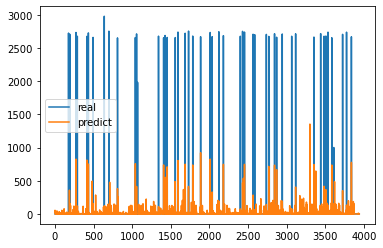

Epoch: 10; Test MAE loss on source data is: 35.438
Epoch: 10; Test MSE loss on source data is: 29096.943


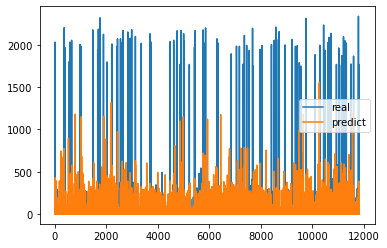

Epoch: 10; MSE loss: 8540368.000
37.24991648251293
76458.73125828002
Epoch: 11; MSE loss: 8817610.000
37.20649062479085
66240.74438145028
Epoch: 12; MSE loss: 8848870.000
37.1692556140877
75156.9549707371
Epoch: 13; MSE loss: 7958884.500
36.40216912074573
83281.94887788763
Epoch: 14; MSE loss: 8551785.000
36.58406258080506
83324.57023957637
Epoch: 15; MSE loss: 8052563.000
37.4341774557755
81475.26293140899
Epoch: 16; MSE loss: 8472378.000
37.246452307976874
84033.66415798692
Epoch: 17; MSE loss: 7497078.000
38.053481065091624
71744.55994352474
Epoch: 18; MSE loss: 8462668.000
36.895884314628354
74090.4846052378
Epoch: 19; MSE loss: 7753094.000
36.82480370430215
80406.78829444145
Epoch: 20; Test MAE loss on target data is: 36.825
Epoch: 20; Test MSE loss on target data is: 80406.788


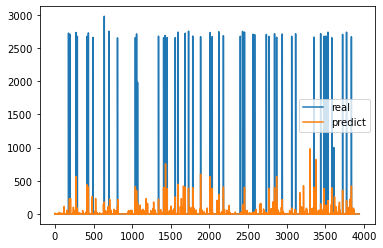

Epoch: 20; Test MAE loss on source data is: 27.785
Epoch: 20; Test MSE loss on source data is: 26525.773


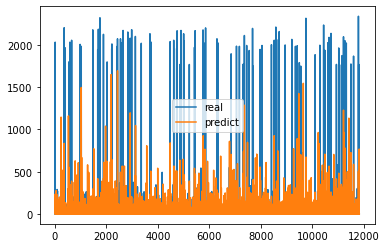

Epoch: 20; MSE loss: 7443072.000
37.51228926792409
66429.80950380302
Epoch: 21; MSE loss: 7445132.000
36.282322030217976
91120.6862499648
Epoch: 22; MSE loss: 7873323.000
36.39623533781914
83306.9357042701
Epoch: 23; MSE loss: 7017397.000
36.68242896921761
74360.45354598908
Epoch: 24; MSE loss: 7438711.000
36.77765406983841
79458.473947485
Epoch: 25; MSE loss: 7598193.500
36.955363117974485
85953.91329285727
Epoch: 26; MSE loss: 7755627.000
37.59749653720416
81207.09588056407
Epoch: 27; MSE loss: 7292668.500
37.31099273263777
82629.47844162349
Epoch: 28; MSE loss: 6696919.500
37.20220462390435
83115.43830510361
Epoch: 29; MSE loss: 7741914.500
36.5863790218914
79609.60601622217
Epoch: 30; Test MAE loss on target data is: 36.586
Epoch: 30; Test MSE loss on target data is: 79609.606


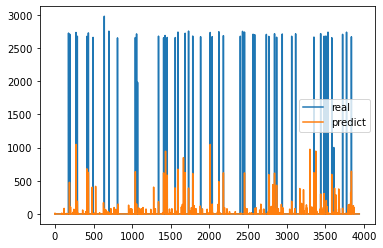

Epoch: 30; Test MAE loss on source data is: 25.535
Epoch: 30; Test MSE loss on source data is: 20902.568


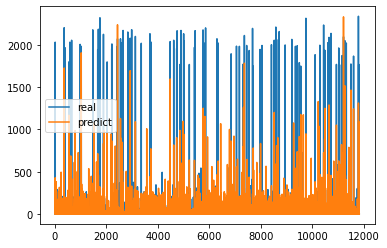

Epoch: 30; MSE loss: 6789278.000
36.828483880372815
86268.17520957373
Epoch: 31; MSE loss: 6665283.000
37.3397353596996
88671.87105595824
Epoch: 32; MSE loss: 7415647.500
36.04122347167595
73331.80138542752
Epoch: 33; MSE loss: 6236021.000
36.6663210031033
92285.93092092071
Epoch: 34; MSE loss: 6221630.500
36.26491366323153
80263.8147825558
Epoch: 35; MSE loss: 6730551.500
36.57337003309321
85048.64304741095
Epoch: 36; MSE loss: 5909960.000
36.05538610039573
84301.25177445644
Epoch: 37; MSE loss: 6198862.500
36.990220816634704
79400.26832977762
Epoch: 38; MSE loss: 5788606.000
37.109585912031214
79538.97834429314
Epoch: 39; MSE loss: 5951941.500
36.944578943479016
92306.5378104239
Epoch: 40; Test MAE loss on target data is: 36.945
Epoch: 40; Test MSE loss on target data is: 92306.538


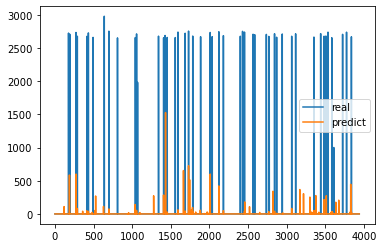

Epoch: 40; Test MAE loss on source data is: 18.696
Epoch: 40; Test MSE loss on source data is: 18976.300


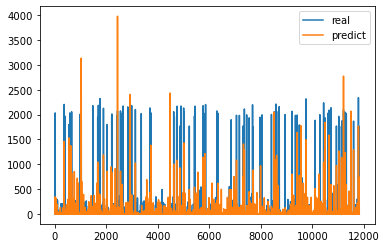

Epoch: 40; MSE loss: 6125754.500
36.90027483079053
88608.3428195769
Epoch: 41; MSE loss: 5630465.000
37.068140236554804
82889.93346910956
Epoch: 42; MSE loss: 6015977.500
35.74422993724906
81044.73000700158
Epoch: 43; MSE loss: 5361347.000
37.09324936855467
93285.2304268581
Epoch: 44; MSE loss: 5085014.500
38.82656147660644
91530.13737264747
Epoch: 45; MSE loss: 5273156.000
35.93799263440185
77229.10092188972
Epoch: 46; MSE loss: 5510939.000
37.32396180992913
81795.48612105308
Epoch: 47; MSE loss: 4614783.500
39.24095949131069
97765.4374173617
Epoch: 48; MSE loss: 5412905.000
36.87137911604421
76599.80607192128
Epoch: 49; MSE loss: 4902667.500
36.12075939406741
85358.45979172397
Epoch: 50; Test MAE loss on target data is: 36.121
Epoch: 50; Test MSE loss on target data is: 85358.460


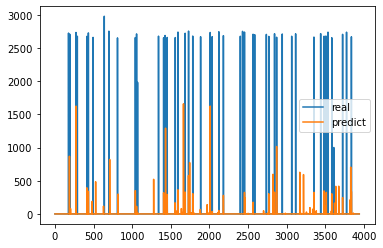

Epoch: 50; Test MAE loss on source data is: 18.897
Epoch: 50; Test MSE loss on source data is: 17600.444


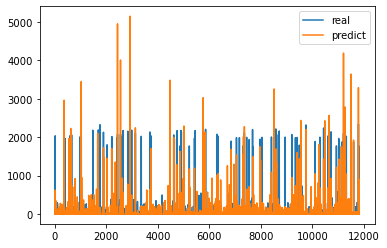

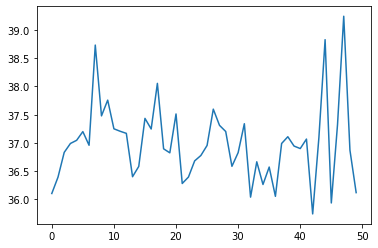

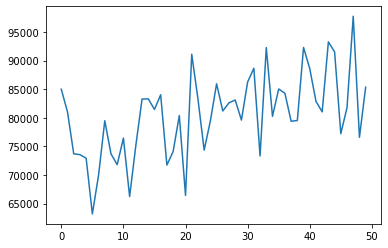

------------Domain Adaptation------------
Epoch: 0; MSE loss: 4931529.600
Epoch: 0; disc loss: 3676617.330
Epoch: 0; ceod loss: 5862.982
36.257129110399056
87148.09734451602
Parameter containing:
tensor([0.3336, 0.3346, 0.3318], device='cuda:0', requires_grad=True)
Epoch: 1; MSE loss: 5341145.069
Epoch: 1; disc loss: 3445169.196
Epoch: 1; ceod loss: 6243.701
37.583085479501044
92846.6201279948
Parameter containing:
tensor([0.3282, 0.3377, 0.3341], device='cuda:0', requires_grad=True)
Epoch: 2; MSE loss: 5306398.581
Epoch: 2; disc loss: 3316200.241
Epoch: 2; ceod loss: 6308.906
36.99720059559952
94976.22236096367
Parameter containing:
tensor([0.3260, 0.3380, 0.3360], device='cuda:0', requires_grad=True)
Epoch: 3; MSE loss: 5138730.900
Epoch: 3; disc loss: 3214700.661
Epoch: 3; ceod loss: 5887.450
36.746621046737395
96394.29716683847
Parameter containing:
tensor([0.3260, 0.3338, 0.3401], device='cuda:0', requires_grad=True)
Epoch: 4; MSE loss: 4876539.664
Epoch: 4; disc loss: 2964691.637

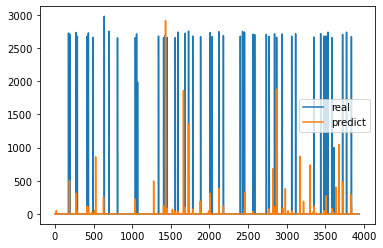

Epoch: 9; Test MAE loss on source data is: 20.653


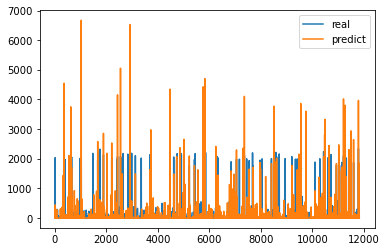

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


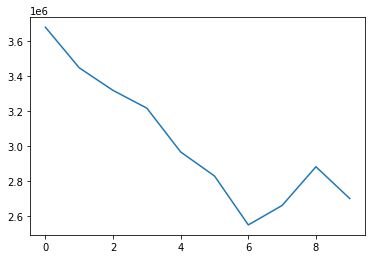

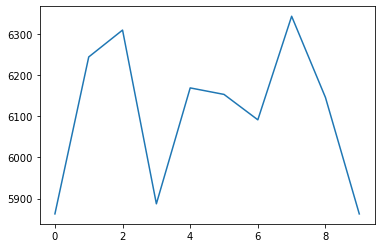

-------------------------- total running losses in 10 epoches as follows---------------------------------


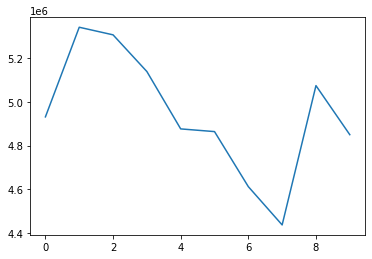

Epoch: 10; MSE loss: 4990006.958
Epoch: 10; disc loss: 2512415.066
Epoch: 10; ceod loss: 6174.289
37.42037153723961
96918.20738014964
Parameter containing:
tensor([0.3062, 0.3422, 0.3516], device='cuda:0', requires_grad=True)
Epoch: 11; MSE loss: 4643940.985
Epoch: 11; disc loss: 2697326.863
Epoch: 11; ceod loss: 6360.493
39.027805951084666
99577.82310554135
Parameter containing:
tensor([0.3049, 0.3423, 0.3528], device='cuda:0', requires_grad=True)
Epoch: 12; MSE loss: 5129037.490
Epoch: 12; disc loss: 2505383.088
Epoch: 12; ceod loss: 6298.823
36.33352025508235
94966.31060378053
Parameter containing:
tensor([0.3047, 0.3380, 0.3573], device='cuda:0', requires_grad=True)
Epoch: 13; MSE loss: 5082327.035
Epoch: 13; disc loss: 2219805.332
Epoch: 13; ceod loss: 6354.070
37.99745313308368
96598.92504940965
Parameter containing:
tensor([0.2968, 0.3425, 0.3607], device='cuda:0', requires_grad=True)
Epoch: 14; MSE loss: 4720084.605
Epoch: 14; disc loss: 2349021.568
Epoch: 14; ceod loss: 6388.8

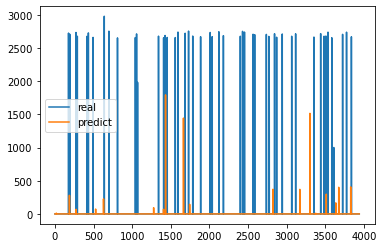

Epoch: 19; Test MAE loss on source data is: 13.973


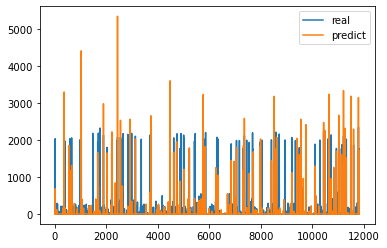

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


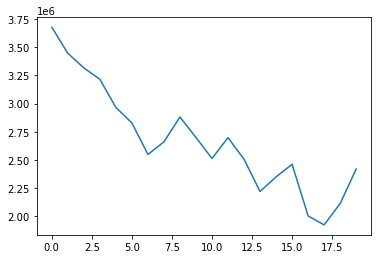

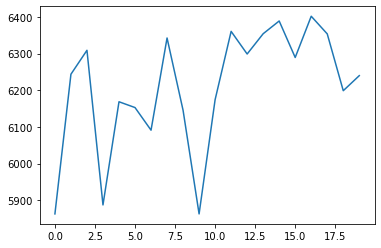

-------------------------- total running losses in 10 epoches as follows---------------------------------


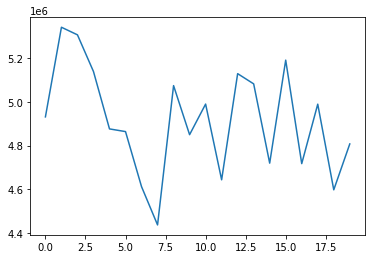

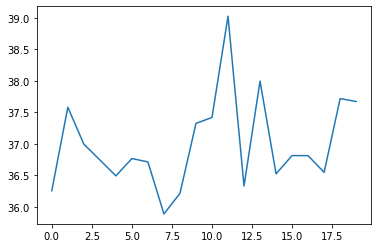

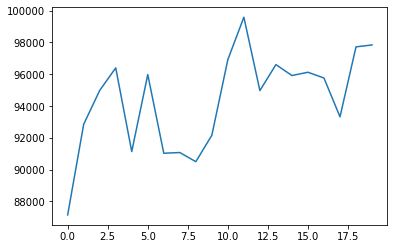

37.674239987368345
0.9449401258023876
1.0111959458595152
Parameter containing:
tensor([0.2705, 0.3432, 0.3863], device='cuda:0', requires_grad=True)

---------------------------------------------- domain num 1 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 13206530.000
28.70171691877264
43556.59807127196
Epoch: 1; MSE loss: 13042565.000
29.99526100910527
41693.78813012666
Epoch: 2; MSE loss: 13366425.000
31.20878443564625
39811.155150801445
Epoch: 3; MSE loss: 12132179.000
34.49271611087412
36923.531021641786
Epoch: 4; MSE loss: 12390077.000
33.210911918814354
37480.22709028575
Epoch: 5; MSE loss: 12107690.000
34.450100157482694
36682.169261506424
Epoch: 6; MSE loss: 13070698.000
35.29184498552652
35793.73619769856
Epoch: 7; MSE loss: 12053323.000
34.25339088552277
36184.96223558398
Epoch: 8; MSE loss: 11929983.000
35.47627678062541
36466.39042239663
Epoch: 9; MSE loss: 11755577.000
33.96388734739999
36373.42936156341
Epoch: 10; Te

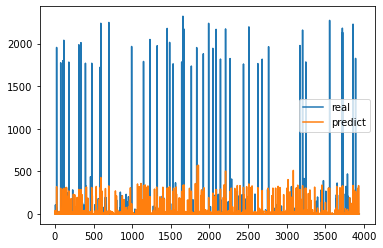

Epoch: 10; Test MAE loss on source data is: 39.689
Epoch: 10; Test MSE loss on source data is: 37140.781


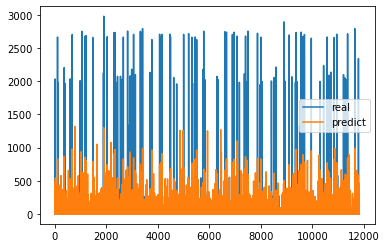

Epoch: 10; MSE loss: 11379720.000
34.409706523340404
36354.245756932105
Epoch: 11; MSE loss: 11545914.000
33.196919990465496
37469.17258211598
Epoch: 12; MSE loss: 11510656.000
34.27171490298794
36053.146108085966
Epoch: 13; MSE loss: 10926430.000
33.2792994760769
36883.31184103355
Epoch: 14; MSE loss: 10724409.000
32.0717322468924
38446.594998804576
Epoch: 15; MSE loss: 10356920.000
33.19865376491594
36590.3579783809
Epoch: 16; MSE loss: 10617476.000
33.02869739391825
36869.76845434096
Epoch: 17; MSE loss: 10196345.000
33.12142711513329
36874.33614058684
Epoch: 18; MSE loss: 9471405.000
31.757709468872044
37597.993283421885
Epoch: 19; MSE loss: 9494645.000
32.58811805687563
37242.9425143093
Epoch: 20; Test MAE loss on target data is: 32.588
Epoch: 20; Test MSE loss on target data is: 37242.943


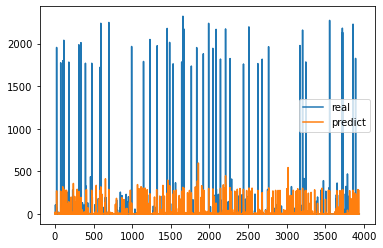

Epoch: 20; Test MAE loss on source data is: 35.251
Epoch: 20; Test MSE loss on source data is: 34813.301


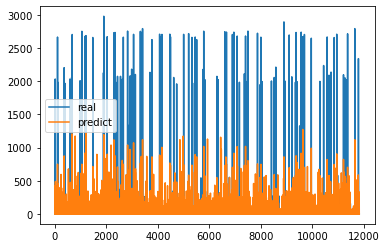

Epoch: 20; MSE loss: 10280495.000
29.99535553294393
38989.665538093286
Epoch: 21; MSE loss: 9658641.000
32.607104000770384
36723.54162223712
Epoch: 22; MSE loss: 10389212.000
33.81733435682198
35470.26767373528
Epoch: 23; MSE loss: 10037973.000
31.647712344987628
37656.34371102215
Epoch: 24; MSE loss: 9238245.000
30.742252079322387
38806.515166120604
Epoch: 25; MSE loss: 9564933.000
33.73836310875579
35209.34272948888
Epoch: 26; MSE loss: 9610683.000
31.95676985302119
37105.65457824152
Epoch: 27; MSE loss: 9622194.000
32.011992232518146
37093.796279116425
Epoch: 28; MSE loss: 9389752.000
31.318074947200852
37587.64099061363
Epoch: 29; MSE loss: 9400180.000
31.016562575676197
39198.22251576605
Epoch: 30; Test MAE loss on target data is: 31.017
Epoch: 30; Test MSE loss on target data is: 39198.223


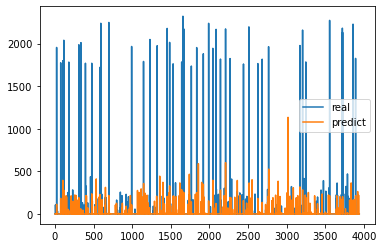

Epoch: 30; Test MAE loss on source data is: 29.213
Epoch: 30; Test MSE loss on source data is: 32501.612


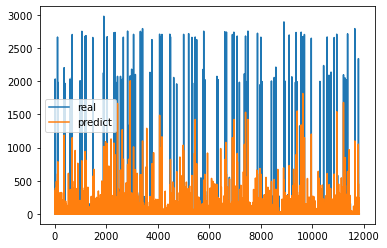

Epoch: 30; MSE loss: 8310903.500
30.59400379257142
38828.75433885606
Epoch: 31; MSE loss: 9024479.000
32.378367460506034
36153.08699860028
Epoch: 32; MSE loss: 9172974.000
32.39498655559659
35934.15391512703
Epoch: 33; MSE loss: 8774152.000
30.903312727597214
37537.04186266298
Epoch: 34; MSE loss: 9114207.000
30.780072278569296
37571.02993883945
Epoch: 35; MSE loss: 8629987.000
30.47844738552365
37879.11800283428
Epoch: 36; MSE loss: 8308107.000
29.75703374079205
37814.98735524449
Epoch: 37; MSE loss: 8438816.000
32.04357787739865
37187.40836652677
Epoch: 38; MSE loss: 8597543.000
31.425949041657688
37792.6946555924
Epoch: 39; MSE loss: 8993006.000
31.378136411320586
36178.54093575612
Epoch: 40; Test MAE loss on target data is: 31.378
Epoch: 40; Test MSE loss on target data is: 36178.541


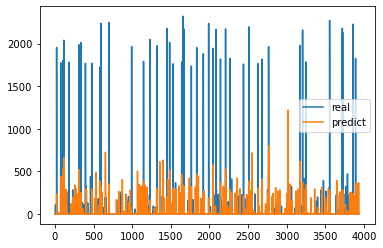

Epoch: 40; Test MAE loss on source data is: 29.930
Epoch: 40; Test MSE loss on source data is: 27362.700


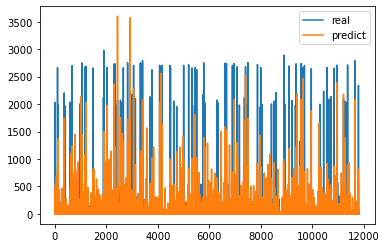

Epoch: 40; MSE loss: 8268386.000
28.95784789503029
39056.80300660552
Epoch: 41; MSE loss: 7907894.500
29.3631492382536
39504.744001852385
Epoch: 42; MSE loss: 7678003.000
29.55473405863845
39355.23855797563
Epoch: 43; MSE loss: 8420500.000
28.937121890940904
39325.564867727335
Epoch: 44; MSE loss: 7509032.500
29.86873869156662
36138.42672266469
Epoch: 45; MSE loss: 7185370.500
29.737314631985214
36642.96923376984
Epoch: 46; MSE loss: 8025954.500
29.00729008287804
37879.493947782525
Epoch: 47; MSE loss: 7733107.000
29.14656980219634
35932.27637125258
Epoch: 48; MSE loss: 6918183.000
30.054566325148603
34842.700490460935
Epoch: 49; MSE loss: 6959699.500
29.078513982089696
36295.48439697956
Epoch: 50; Test MAE loss on target data is: 29.079
Epoch: 50; Test MSE loss on target data is: 36295.484


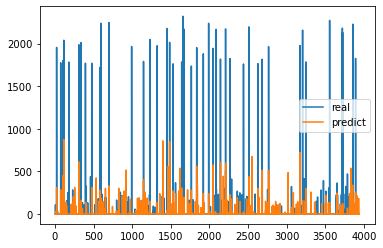

Epoch: 50; Test MAE loss on source data is: 23.706
Epoch: 50; Test MSE loss on source data is: 26323.679


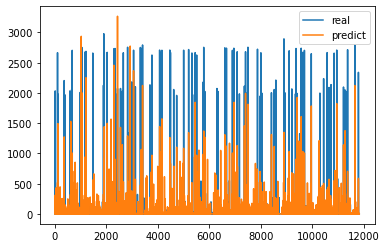

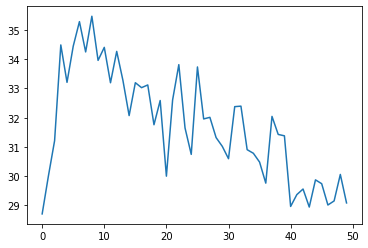

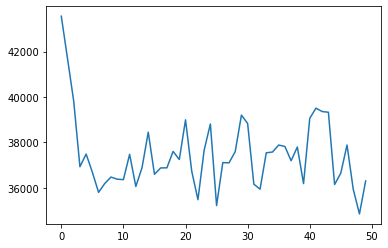

------------Domain Adaptation------------
Epoch: 0; MSE loss: 7078023.494
Epoch: 0; disc loss: 4872352.739
Epoch: 0; ceod loss: 5153.744
27.406586672018943
39744.50580423421
Parameter containing:
tensor([0.3412, 0.3272, 0.3315], device='cuda:0', requires_grad=True)
Epoch: 1; MSE loss: 7563247.441
Epoch: 1; disc loss: 4124710.908
Epoch: 1; ceod loss: 4899.434
27.939193665028466
37875.962307470974
Parameter containing:
tensor([0.3485, 0.3239, 0.3276], device='cuda:0', requires_grad=True)
Epoch: 2; MSE loss: 7451751.166
Epoch: 2; disc loss: 3753914.177
Epoch: 2; ceod loss: 4655.923
27.560428727674353
36753.31836458119
Parameter containing:
tensor([0.3611, 0.3165, 0.3224], device='cuda:0', requires_grad=True)
Epoch: 3; MSE loss: 6537094.242
Epoch: 3; disc loss: 3696357.592
Epoch: 3; ceod loss: 4025.923
27.715376021020518
39026.24642848925
Parameter containing:
tensor([0.3786, 0.3073, 0.3141], device='cuda:0', requires_grad=True)
Epoch: 4; MSE loss: 5996354.401
Epoch: 4; disc loss: 3276782.

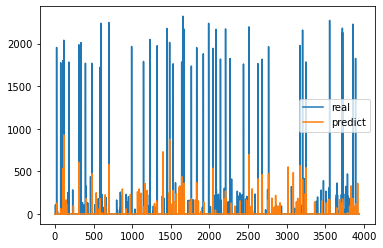

Epoch: 9; Test MAE loss on source data is: 19.876


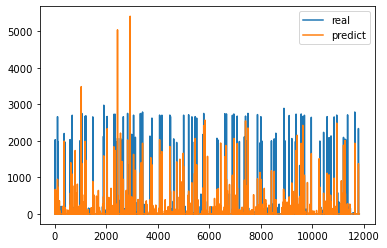

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


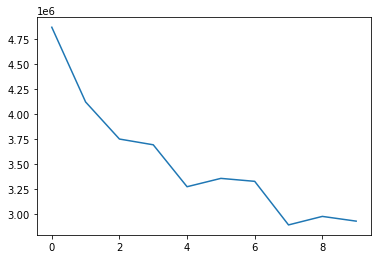

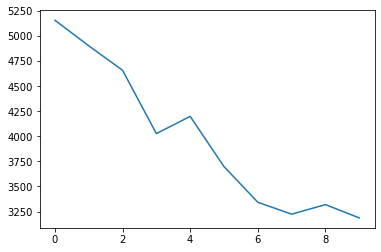

-------------------------- total running losses in 10 epoches as follows---------------------------------


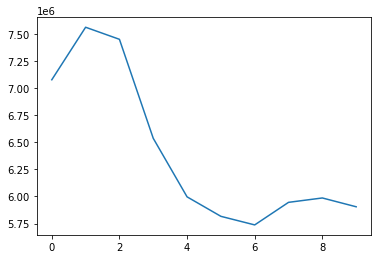

Epoch: 10; MSE loss: 5665115.482
Epoch: 10; disc loss: 2384538.778
Epoch: 10; ceod loss: 3178.917
28.070221228092585
39492.49078564718
Parameter containing:
tensor([0.5181, 0.2356, 0.2463], device='cuda:0', requires_grad=True)
Epoch: 11; MSE loss: 5698505.453
Epoch: 11; disc loss: 2148051.979
Epoch: 11; ceod loss: 2957.179
28.072603242102687
38419.842904707955
Parameter containing:
tensor([0.5510, 0.2165, 0.2325], device='cuda:0', requires_grad=True)
Epoch: 12; MSE loss: 5156699.946
Epoch: 12; disc loss: 1951275.015
Epoch: 12; ceod loss: 2925.667
25.574331133415843
35009.825039795556
Parameter containing:
tensor([0.5847, 0.1986, 0.2167], device='cuda:0', requires_grad=True)
Epoch: 13; MSE loss: 4964990.800
Epoch: 13; disc loss: 1631883.044
Epoch: 13; ceod loss: 2866.872
26.3285351930249
36997.0395780608
Parameter containing:
tensor([0.6242, 0.1791, 0.1967], device='cuda:0', requires_grad=True)
Epoch: 14; MSE loss: 4576889.772
Epoch: 14; disc loss: 1527419.538
Epoch: 14; ceod loss: 2758

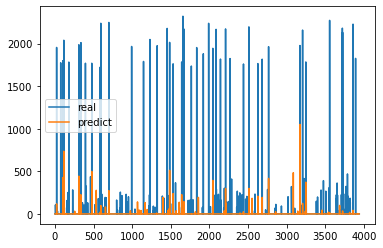

Epoch: 19; Test MAE loss on source data is: 18.453


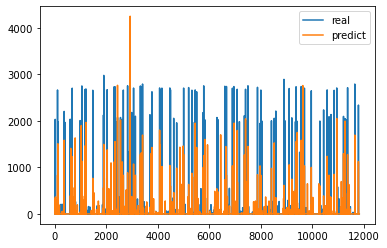

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


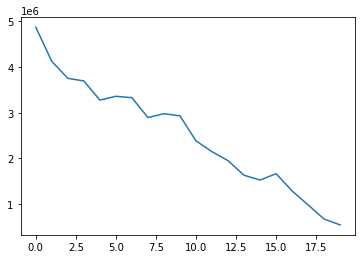

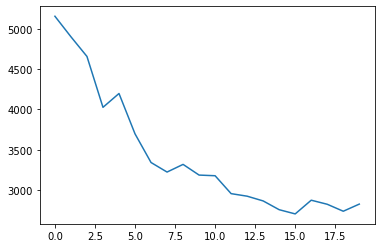

-------------------------- total running losses in 10 epoches as follows---------------------------------


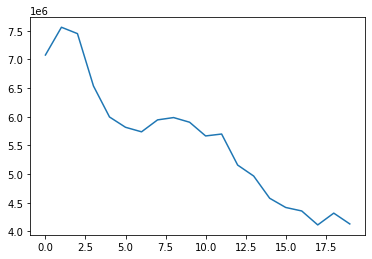

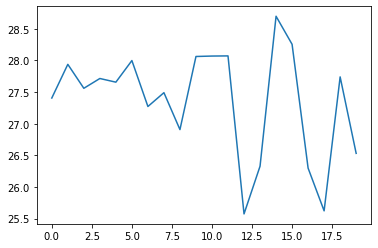

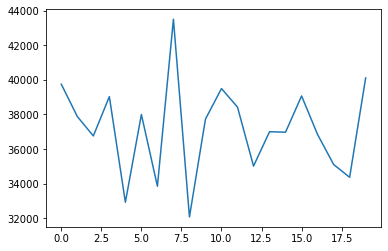

26.531925870089083
0.905177834758777
0.9330962534857431
Parameter containing:
tensor([0.9333, 0.0333, 0.0333], device='cuda:0', requires_grad=True)

---------------------------------------------- domain num 2 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 16807888.000
22.72219231546273
25111.24722337196
Epoch: 1; MSE loss: 15813080.000
27.8517980459672
24631.41907926219
Epoch: 2; MSE loss: 13324286.000
31.892261888679666
24674.29103515111
Epoch: 3; MSE loss: 15099714.000
37.263464725083146
25866.70757393692
Epoch: 4; MSE loss: 13179197.000
43.51774802696989
28104.18786960339
Epoch: 5; MSE loss: 12967945.000
48.541814894945496
31272.353566078342
Epoch: 6; MSE loss: 12819197.000
53.940815822293885
34636.10095193668
Epoch: 7; MSE loss: 12098956.000
58.080480596150345
38162.09278312588
Epoch: 8; MSE loss: 12242125.000
49.52066554168919
33238.04491094271
Epoch: 9; MSE loss: 12592471.000
52.84987528222681
35583.842189428506
Epoch: 10; Te

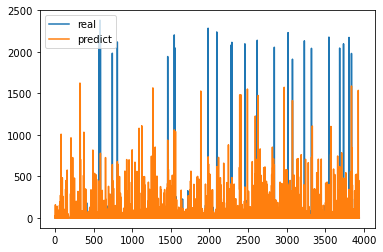

Epoch: 10; Test MAE loss on source data is: 39.444
Epoch: 10; Test MSE loss on source data is: 37976.106


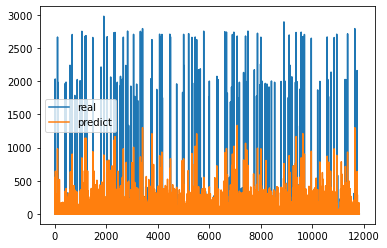

Epoch: 10; MSE loss: 11995823.000
38.94724012624337
27599.276340048677
Epoch: 11; MSE loss: 11927506.000
52.40826422969185
36456.52017387263
Epoch: 12; MSE loss: 12042416.000
44.31780812157135
30577.4650161242
Epoch: 13; MSE loss: 10957206.000
47.62017531109942
33839.655866305555
Epoch: 14; MSE loss: 11784776.000
52.43263521956871
38119.21494577129
Epoch: 15; MSE loss: 11802998.000
43.562329155491014
32446.57129266619
Epoch: 16; MSE loss: 10814175.000
51.880129270311336
39015.613331467
Epoch: 17; MSE loss: 10622159.000
39.195084270942495
30645.402453725
Epoch: 18; MSE loss: 10583685.000
37.079926402603675
29508.068288349838
Epoch: 19; MSE loss: 10925729.000
31.289208727692383
27544.590140565353
Epoch: 20; Test MAE loss on target data is: 31.289
Epoch: 20; Test MSE loss on target data is: 27544.590


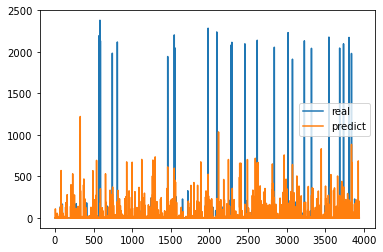

Epoch: 20; Test MAE loss on source data is: 30.399
Epoch: 20; Test MSE loss on source data is: 44116.740


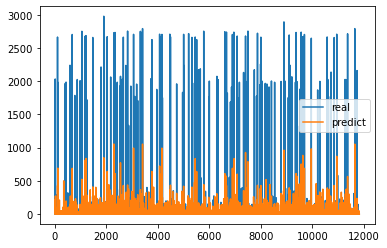

Epoch: 20; MSE loss: 11091459.000
53.645563898118915
43824.9608240177
Epoch: 21; MSE loss: 10211499.000
36.41771470917735
30625.91997722897
Epoch: 22; MSE loss: 10150372.000
42.205430070781006
34879.97529002329
Epoch: 23; MSE loss: 10444849.000
40.463324660287384
32861.01598358356
Epoch: 24; MSE loss: 10297253.000
35.743147164870564
31374.251774049906
Epoch: 25; MSE loss: 10142639.000
49.84852528010973
44055.96035378462
Epoch: 26; MSE loss: 10380317.000
53.23323030309292
47089.98874969298
Epoch: 27; MSE loss: 9647276.000
31.484985255962155
30150.174420350366
Epoch: 28; MSE loss: 9492905.000
30.012207996044417
29683.990948049395
Epoch: 29; MSE loss: 9252955.000
47.529817959608025
43356.109644098084
Epoch: 30; Test MAE loss on target data is: 47.530
Epoch: 30; Test MSE loss on target data is: 43356.110


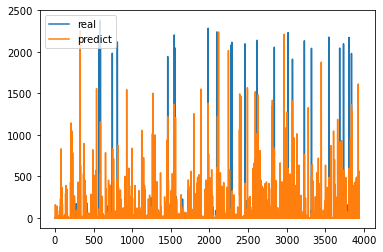

Epoch: 30; Test MAE loss on source data is: 29.650
Epoch: 30; Test MSE loss on source data is: 27953.499


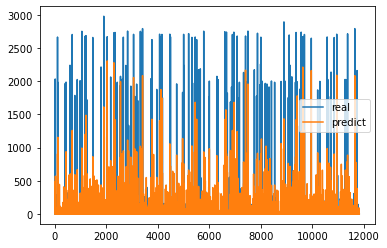

Epoch: 30; MSE loss: 9734772.000
35.97532892099373
30108.960758086596
Epoch: 31; MSE loss: 9693704.000
39.91996126311347
36371.10248057556
Epoch: 32; MSE loss: 9565202.000
31.175802604207167
29357.422252315468
Epoch: 33; MSE loss: 9183308.000
45.759237122729296
43008.47360602698
Epoch: 34; MSE loss: 8903064.000
36.06859224250522
35892.487120334736
Epoch: 35; MSE loss: 8801664.000
30.856759538129634
31062.72848133693
Epoch: 36; MSE loss: 8079940.500
47.19900502003985
53505.05562317026
Epoch: 37; MSE loss: 7383866.500
39.95727932496638
34021.04351024842
Epoch: 38; MSE loss: 8346364.000
30.46638548968937
32922.42120485175
Epoch: 39; MSE loss: 7857568.500
48.27904977947587
51298.54128334045
Epoch: 40; Test MAE loss on target data is: 48.279
Epoch: 40; Test MSE loss on target data is: 51298.541


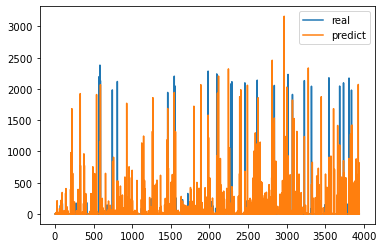

Epoch: 40; Test MAE loss on source data is: 27.396
Epoch: 40; Test MSE loss on source data is: 24017.626


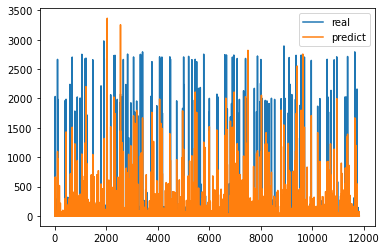

Epoch: 40; MSE loss: 7361740.000
29.107923191680698
30759.943886434918
Epoch: 41; MSE loss: 7675869.000
35.34800917510604
36929.62527865914
Epoch: 42; MSE loss: 6946237.000
36.95279745084929
40371.617431176885
Epoch: 43; MSE loss: 7188228.000
39.253154213341986
42734.98957562981
Epoch: 44; MSE loss: 6781055.000
35.76621887230746
42387.164564058716
Epoch: 45; MSE loss: 6880058.000
42.77367277285739
51106.09242465353
Epoch: 46; MSE loss: 6446891.500
46.185398802679224
61669.56526830962
Epoch: 47; MSE loss: 6534016.500
35.78006152839293
43249.91241822744
Epoch: 48; MSE loss: 6264864.500
35.968325181831354
42846.44543347861
Epoch: 49; MSE loss: 6570249.000
29.314356508245325
36329.83025102078
Epoch: 50; Test MAE loss on target data is: 29.314
Epoch: 50; Test MSE loss on target data is: 36329.830


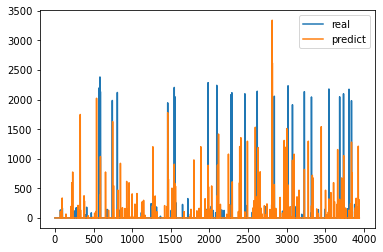

Epoch: 50; Test MAE loss on source data is: 22.251
Epoch: 50; Test MSE loss on source data is: 32068.161


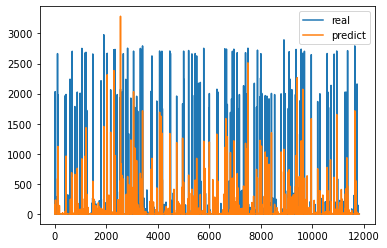

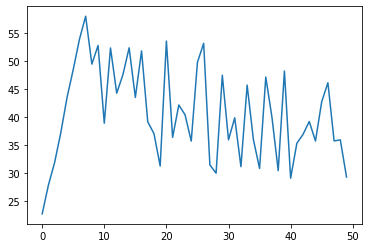

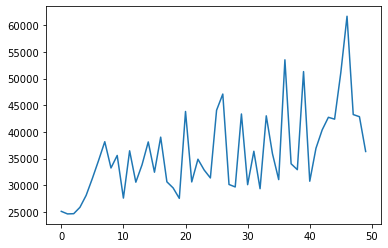

------------Domain Adaptation------------
Epoch: 0; MSE loss: 7258948.485
Epoch: 0; disc loss: 6764370.357
Epoch: 0; ceod loss: 3923.535
46.97247101883769
60936.0087845738
Parameter containing:
tensor([0.3334, 0.3329, 0.3338], device='cuda:0', requires_grad=True)
Epoch: 1; MSE loss: 6217543.201
Epoch: 1; disc loss: 6528793.513
Epoch: 1; ceod loss: 3829.313
32.16882887769248
32212.877501953633
Parameter containing:
tensor([0.3353, 0.3345, 0.3302], device='cuda:0', requires_grad=True)
Epoch: 2; MSE loss: 6832844.178
Epoch: 2; disc loss: 5601564.212
Epoch: 2; ceod loss: 3689.604
36.032821937741375
46267.13796830427
Parameter containing:
tensor([0.3375, 0.3348, 0.3276], device='cuda:0', requires_grad=True)
Epoch: 3; MSE loss: 6379152.668
Epoch: 3; disc loss: 5132465.790
Epoch: 3; ceod loss: 3750.792
29.005793833363573
30681.17997005627
Parameter containing:
tensor([0.3427, 0.3316, 0.3257], device='cuda:0', requires_grad=True)
Epoch: 4; MSE loss: 6162355.757
Epoch: 4; disc loss: 4361870.241

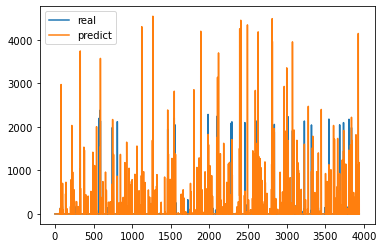

Epoch: 9; Test MAE loss on source data is: 25.100


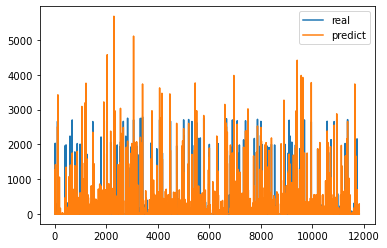

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


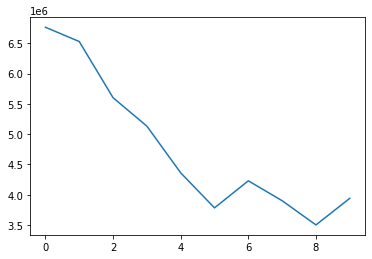

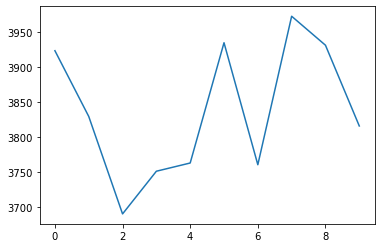

-------------------------- total running losses in 10 epoches as follows---------------------------------


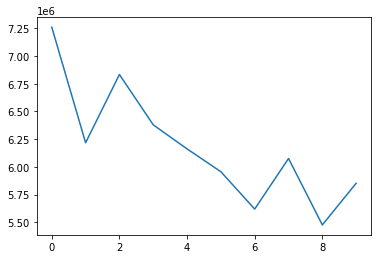

Epoch: 10; MSE loss: 5846809.858
Epoch: 10; disc loss: 3348798.997
Epoch: 10; ceod loss: 3792.259
45.835089403204854
75037.73530304573
Parameter containing:
tensor([0.4203, 0.3246, 0.2551], device='cuda:0', requires_grad=True)
Epoch: 11; MSE loss: 5245433.333
Epoch: 11; disc loss: 3451662.900
Epoch: 11; ceod loss: 3721.247
26.368540321924577
32260.698618797374
Parameter containing:
tensor([0.4424, 0.3205, 0.2371], device='cuda:0', requires_grad=True)
Epoch: 12; MSE loss: 5816403.345
Epoch: 12; disc loss: 2808221.182
Epoch: 12; ceod loss: 3897.373
42.162167466312944
52141.43368360037
Parameter containing:
tensor([0.4664, 0.3160, 0.2176], device='cuda:0', requires_grad=True)
Epoch: 13; MSE loss: 5040657.363
Epoch: 13; disc loss: 2956963.358
Epoch: 13; ceod loss: 3620.265
27.9582358851284
36942.386502370515
Parameter containing:
tensor([0.4960, 0.3088, 0.1952], device='cuda:0', requires_grad=True)
Epoch: 14; MSE loss: 4830528.499
Epoch: 14; disc loss: 2305411.901
Epoch: 14; ceod loss: 379

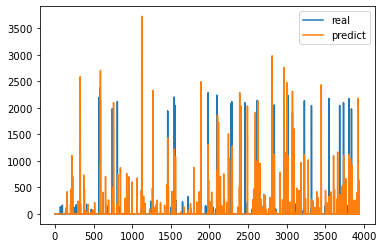

Epoch: 19; Test MAE loss on source data is: 18.412


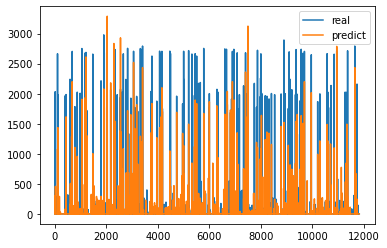

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


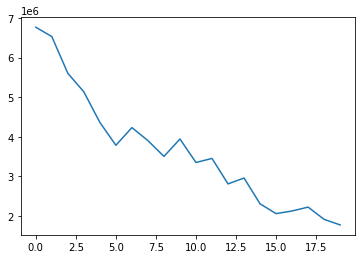

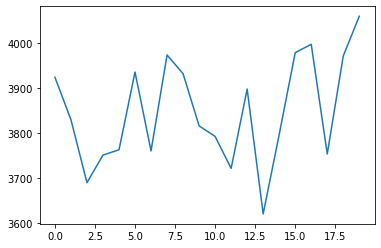

-------------------------- total running losses in 10 epoches as follows---------------------------------


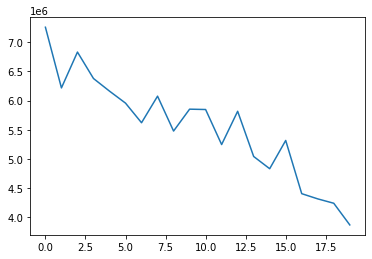

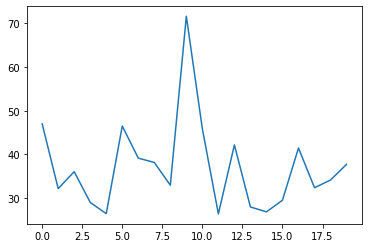

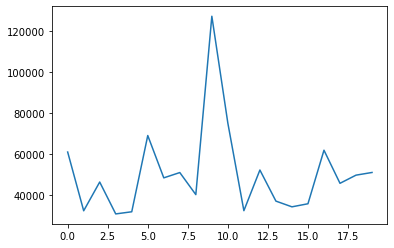

37.72051267870729
1.139813868236266
1.353440686079178
Parameter containing:
tensor([0.7204, 0.2462, 0.0333], device='cuda:0', requires_grad=True)

---------------------------------------------- domain num 3 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 15562815.000
21.25900374739841
29060.68989484525
Epoch: 1; MSE loss: 13516562.000
25.02493706691478
27764.357317705468
Epoch: 2; MSE loss: 14265070.000
28.460575331710476
27007.855875424015
Epoch: 3; MSE loss: 12338212.000
33.243951715104544
26726.330688573584
Epoch: 4; MSE loss: 12139443.000
34.7329511774727
26418.017337363937
Epoch: 5; MSE loss: 12709834.000
36.73257126440421
26364.341934591506
Epoch: 6; MSE loss: 12418249.000
38.76578197180204
27012.023007253723
Epoch: 7; MSE loss: 11538165.000
35.19566844716437
26954.38657752918
Epoch: 8; MSE loss: 11919076.000
37.8128085962651
26615.04395952722
Epoch: 9; MSE loss: 12224020.000
37.34535565599232
26103.69969909742
Epoch: 10; Test

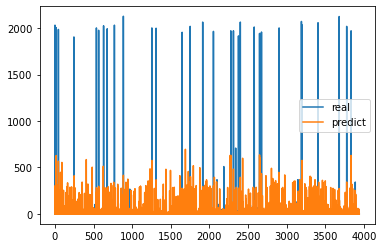

Epoch: 10; Test MAE loss on source data is: 38.180
Epoch: 10; Test MSE loss on source data is: 40337.669


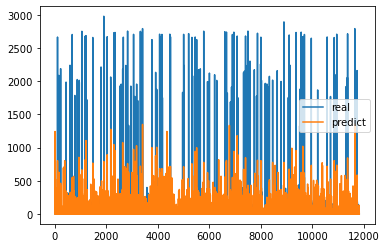

Epoch: 10; MSE loss: 10280727.000
35.05467648949948
26568.41489308655
Epoch: 11; MSE loss: 11395296.000
35.754763671606064
26539.591585567883
Epoch: 12; MSE loss: 10846340.000
35.53479291446104
26676.798189971356
Epoch: 13; MSE loss: 10956518.000
33.1759689723025
26820.003894116137
Epoch: 14; MSE loss: 10250533.000
33.45172951234549
27168.724425458717
Epoch: 15; MSE loss: 9946519.000
30.927716645649173
27160.707976121324
Epoch: 16; MSE loss: 9832166.000
35.18008192902135
26554.167275531
Epoch: 17; MSE loss: 10177772.000
29.02071228514023
26804.93187503017
Epoch: 18; MSE loss: 9009998.000
31.242771633164104
27344.117000414673
Epoch: 19; MSE loss: 8979636.000
35.23581857933925
27500.906258813957
Epoch: 20; Test MAE loss on target data is: 35.236
Epoch: 20; Test MSE loss on target data is: 27500.906


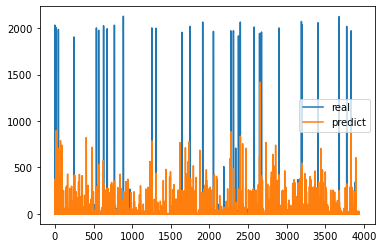

Epoch: 20; Test MAE loss on source data is: 34.775
Epoch: 20; Test MSE loss on source data is: 34691.913


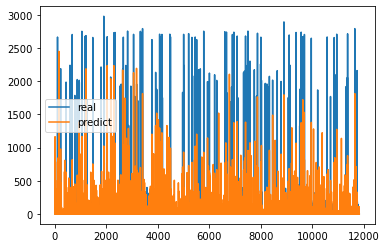

Epoch: 20; MSE loss: 9081623.000
34.55967802771024
27294.7189331163
Epoch: 21; MSE loss: 9400180.000
32.69647485734288
28370.6673606487
Epoch: 22; MSE loss: 9050181.000
26.140460743235394
28179.340239113815
Epoch: 23; MSE loss: 9076316.000
37.58646335832035
28398.385613492796
Epoch: 24; MSE loss: 8659531.000
25.49585225755163
28675.473113990734
Epoch: 25; MSE loss: 8378943.000
35.79010635784921
28755.82879592455
Epoch: 26; MSE loss: 8403860.000
24.731602791684498
29774.461596040714
Epoch: 27; MSE loss: 8288478.500
31.65658447845912
27874.06623756085
Epoch: 28; MSE loss: 7923321.000
27.97489307845752
30631.23469520265
Epoch: 29; MSE loss: 7630251.500
23.307382829706626
29337.916808881335
Epoch: 30; Test MAE loss on target data is: 23.307
Epoch: 30; Test MSE loss on target data is: 29337.917


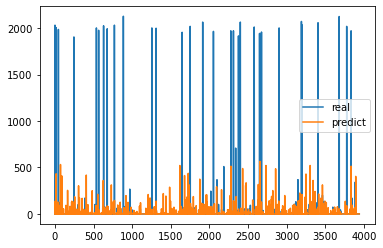

Epoch: 30; Test MAE loss on source data is: 25.420
Epoch: 30; Test MSE loss on source data is: 35581.331


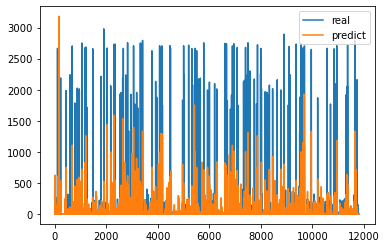

Epoch: 30; MSE loss: 7269474.500
26.738116522771215
28636.376617591806
Epoch: 31; MSE loss: 7466406.500
32.09008648239721
30649.50929869674
Epoch: 32; MSE loss: 7261177.000
29.735434465255874
28526.25826475655
Epoch: 33; MSE loss: 7041472.500
26.420932506779916
29157.511590615046
Epoch: 34; MSE loss: 6518558.500
25.977168134416733
29216.052947071945
Epoch: 35; MSE loss: 6789526.000
25.982180508236933
30055.791782629367
Epoch: 36; MSE loss: 5965907.000
32.03729293707345
30505.747517474872
Epoch: 37; MSE loss: 5778766.000
27.355113686172754
30277.159348404533
Epoch: 38; MSE loss: 5237849.000
36.440888104297215
31568.29281276317
Epoch: 39; MSE loss: 5671536.500
28.158129498063836
29598.209842483975
Epoch: 40; Test MAE loss on target data is: 28.158
Epoch: 40; Test MSE loss on target data is: 29598.210


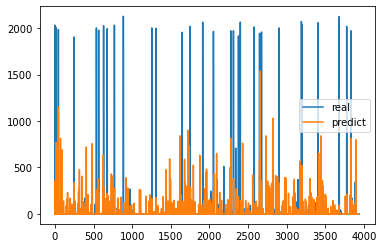

Epoch: 40; Test MAE loss on source data is: 22.793
Epoch: 40; Test MSE loss on source data is: 24794.981


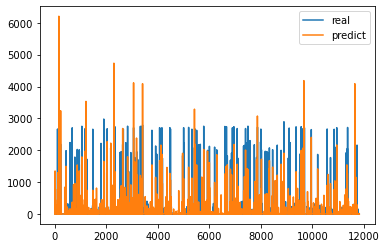

Epoch: 40; MSE loss: 4986735.500
27.16227062645826
32188.57075056452
Epoch: 41; MSE loss: 4970159.000
23.86045017149569
30037.981274378384
Epoch: 42; MSE loss: 5129520.500
25.424720642803223
29654.90208851332
Epoch: 43; MSE loss: 4971545.000
26.24244351773146
30364.71811875837
Epoch: 44; MSE loss: 5245174.000
23.881625527613842
29553.105515760242
Epoch: 45; MSE loss: 5025291.500
31.527178087049375
31014.1905512501
Epoch: 46; MSE loss: 4530249.000
25.087083534400676
30301.810976056524
Epoch: 47; MSE loss: 4696121.000
27.257309654405717
29640.818544862417
Epoch: 48; MSE loss: 4640686.000
28.427739798372333
30613.600891794318
Epoch: 49; MSE loss: 4088189.000
26.92865310813896
31293.40504357677
Epoch: 50; Test MAE loss on target data is: 26.929
Epoch: 50; Test MSE loss on target data is: 31293.405


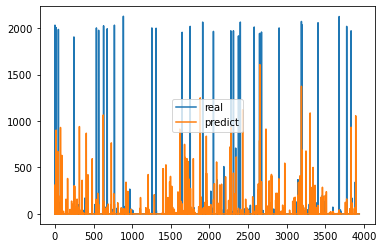

Epoch: 50; Test MAE loss on source data is: 20.420
Epoch: 50; Test MSE loss on source data is: 22300.008


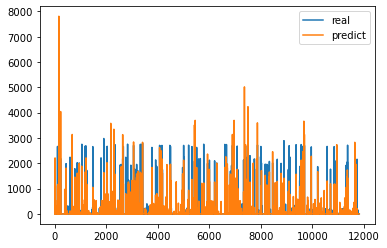

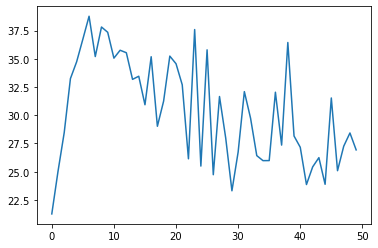

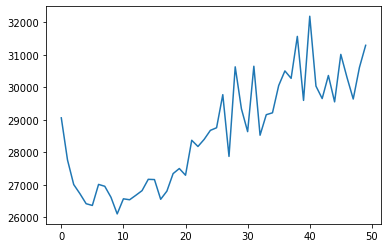

------------Domain Adaptation------------
Epoch: 0; MSE loss: 4723876.023
Epoch: 0; disc loss: 7423896.300
Epoch: 0; ceod loss: 2646.595
26.116402887721044
31661.395329162846
Parameter containing:
tensor([0.3369, 0.3296, 0.3336], device='cuda:0', requires_grad=True)
Epoch: 1; MSE loss: 4942321.287
Epoch: 1; disc loss: 6311875.440
Epoch: 1; ceod loss: 2686.985
20.135646697985464
31463.494994695728
Parameter containing:
tensor([0.3412, 0.3295, 0.3293], device='cuda:0', requires_grad=True)
Epoch: 2; MSE loss: 4966009.482
Epoch: 2; disc loss: 5862702.949
Epoch: 2; ceod loss: 2650.005
21.816891560288923
32509.160522087008
Parameter containing:
tensor([0.3436, 0.3291, 0.3272], device='cuda:0', requires_grad=True)
Epoch: 3; MSE loss: 5132588.796
Epoch: 3; disc loss: 5252670.855
Epoch: 3; ceod loss: 2474.938
19.867921770662562
30927.188217385283
Parameter containing:
tensor([0.3489, 0.3282, 0.3230], device='cuda:0', requires_grad=True)
Epoch: 4; MSE loss: 4346875.262
Epoch: 4; disc loss: 48870

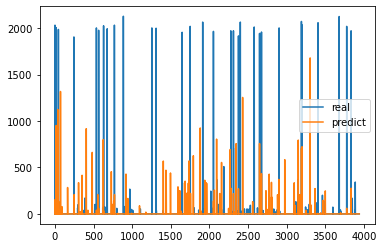

Epoch: 9; Test MAE loss on source data is: 15.911


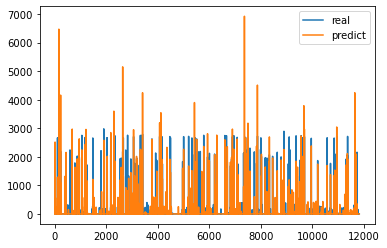

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


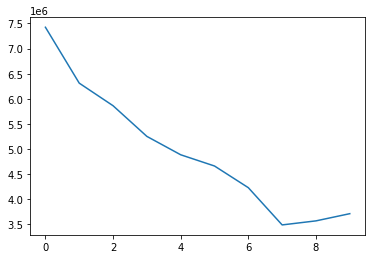

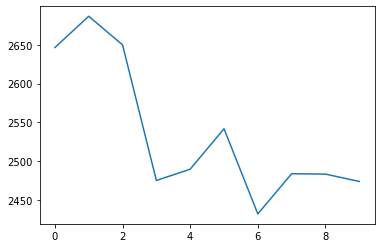

-------------------------- total running losses in 10 epoches as follows---------------------------------


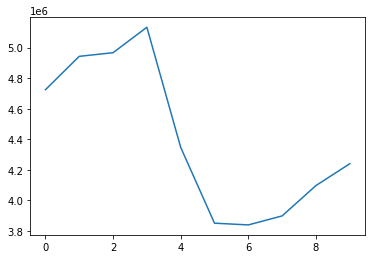

Epoch: 10; MSE loss: 3995946.057
Epoch: 10; disc loss: 3236679.240
Epoch: 10; ceod loss: 2414.630
20.085227128062506
30597.176105938477
Parameter containing:
tensor([0.4321, 0.3110, 0.2570], device='cuda:0', requires_grad=True)
Epoch: 11; MSE loss: 3783593.427
Epoch: 11; disc loss: 2771041.460
Epoch: 11; ceod loss: 2447.601
27.91636519972684
34472.96825063257
Parameter containing:
tensor([0.4504, 0.3058, 0.2438], device='cuda:0', requires_grad=True)
Epoch: 12; MSE loss: 4182932.449
Epoch: 12; disc loss: 2852056.600
Epoch: 12; ceod loss: 2364.421
24.04444110196909
30866.478307627545
Parameter containing:
tensor([0.4751, 0.2985, 0.2264], device='cuda:0', requires_grad=True)
Epoch: 13; MSE loss: 4372015.186
Epoch: 13; disc loss: 2305951.940
Epoch: 13; ceod loss: 2323.571
23.66158079865075
30630.4560997139
Parameter containing:
tensor([0.5050, 0.2856, 0.2095], device='cuda:0', requires_grad=True)
Epoch: 14; MSE loss: 4567648.359
Epoch: 14; disc loss: 2550977.172
Epoch: 14; ceod loss: 2404.

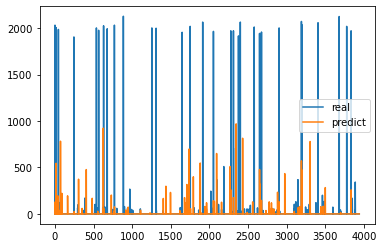

Epoch: 19; Test MAE loss on source data is: 18.394


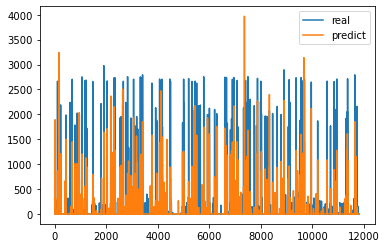

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


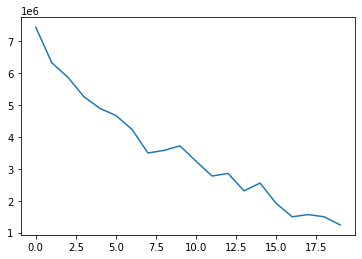

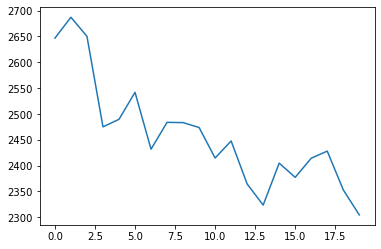

-------------------------- total running losses in 10 epoches as follows---------------------------------


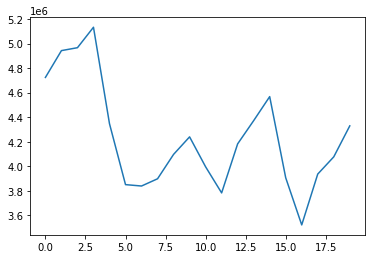

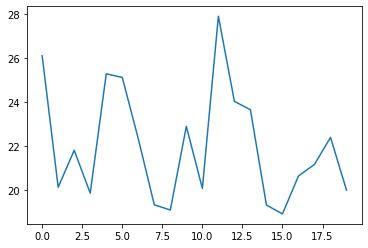

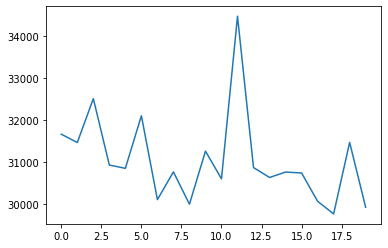

20.00213033903132
0.7368028893913082
0.9801359915147742
Parameter containing:
tensor([0.7684, 0.1982, 0.0333], device='cuda:0', requires_grad=True)


In [ ]:
import importlib
# import models.hdisc_msda 
# importlib.reload(models.hdisc_msda)
# from models.hdisc_msda import Disc_MSDANet
import matplotlib.pyplot as plt

#Number of experiments to launch
num_data_sets=len(fileList)
num_domains=num_data_sets-1
nb_experiments = 1

#-np.inf
params= {'input_dim': 19, 'output_dim': 1, 'n_sources': num_data_sets-1, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': 0, 'max_pred': np.inf}

#Number of epochs
epochs_pretrain, epochs_adapt =50,20

for exp in range(nb_experiments):
    print('\n ----------------------------- %i / %i -----------------------------'%(exp+1, nb_experiments))
    mse_list, mae_list =  {}, {}
    alphas = {}
    for i in range(num_data_sets):
        print('\n---------------------------------------------- domain num %i is running----------------------------------'%(i))
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        
        ############################# Build and define model ####################################
        params['feature_extractor'] = get_feature_extractor()
        params['h_pred'] = get_predictor(output_dim=1)
        params['h_disc'] = get_discriminator(num_domains, output_dim=1)
        model = Disc_MSDANet(params).to(device)

#         #Pre-training
        print('------------Pre-training------------')
        lr = 0.0001
        lr1=0.00001
        batch_size =64
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        mae_loss,mse_loss=[],[]
        for epoch in range(epochs_pretrain):
            running_loss=0.0
            model.train()
#             input_sizes = [data.shape[0] for data in source_insts]
#             max_input_size = max(input_sizes)
#             K=int(max_input_size/batch_size)
#             print('K value is:', K)

            loader = multi_data_loader(source_insts, source_labels, batch_size)
    
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_t = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                loss_pred = model.train_prediction(x_bs, x_t, y_bs, clip=1, pred_only=False)
#                 print("predictor is:", model.h_pred.weight.data) 
                running_loss+=loss_pred
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            model.eval()
            prediction=model.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            if (epoch+1)%10==0:
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()        
     
                
        print('------------Domain Adaptation------------')
        disc_losslist, ceod_losslist, loss_list=[],[],[]
        mae_loss,mse_loss=[],[]
        lr = 0.0001
        lr1=0.000001
        batch_size =64
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        
        for epoch in range(epochs_adapt):
            running_loss = 0.0
            discloss = 0.0
            ceodloss = 0.0
            model.train()
            loader = multi_data_loader(source_insts, source_labels, batch_size)
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_bt = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)

                #Train h to minimize source loss

            #stage 1
                for a in range(5):
                    disc_loss1 = model.train_disc(x_bs, x_bt, y_bs, clip=1)
                for b in range(1):
                    loss,source_loss,ceod_loss,disc_loss=model.train_all_feat(x_bs, x_bt, y_bs, clip=1)
#                     print("extractor is:", model.feature_extractor[5][0].weight) 
#                     print("discriminator is ", model.h_disc[0].weight.data)
#                     print("Hybrid loss is ", loss)
            #stage 2  
               # loss,source_loss,ceod_loss,disc_loss=model.train_all(x_bs, x_bt, y_bs, clip=1)
            #maximize discrepancy by opt_disc
#                 print("###############finish test########################")
                for c in range(1):
                    loss,source_loss,ceod_loss=model.train_all_pred(x_bs, x_bt, y_bs, clip=1)
                for d in range(2):
                    disc_loss=model.train_all_alpha(x_bs, x_bt, y_bs, clip=1)
#                     print("predictor is ", model.h_pred.weight.data)
                running_loss += loss.item()
                discloss += disc_loss.item()
                ceodloss+=ceod_loss.item()
            loss_list.append(running_loss)
            disc_losslist.append(discloss)
            ceod_losslist.append(ceodloss)
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            print('Epoch: %i; disc loss: %.3f'%(epoch, discloss))
            print('Epoch: %i; ceod loss: %.3f'%(epoch, ceodloss))
            model.eval()
#             print(X_t)
            prediction=model.predict(X_t).cpu().detach().numpy()
#             print(prediction)
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            print(model.alpha)
            if (epoch+1)%10==0:
                print('--------------------------results as follows ---------------------------------')
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
        #                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()

                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
            if (epoch+1)%10==0:
                print('--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),disc_losslist,label='discripency')
                plt.show()
                plt.plot(range(len(loss_list)),ceod_losslist,label='CEOD loss')
                plt.show()
                print('-------------------------- total running losses in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),loss_list,label='Total_loss')
                plt.show()
#             if disc_loss<=100:
#                 break;
                
            # if stopT<=28:
            #     break;
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()
        model.eval()
        prediction=model.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))
        print(model.alpha)

In [ ]:
######################################dishwasher###############################################################
#trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
trainfile1="training_data/dishwasher_house_3_training_.csv"

trainfile2="ukdale_training/dishwasher_house_2_training_.csv"
# trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
trainfile3="refit_training/dishwasher/dishwasher_house_13_training_.csv"
trainfile4="refit_training/dishwasher/dishwasher_house_18_training_.csv"

fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
stepsizeList=[2,16,16,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=10
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    Y=Y.reshape(-1,1)
    data_insts.append(X)
    data_labels.append(Y)
    num_insts.append(X.shape[0])
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[16175, 16175, 16175, 16175]



 ----------------------------- 1 / 1 -----------------------------

---------------------------------------------- domain num 0 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 12756474.000
11.098161780990809
4213.019712113606
Epoch: 1; MSE loss: 12398188.000
15.271011203059919
4537.519596748536
Epoch: 2; MSE loss: 11852816.000
17.302821241853504
4841.147288379515
Epoch: 3; MSE loss: 10305939.000
20.099362879513635
5425.497865376709
Epoch: 4; MSE loss: 10674256.000
22.29875706372987
6123.093743126242
Epoch: 5; MSE loss: 9177518.000
28.861657232626513
8241.172690385021
Epoch: 6; MSE loss: 9798322.000
25.62625958597089
7304.866210340323
Epoch: 7; MSE loss: 9572387.000
31.985262687543443
9704.90655581462
Epoch: 8; MSE loss: 9155286.000
25.5311779999832
7671.8979207455395
Epoch: 9; MSE loss: 9723200.000
30.886212564168794
10180.455158204302
Epoch: 10; Test MAE loss on target data is: 30.886
Epoch: 10; Test MSE loss on target data is: 10

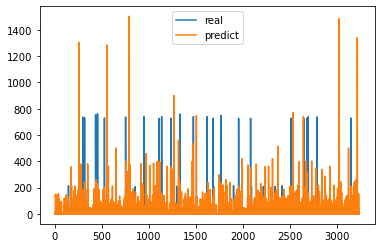

Epoch: 10; Test MAE loss on source data is: 46.781
Epoch: 10; Test MSE loss on source data is: 45013.514


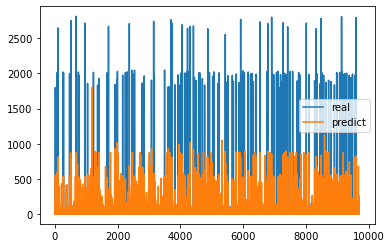

Epoch: 10; MSE loss: 9314176.000
33.864319429073305
11134.688831336598
Epoch: 11; MSE loss: 9199809.000
31.294688609483114
10274.847900033845
Epoch: 12; MSE loss: 9561998.000
32.1877957900465
10714.977413163506
Epoch: 13; MSE loss: 9581052.000
42.13825686212911
16982.134867369765
Epoch: 14; MSE loss: 9096300.000
36.937335364020775
14442.42995049477
Epoch: 15; MSE loss: 9296181.000
38.8422658363717
15723.554972540194
Epoch: 16; MSE loss: 9042601.000
43.17687736968445
18755.26103440097
Epoch: 17; MSE loss: 9293549.000
42.45261931815048
19209.780038179586
Epoch: 18; MSE loss: 9213795.000
49.74696299963885
23977.30452587926
Epoch: 19; MSE loss: 9312821.000
34.87589734359724
14780.70913681601
Epoch: 20; Test MAE loss on target data is: 34.876
Epoch: 20; Test MSE loss on target data is: 14780.709


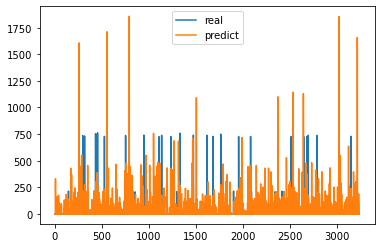

Epoch: 20; Test MAE loss on source data is: 46.890
Epoch: 20; Test MSE loss on source data is: 43343.400


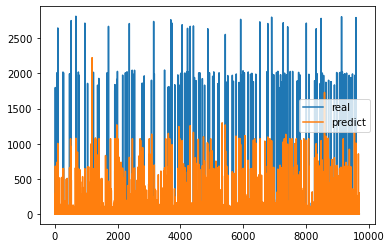

Epoch: 20; MSE loss: 8542678.000
33.29728408793946
14071.367805172904
Epoch: 21; MSE loss: 8559100.000
37.09177153472554
16131.534217067572
Epoch: 22; MSE loss: 8916512.000
29.647632625717467
12549.07026155344
Epoch: 23; MSE loss: 8544098.000
37.63133157344284
18804.600851273786
Epoch: 24; MSE loss: 7801175.500
36.170684094687886
17201.882086869584
Epoch: 25; MSE loss: 8518460.000
35.00023834123125
16656.282291089065
Epoch: 26; MSE loss: 8538891.000
33.40855636331821
15545.374263097583
Epoch: 27; MSE loss: 8486401.000
33.60016346752551
17442.59798835372
Epoch: 28; MSE loss: 8191601.500
40.67025459014927
22180.784580264597
Epoch: 29; MSE loss: 8383281.000
31.93578494980678
16526.95001705873
Epoch: 30; Test MAE loss on target data is: 31.936
Epoch: 30; Test MSE loss on target data is: 16526.950


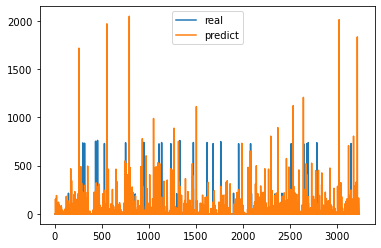

Epoch: 30; Test MAE loss on source data is: 42.772
Epoch: 30; Test MSE loss on source data is: 42084.397


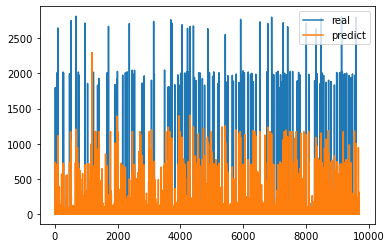

Epoch: 30; MSE loss: 7557182.000
29.756007413849396
15680.077117483688
Epoch: 31; MSE loss: 7928553.500
35.344089308348835
20315.433739610595
Epoch: 32; MSE loss: 7926149.000
29.112232652048608
14529.65499123177
Epoch: 33; MSE loss: 8503390.000
32.655571962526814
17590.92169462876
Epoch: 34; MSE loss: 8119030.000
29.771585137821976
17159.463714284353
Epoch: 35; MSE loss: 8162166.000
25.49287861228634
14336.46169305031
Epoch: 36; MSE loss: 7722252.000
35.62412215076974
24910.44869253214
Epoch: 37; MSE loss: 7991414.500
21.80681774722185
12174.432182018523
Epoch: 38; MSE loss: 7933361.000
35.57122713811984
25004.7312294106
Epoch: 39; MSE loss: 7428534.000
26.343301610931917
16189.34004943893
Epoch: 40; Test MAE loss on target data is: 26.343
Epoch: 40; Test MSE loss on target data is: 16189.340


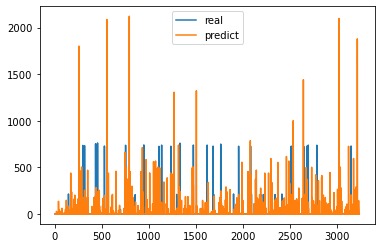

Epoch: 40; Test MAE loss on source data is: 38.674
Epoch: 40; Test MSE loss on source data is: 41986.315


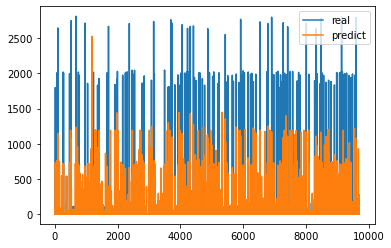

Epoch: 40; MSE loss: 7847921.500
34.661799833588475
24212.55830947737
Epoch: 41; MSE loss: 7821619.000
25.252195224981218
15807.983168635305
Epoch: 42; MSE loss: 7478395.000
32.757361073246145
24050.206378682935
Epoch: 43; MSE loss: 7876500.000
27.997245520040092
19287.29824150574
Epoch: 44; MSE loss: 7565254.500
22.204954003191435
13506.582016103048
Epoch: 45; MSE loss: 7982044.500
23.863726863942155
14490.85520350535
Epoch: 46; MSE loss: 7446164.500
20.8480388489536
12611.97714352303
Epoch: 47; MSE loss: 7677439.500
25.08304852559541
18037.63818819154
Epoch: 48; MSE loss: 7226068.000
18.956907376255465
11862.494777878717
Epoch: 49; MSE loss: 7780961.500
24.25894823269645
16543.838112721183
Epoch: 50; Test MAE loss on target data is: 24.259
Epoch: 50; Test MSE loss on target data is: 16543.838


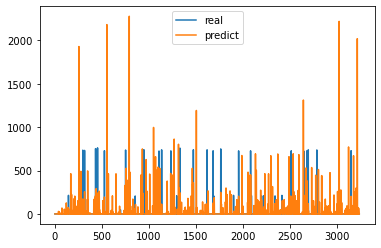

Epoch: 50; Test MAE loss on source data is: 36.285
Epoch: 50; Test MSE loss on source data is: 40411.777


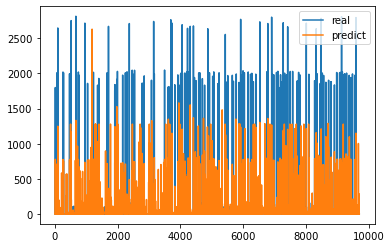

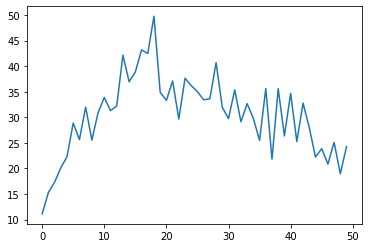

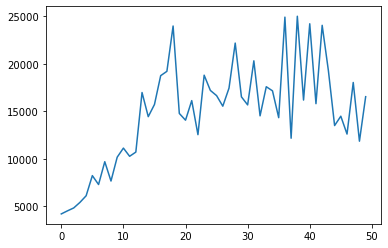

------------Domain Adaptation------------
Epoch: 0; MSE loss: 7754953.495
Epoch: 0; disc loss: 3309618.448
Epoch: 0; ceod loss: 3406.081
15.163349329190792
8892.238613779977
Parameter containing:
tensor([0.3350, 0.3344, 0.3307], device='cuda:0', requires_grad=True)
Epoch: 1; MSE loss: 8412465.986
Epoch: 1; disc loss: 2899225.320
Epoch: 1; ceod loss: 3360.735
28.07457022390557
21623.787829607125
Parameter containing:
tensor([0.3394, 0.3321, 0.3285], device='cuda:0', requires_grad=True)
Epoch: 2; MSE loss: 7095965.156
Epoch: 2; disc loss: 2405754.735
Epoch: 2; ceod loss: 3420.542
19.57411877198787
13496.498992520843
Parameter containing:
tensor([0.3441, 0.3293, 0.3266], device='cuda:0', requires_grad=True)
Epoch: 3; MSE loss: 6954058.735
Epoch: 3; disc loss: 2343330.895
Epoch: 3; ceod loss: 3265.159
32.982791799776706
28694.130770865475
Parameter containing:
tensor([0.3509, 0.3249, 0.3241], device='cuda:0', requires_grad=True)
Epoch: 4; MSE loss: 7228595.982
Epoch: 4; disc loss: 1947141.

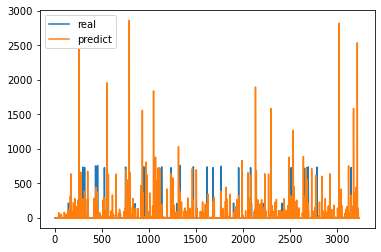

Epoch: 9; Test MAE loss on source data is: 36.362


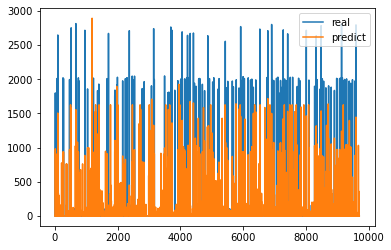

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


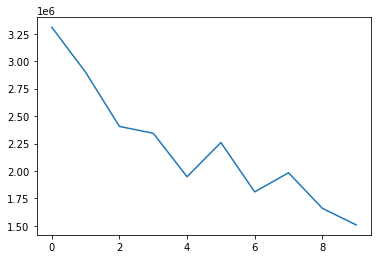

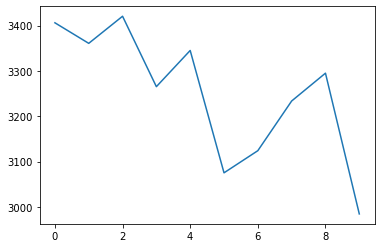

-------------------------- total running losses in 10 epoches as follows---------------------------------


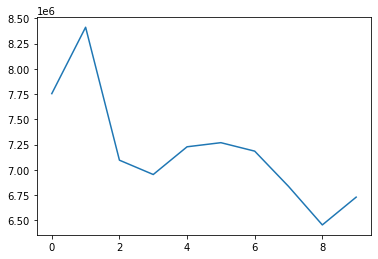

Epoch: 10; MSE loss: 6034572.605
Epoch: 10; disc loss: 1546145.784
Epoch: 10; ceod loss: 2899.183
26.96323659206284
22319.780046809752
Parameter containing:
tensor([0.4800, 0.2339, 0.2861], device='cuda:0', requires_grad=True)
Epoch: 11; MSE loss: 7114632.001
Epoch: 11; disc loss: 1516808.008
Epoch: 11; ceod loss: 2987.638
18.9574668069527
13099.382447533892
Parameter containing:
tensor([0.5179, 0.2105, 0.2715], device='cuda:0', requires_grad=True)
Epoch: 12; MSE loss: 6356641.230
Epoch: 12; disc loss: 1410908.657
Epoch: 12; ceod loss: 2908.392
22.987993735250033
19269.583490622652
Parameter containing:
tensor([0.5626, 0.1847, 0.2526], device='cuda:0', requires_grad=True)
Epoch: 13; MSE loss: 6682643.778
Epoch: 13; disc loss: 1127180.222
Epoch: 13; ceod loss: 3057.728
29.998737860076027
26456.93746429159
Parameter containing:
tensor([0.5992, 0.1609, 0.2400], device='cuda:0', requires_grad=True)
Epoch: 14; MSE loss: 6949710.603
Epoch: 14; disc loss: 1241509.893
Epoch: 14; ceod loss: 319

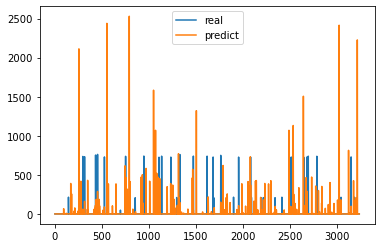

Epoch: 19; Test MAE loss on source data is: 33.989


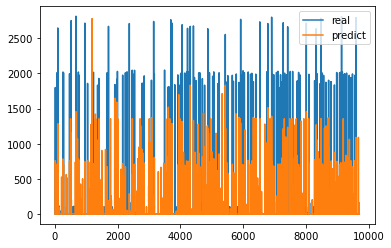

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


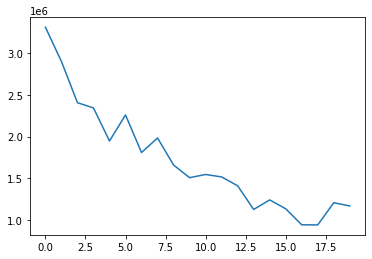

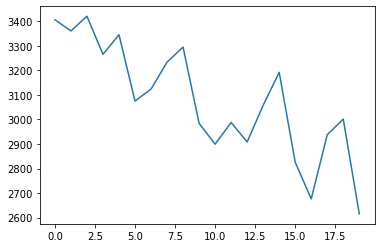

-------------------------- total running losses in 10 epoches as follows---------------------------------


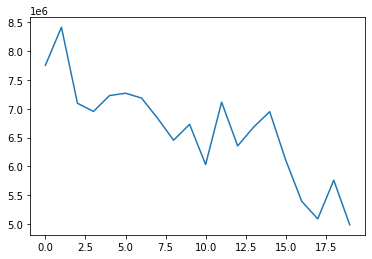

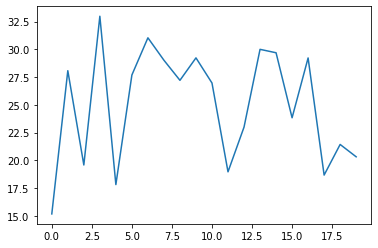

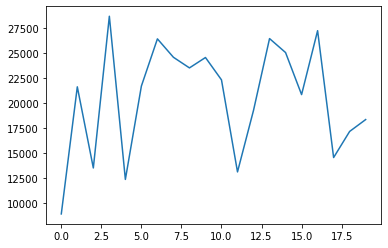

20.311812485710732
1.307327909723515
2.0439013020861583
Parameter containing:
tensor([0.8428, 0.0333, 0.1239], device='cuda:0', requires_grad=True)

---------------------------------------------- domain num 1 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 8148864.000
40.31304295661599
73694.73113335531
Epoch: 1; MSE loss: 7841943.000
39.58262535154278
70314.48947255254
Epoch: 2; MSE loss: 7061378.500
39.954536414549466
68635.97546481392
Epoch: 3; MSE loss: 7255554.000
39.459872712703906
64234.386393249704
Epoch: 4; MSE loss: 7848590.000
38.9181515646681
63666.76805624742
Epoch: 5; MSE loss: 6882836.500
39.06709050761861
66681.3120020603
Epoch: 6; MSE loss: 6987638.500
39.55852241204041
61700.99281720354
Epoch: 7; MSE loss: 7850156.000
39.21394921203347
60089.094322172634
Epoch: 8; MSE loss: 6984835.000
38.86868864538312
60616.05427576149
Epoch: 9; MSE loss: 6901972.000
39.24658193531255
59742.243702357686
Epoch: 10; Test MAE loss o

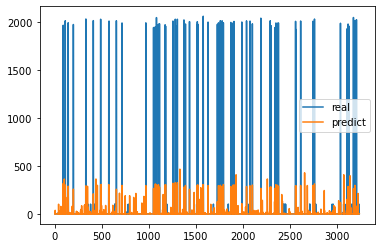

Epoch: 10; Test MAE loss on source data is: 33.401
Epoch: 10; Test MSE loss on source data is: 28996.743


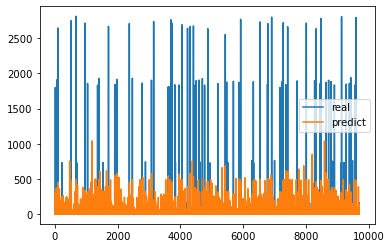

Epoch: 10; MSE loss: 7147259.000
39.083297580922775
61129.15483276942
Epoch: 11; MSE loss: 6465385.000
40.270939974942266
65251.018352843574
Epoch: 12; MSE loss: 7289601.500
39.194947327650404
61019.755187514274
Epoch: 13; MSE loss: 7024070.000
39.060598775180175
58660.990805160705
Epoch: 14; MSE loss: 6931750.500
39.18485994891967
61451.88070123907
Epoch: 15; MSE loss: 6264960.000
39.292064352761926
62372.5181761918
Epoch: 16; MSE loss: 6685151.500
38.97695808885547
58749.865518182196
Epoch: 17; MSE loss: 6517512.000
38.566507431905045
57732.084326695745
Epoch: 18; MSE loss: 6626905.000
37.30914060118762
53779.11210358387
Epoch: 19; MSE loss: 6648405.000
39.940121447736
64959.24663500504
Epoch: 20; Test MAE loss on target data is: 39.940
Epoch: 20; Test MSE loss on target data is: 64959.247


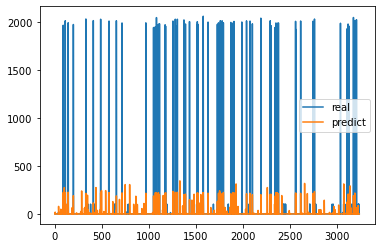

Epoch: 20; Test MAE loss on source data is: 26.128
Epoch: 20; Test MSE loss on source data is: 29654.681


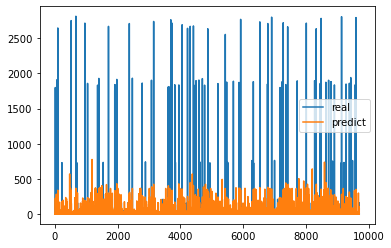

Epoch: 20; MSE loss: 6662021.500
39.21540350441057
60252.94396977425
Epoch: 21; MSE loss: 7258653.000
38.82017979515944
60969.238122729636
Epoch: 22; MSE loss: 6965756.500
38.7457331089277
57730.835997403745
Epoch: 23; MSE loss: 7204278.500
40.1655041480958
60999.45245924917
Epoch: 24; MSE loss: 6720964.500
38.95049895514753
63095.37805294403
Epoch: 25; MSE loss: 6725824.500
37.76523947455968
50442.92003095683
Epoch: 26; MSE loss: 6889611.000
38.00752815749997
56646.4733697057
Epoch: 27; MSE loss: 6890298.500
37.678941818092945
54584.35107765729
Epoch: 28; MSE loss: 6339117.000
37.44327760549979
55034.65144468115
Epoch: 29; MSE loss: 6695033.500
38.76703548861619
60154.26224790336
Epoch: 30; Test MAE loss on target data is: 38.767
Epoch: 30; Test MSE loss on target data is: 60154.262


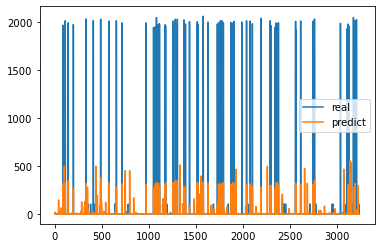

Epoch: 30; Test MAE loss on source data is: 27.933
Epoch: 30; Test MSE loss on source data is: 29201.299


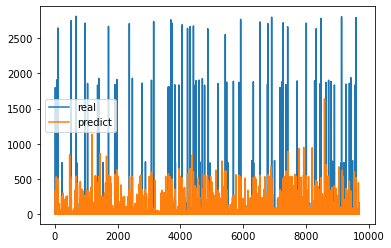

Epoch: 30; MSE loss: 6083568.000
38.85499591031436
61687.77135178912
Epoch: 31; MSE loss: 6333063.000
38.83898778110973
57850.056278363394
Epoch: 32; MSE loss: 6319778.500
38.8982810482544
59927.85680935439
Epoch: 33; MSE loss: 6325578.500
37.59949278522404
56237.69650888769
Epoch: 34; MSE loss: 6420573.500
38.106817382583294
52750.80242806812
Epoch: 35; MSE loss: 6480408.000
39.157458961433754
55684.79246544978
Epoch: 36; MSE loss: 6708977.500
38.19617958614226
59087.15339871201
Epoch: 37; MSE loss: 6063816.500
36.958953035964846
55653.85649213187
Epoch: 38; MSE loss: 5987950.000
38.164033054153926
57622.86230267069
Epoch: 39; MSE loss: 6206576.500
39.160605419198
59591.925570404084
Epoch: 40; Test MAE loss on target data is: 39.161
Epoch: 40; Test MSE loss on target data is: 59591.926


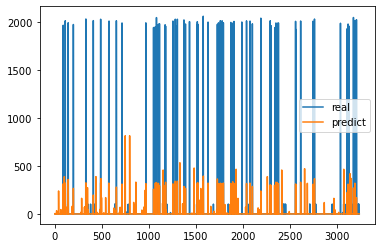

Epoch: 40; Test MAE loss on source data is: 26.561
Epoch: 40; Test MSE loss on source data is: 28702.657


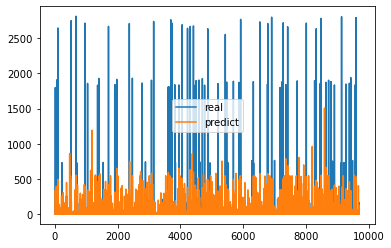

Epoch: 40; MSE loss: 6176597.000
37.761912134234464
57700.307960803606
Epoch: 41; MSE loss: 5845478.000
38.48495373456887
56984.97512534139
Epoch: 42; MSE loss: 6521558.000
38.27736043673947
57447.56831223413
Epoch: 43; MSE loss: 6542159.500
36.88171746205694
54571.93038418402
Epoch: 44; MSE loss: 6323237.500
37.294849636897425
55489.24010985935
Epoch: 45; MSE loss: 6408367.000
39.33157252332619
58140.73450027778
Epoch: 46; MSE loss: 6211260.500
38.08113535449162
55107.565302439536
Epoch: 47; MSE loss: 6553713.500
37.526818462197525
53016.75473783016
Epoch: 48; MSE loss: 6063931.500
37.751970922246784
57514.571377329514
Epoch: 49; MSE loss: 6101226.500
38.815050517978406
62766.977525741175
Epoch: 50; Test MAE loss on target data is: 38.815
Epoch: 50; Test MSE loss on target data is: 62766.978


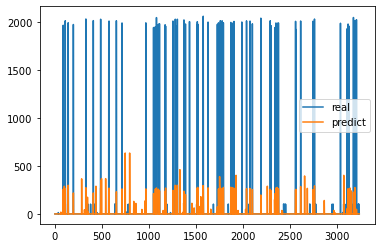

Epoch: 50; Test MAE loss on source data is: 22.110
Epoch: 50; Test MSE loss on source data is: 28333.580


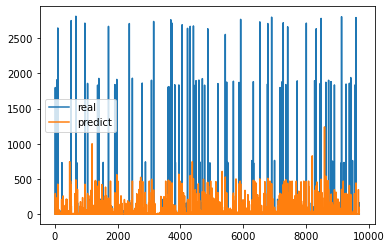

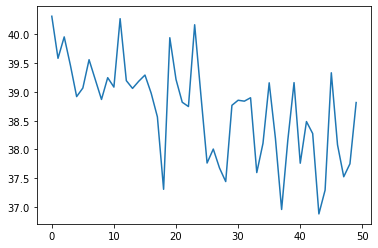

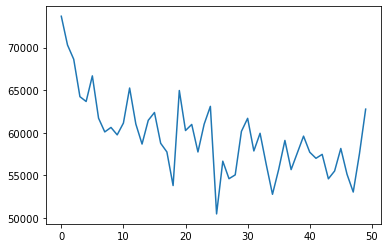

------------Domain Adaptation------------
Epoch: 0; MSE loss: 7006121.852
Epoch: 0; disc loss: 1152602.271
Epoch: 0; ceod loss: 4410.503
38.83224018533963
67813.10637606305
Parameter containing:
tensor([0.3335, 0.3324, 0.3341], device='cuda:0', requires_grad=True)
Epoch: 1; MSE loss: 6899613.430
Epoch: 1; disc loss: 882401.329
Epoch: 1; ceod loss: 4357.917
37.60535139716943
54449.01062776302
Parameter containing:
tensor([0.3294, 0.3331, 0.3375], device='cuda:0', requires_grad=True)
Epoch: 2; MSE loss: 6789525.647
Epoch: 2; disc loss: 651077.022
Epoch: 2; ceod loss: 4239.860
36.06693126628351
52308.01376757201
Parameter containing:
tensor([0.3181, 0.3377, 0.3442], device='cuda:0', requires_grad=True)
Epoch: 3; MSE loss: 7319581.230
Epoch: 3; disc loss: 633107.952
Epoch: 3; ceod loss: 4030.272
36.7168379116648
55333.84392725795
Parameter containing:
tensor([0.2997, 0.3480, 0.3523], device='cuda:0', requires_grad=True)
Epoch: 4; MSE loss: 7041333.224
Epoch: 4; disc loss: 178272.816
Epoch:

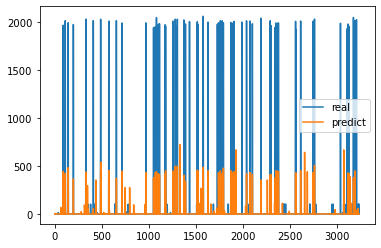

Epoch: 9; Test MAE loss on source data is: 26.152


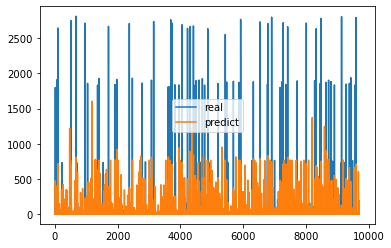

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


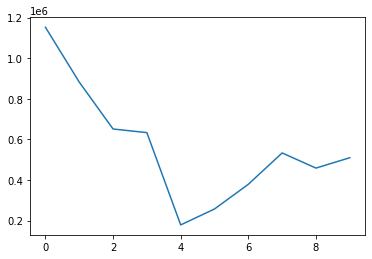

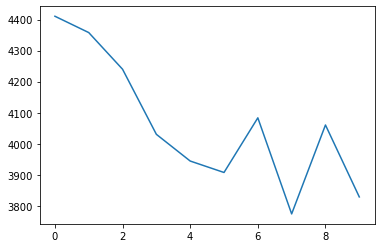

-------------------------- total running losses in 10 epoches as follows---------------------------------


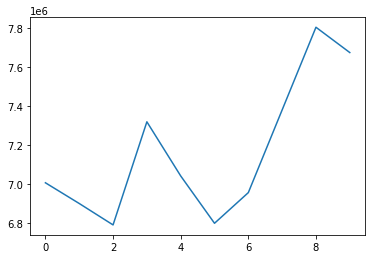

Epoch: 10; MSE loss: 7327418.859
Epoch: 10; disc loss: 546966.686
Epoch: 10; ceod loss: 3794.926
37.73784312236438
63099.28377650845
Parameter containing:
tensor([0.1816, 0.3730, 0.4454], device='cuda:0', requires_grad=True)
Epoch: 11; MSE loss: 7256365.120
Epoch: 11; disc loss: 419382.403
Epoch: 11; ceod loss: 3613.430
37.36087154085522
61686.194213754
Parameter containing:
tensor([0.1600, 0.3798, 0.4602], device='cuda:0', requires_grad=True)
Epoch: 12; MSE loss: 7872971.225
Epoch: 12; disc loss: 302486.655
Epoch: 12; ceod loss: 3764.271
39.067699404588254
68826.19490203784
Parameter containing:
tensor([0.1329, 0.3901, 0.4770], device='cuda:0', requires_grad=True)
Epoch: 13; MSE loss: 7843526.892
Epoch: 13; disc loss: 318082.453
Epoch: 13; ceod loss: 3659.174
37.631045357558236
61031.80513291749
Parameter containing:
tensor([0.1082, 0.3987, 0.4931], device='cuda:0', requires_grad=True)
Epoch: 14; MSE loss: 8290285.474
Epoch: 14; disc loss: 531461.820
Epoch: 14; ceod loss: 3632.212
37.

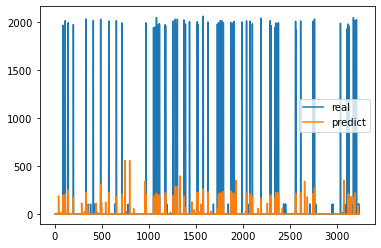

Epoch: 19; Test MAE loss on source data is: 20.586


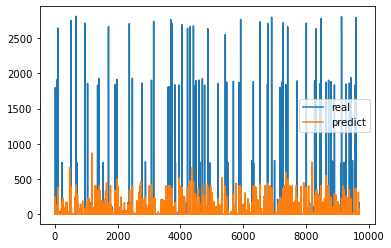

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


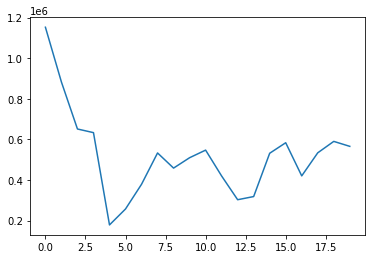

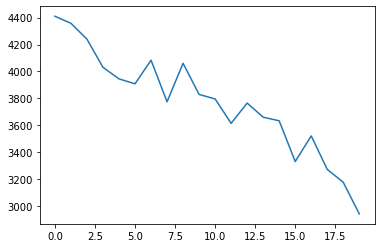

-------------------------- total running losses in 10 epoches as follows---------------------------------


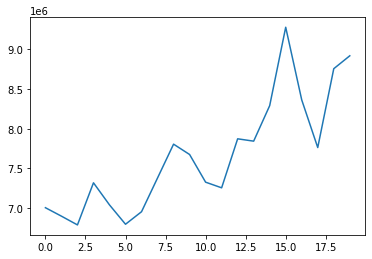

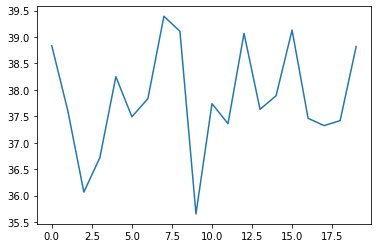

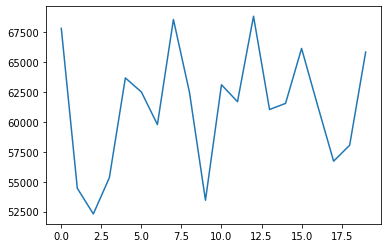

38.81841285416664
0.8673778035760312
0.9117640397463771
Parameter containing:
tensor([0.0333, 0.4020, 0.5646], device='cuda:0', requires_grad=True)

---------------------------------------------- domain num 2 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 9816637.000
26.253599948908736
35538.45712978285
Epoch: 1; MSE loss: 9659205.000
33.388443698536555
33717.08160042369
Epoch: 2; MSE loss: 8599927.000
37.04857998994716
32828.39228941714
Epoch: 3; MSE loss: 8662034.000
36.23928348598469
33000.930563920505
Epoch: 4; MSE loss: 8273139.000
40.635258663648386
32913.172079881886
Epoch: 5; MSE loss: 7967426.000
45.18104215639843
33285.495972196004
Epoch: 6; MSE loss: 7835769.000
43.71046580440916
32677.960782980343
Epoch: 7; MSE loss: 7293046.500
43.71978519912089
32810.1062319351
Epoch: 8; MSE loss: 7123250.500
48.45926911824108
33937.472012467355
Epoch: 9; MSE loss: 7566998.500
48.06656112114466
34065.68651710489
Epoch: 10; Test MAE lo

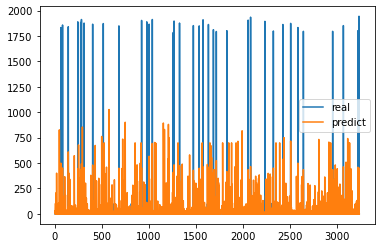

Epoch: 10; Test MAE loss on source data is: 30.309
Epoch: 10; Test MSE loss on source data is: 28930.685


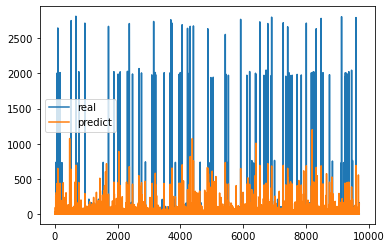

Epoch: 10; MSE loss: 6683848.500
47.27440198842304
33846.459258056304
Epoch: 11; MSE loss: 7052444.000
43.775074605087546
33161.60640269276
Epoch: 12; MSE loss: 7061549.500
50.22207341980897
34975.05103843941
Epoch: 13; MSE loss: 6244004.000
47.60300786994985
33919.50598865993
Epoch: 14; MSE loss: 7083242.500
46.41005989634007
33945.17674938003
Epoch: 15; MSE loss: 6562991.500
45.92423235841522
33813.64764127562
Epoch: 16; MSE loss: 6176845.000
38.598101517969205
32197.845675578672
Epoch: 17; MSE loss: 6201154.000
49.25274789762184
35726.474224892256
Epoch: 18; MSE loss: 6179590.500
47.36605489218991
35251.635000980335
Epoch: 19; MSE loss: 6398958.500
45.3789748156734
34571.69989769034
Epoch: 20; Test MAE loss on target data is: 45.379
Epoch: 20; Test MSE loss on target data is: 34571.700


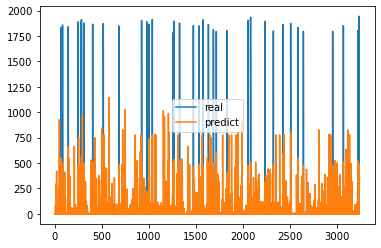

Epoch: 20; Test MAE loss on source data is: 27.007
Epoch: 20; Test MSE loss on source data is: 27873.621


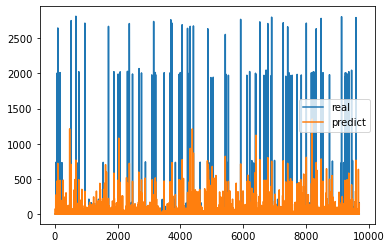

Epoch: 20; MSE loss: 6153364.500
42.451267777337264
33704.87377523177
Epoch: 21; MSE loss: 6099156.000
41.11768301928062
33093.40449825837
Epoch: 22; MSE loss: 6005781.500
46.44423569925417
35573.713608492864
Epoch: 23; MSE loss: 6449111.500
47.14561165297602
36017.55111165801
Epoch: 24; MSE loss: 5610813.500
40.467702480943345
33770.50346395079
Epoch: 25; MSE loss: 5452753.500
37.84472798604685
32630.840625827233
Epoch: 26; MSE loss: 5747697.500
44.78182116443812
35841.34132686111
Epoch: 27; MSE loss: 5646343.000
41.752490290589456
34510.91457636424
Epoch: 28; MSE loss: 5303421.000
41.65391416763412
34406.70665524802
Epoch: 29; MSE loss: 6210973.000
40.33383792836847
33548.60051580011
Epoch: 30; Test MAE loss on target data is: 40.334
Epoch: 30; Test MSE loss on target data is: 33548.601


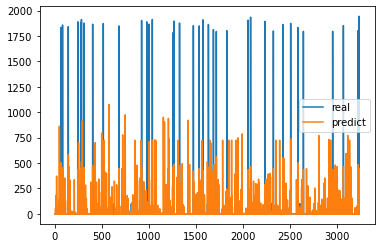

Epoch: 30; Test MAE loss on source data is: 23.724
Epoch: 30; Test MSE loss on source data is: 28441.903


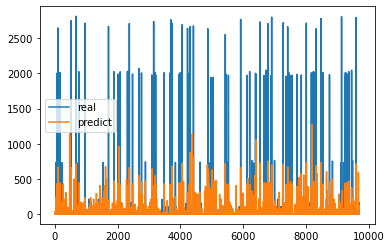

Epoch: 30; MSE loss: 5916512.000
43.73892377922671
35535.78762737931
Epoch: 31; MSE loss: 5672553.000
41.84352561372233
35381.25403954708
Epoch: 32; MSE loss: 5809126.500
45.11265739702276
36954.23808161051
Epoch: 33; MSE loss: 5536654.500
37.45660754099972
32603.069541132016
Epoch: 34; MSE loss: 5816059.500
43.668911670809365
36145.13864926377
Epoch: 35; MSE loss: 5885216.000
40.26398598330651
34410.93791169495
Epoch: 36; MSE loss: 5453336.500
38.804567617200995
33801.76953820702
Epoch: 37; MSE loss: 5330272.500
37.45173172392008
33543.59020868637
Epoch: 38; MSE loss: 5836351.500
39.30873225862405
34536.62351818572
Epoch: 39; MSE loss: 5342037.000
34.154084912932824
32838.654282800184
Epoch: 40; Test MAE loss on target data is: 34.154
Epoch: 40; Test MSE loss on target data is: 32838.654


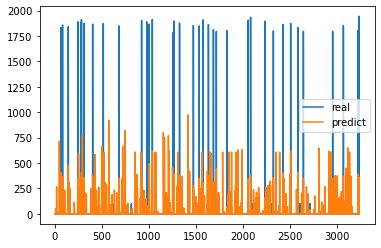

Epoch: 40; Test MAE loss on source data is: 21.017
Epoch: 40; Test MSE loss on source data is: 30558.376


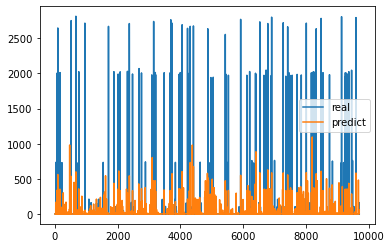

Epoch: 40; MSE loss: 5360240.500
37.35912470312723
33505.63040203628
Epoch: 41; MSE loss: 5359720.500
39.40368948358657
34692.96537455095
Epoch: 42; MSE loss: 5308951.500
36.40739620745274
32988.03080014372
Epoch: 43; MSE loss: 5024258.500
32.96045861879862
32993.79433977098
Epoch: 44; MSE loss: 5424398.500
38.89671136083706
35181.650619067106
Epoch: 45; MSE loss: 5412871.000
46.38851484622248
41905.68974405374
Epoch: 46; MSE loss: 4911798.000
46.595274902652186
41215.6507233338
Epoch: 47; MSE loss: 5158703.000
34.73699521508062
33226.04722887164
Epoch: 48; MSE loss: 4767421.000
38.08593680432996
34641.192499006276
Epoch: 49; MSE loss: 4891480.000
33.897772348498265
32630.828281254013
Epoch: 50; Test MAE loss on target data is: 33.898
Epoch: 50; Test MSE loss on target data is: 32630.828


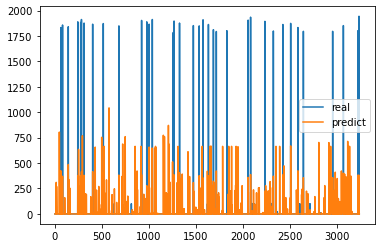

Epoch: 50; Test MAE loss on source data is: 20.807
Epoch: 50; Test MSE loss on source data is: 29917.649


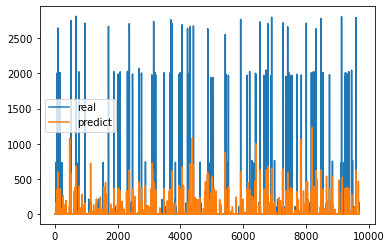

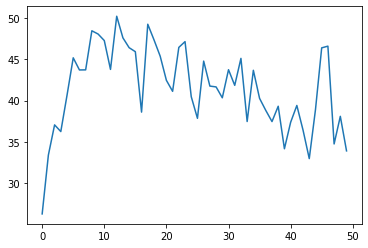

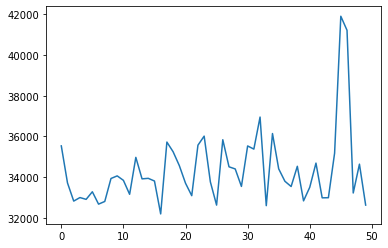

------------Domain Adaptation------------
Epoch: 0; MSE loss: 4530253.903
Epoch: 0; disc loss: 3582517.188
Epoch: 0; ceod loss: 3226.809
30.31191133095824
32696.09914907545
Parameter containing:
tensor([0.3325, 0.3362, 0.3313], device='cuda:0', requires_grad=True)
Epoch: 1; MSE loss: 4800645.506
Epoch: 1; disc loss: 3572430.821
Epoch: 1; ceod loss: 3363.083
38.09405196055747
35556.06889321632
Parameter containing:
tensor([0.3316, 0.3369, 0.3315], device='cuda:0', requires_grad=True)
Epoch: 2; MSE loss: 5224095.316
Epoch: 2; disc loss: 3243620.930
Epoch: 2; ceod loss: 3071.468
28.574354131153598
32943.82388277799
Parameter containing:
tensor([0.3297, 0.3428, 0.3275], device='cuda:0', requires_grad=True)
Epoch: 3; MSE loss: 5036574.475
Epoch: 3; disc loss: 2941465.198
Epoch: 3; ceod loss: 3093.882
27.88353534021186
33371.93752633882
Parameter containing:
tensor([0.3285, 0.3503, 0.3213], device='cuda:0', requires_grad=True)
Epoch: 4; MSE loss: 5148304.420
Epoch: 4; disc loss: 2651696.088


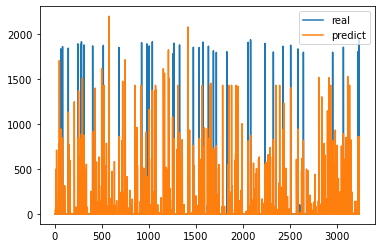

Epoch: 9; Test MAE loss on source data is: 26.023


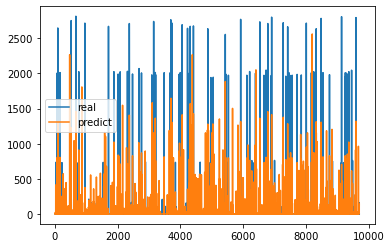

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


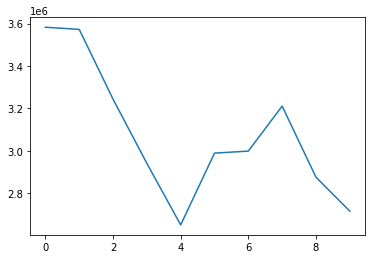

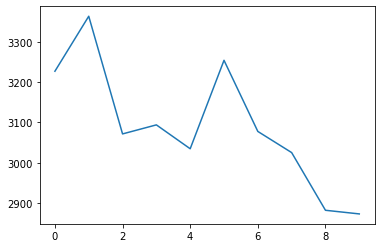

-------------------------- total running losses in 10 epoches as follows---------------------------------


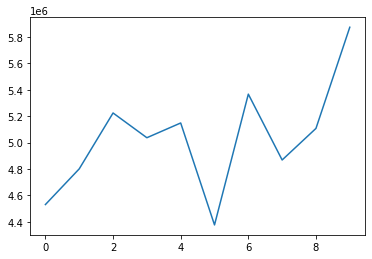

Epoch: 10; MSE loss: 4574945.404
Epoch: 10; disc loss: 2538786.752
Epoch: 10; ceod loss: 3254.489
29.87919687303546
34649.19023687793
Parameter containing:
tensor([0.2736, 0.4648, 0.2615], device='cuda:0', requires_grad=True)
Epoch: 11; MSE loss: 4956191.771
Epoch: 11; disc loss: 2220298.166
Epoch: 11; ceod loss: 3289.769
25.466927249796424
35005.04395527365
Parameter containing:
tensor([0.2641, 0.4871, 0.2488], device='cuda:0', requires_grad=True)
Epoch: 12; MSE loss: 5095817.199
Epoch: 12; disc loss: 2903661.240
Epoch: 12; ceod loss: 2766.251
37.22088188926993
35703.638898236786
Parameter containing:
tensor([0.2507, 0.5160, 0.2334], device='cuda:0', requires_grad=True)
Epoch: 13; MSE loss: 5025659.164
Epoch: 13; disc loss: 2326086.871
Epoch: 13; ceod loss: 2852.270
31.7936797868708
33642.70043667641
Parameter containing:
tensor([0.2372, 0.5397, 0.2231], device='cuda:0', requires_grad=True)
Epoch: 14; MSE loss: 4958723.523
Epoch: 14; disc loss: 2195874.913
Epoch: 14; ceod loss: 2677.5

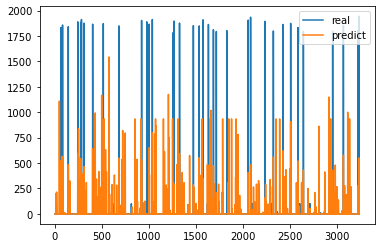

Epoch: 19; Test MAE loss on source data is: 20.094


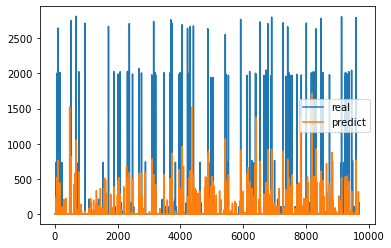

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


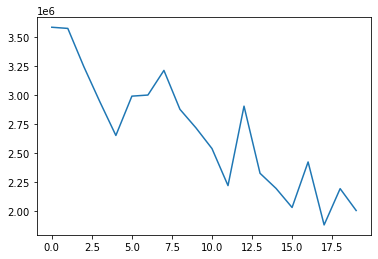

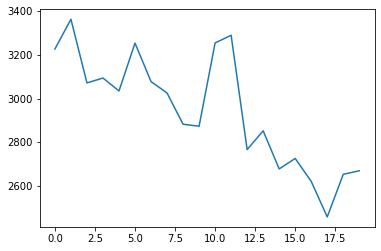

-------------------------- total running losses in 10 epoches as follows---------------------------------


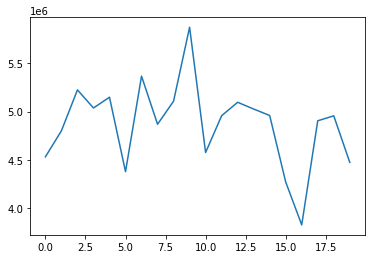

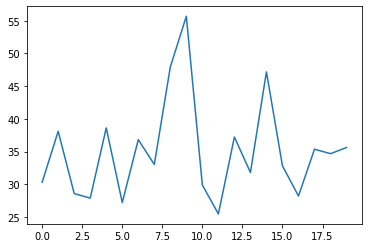

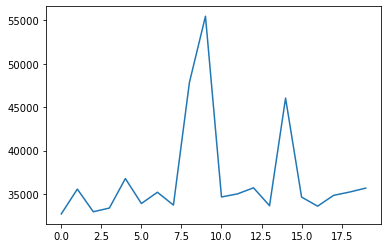

35.61698864965572
0.16358888043858882
0.9613764905068023
Parameter containing:
tensor([0.1025, 0.8100, 0.0875], device='cuda:0', requires_grad=True)

---------------------------------------------- domain num 3 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 9677568.000
26.209873602865766
57702.31888582586
Epoch: 1; MSE loss: 9121417.000
28.486183397250805
55026.67471586838
Epoch: 2; MSE loss: 8790539.000
38.11363863353107
49211.238429260615
Epoch: 3; MSE loss: 8374315.500
35.610424546951535
49052.622924291565
Epoch: 4; MSE loss: 8073685.000
35.63261710439551
49073.01513465544
Epoch: 5; MSE loss: 7493064.500
38.89321340212636
47012.60954715303
Epoch: 6; MSE loss: 7533737.000
40.92166133293597
45836.805927334906
Epoch: 7; MSE loss: 7338218.500
40.91562055783948
46319.84201051339
Epoch: 8; MSE loss: 7855287.500
42.09219397435647
46723.67834210579
Epoch: 9; MSE loss: 7009652.500
38.52873692873871
46078.707020320406
Epoch: 10; Test MAE l

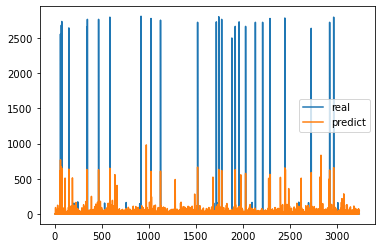

Epoch: 10; Test MAE loss on source data is: 35.280
Epoch: 10; Test MSE loss on source data is: 28425.077


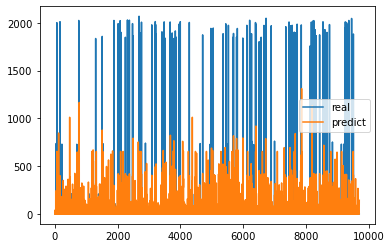

Epoch: 10; MSE loss: 6793278.500
39.74086045872944
46270.90682773221
Epoch: 11; MSE loss: 7032797.500
42.17753380424526
45447.57092861013
Epoch: 12; MSE loss: 6673231.000
45.77297059554129
43501.04687346647
Epoch: 13; MSE loss: 6528982.000
37.42364847360199
46455.548604095966
Epoch: 14; MSE loss: 6677624.000
41.50680673997935
44333.89314312701
Epoch: 15; MSE loss: 6414286.000
35.350074127954436
45830.2694777486
Epoch: 16; MSE loss: 6933066.000
37.13125231742076
45258.0076283011
Epoch: 17; MSE loss: 6757153.500
35.36418456931525
45852.3052281357
Epoch: 18; MSE loss: 6366162.500
38.51621292522278
43155.54600981059
Epoch: 19; MSE loss: 6895624.000
33.93986110255307
45403.85006113418
Epoch: 20; Test MAE loss on target data is: 33.940
Epoch: 20; Test MSE loss on target data is: 45403.850


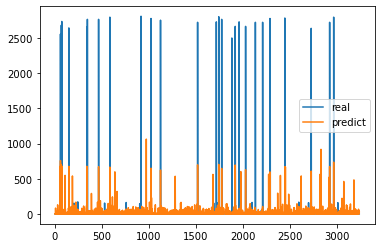

Epoch: 20; Test MAE loss on source data is: 31.356
Epoch: 20; Test MSE loss on source data is: 27654.260


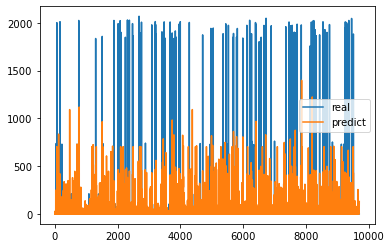

Epoch: 20; MSE loss: 6188216.500
32.78453828851812
46648.354269777934
Epoch: 21; MSE loss: 6387295.500
38.363597149048374
43249.683391606
Epoch: 22; MSE loss: 6048447.500
38.193705660375656
43034.97964503682
Epoch: 23; MSE loss: 6548424.000
34.750718430370966
44332.33337152751
Epoch: 24; MSE loss: 5899931.500
30.71644431462877
48418.13364002222
Epoch: 25; MSE loss: 6510245.500
30.091446391304228
47521.05746009817
Epoch: 26; MSE loss: 6149332.500
35.853660432978245
42310.16766231599
Epoch: 27; MSE loss: 6138497.000
30.363548694147944
47572.0954335353
Epoch: 28; MSE loss: 5995321.000
35.353601464689056
43092.23864046066
Epoch: 29; MSE loss: 6014129.500
32.93696319382678
43875.606696032744
Epoch: 30; Test MAE loss on target data is: 32.937
Epoch: 30; Test MSE loss on target data is: 43875.607


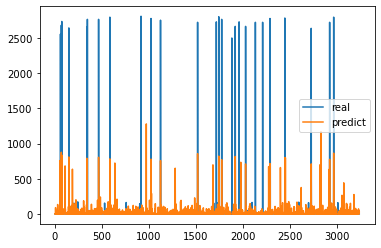

Epoch: 30; Test MAE loss on source data is: 30.529
Epoch: 30; Test MSE loss on source data is: 26868.386


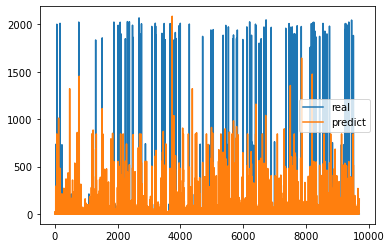

Epoch: 30; MSE loss: 6444406.000
31.34852307437929
46036.620417544415
Epoch: 31; MSE loss: 6360124.000
30.488205402248887
44091.84958251687
Epoch: 32; MSE loss: 6138829.000
27.987714697227137
47433.63335067603
Epoch: 33; MSE loss: 6358521.000
28.038911101982066
47408.46741187396
Epoch: 34; MSE loss: 5906183.500
29.736090420101306
45510.40555535848
Epoch: 35; MSE loss: 6202350.500
28.194229297250093
46762.323672399216
Epoch: 36; MSE loss: 6283923.500
35.06976935258236
41797.299057041826
Epoch: 37; MSE loss: 5623410.000
25.73964297413089
48766.06594417621
Epoch: 38; MSE loss: 5992170.000
27.964002019837153
47213.26222983022
Epoch: 39; MSE loss: 5429423.500
25.385835810189914
49410.939027315224
Epoch: 40; Test MAE loss on target data is: 25.386
Epoch: 40; Test MSE loss on target data is: 49410.939


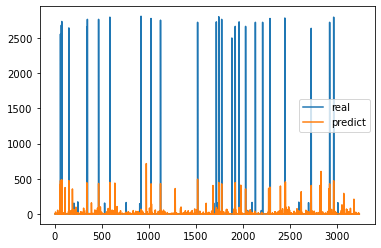

Epoch: 40; Test MAE loss on source data is: 24.698
Epoch: 40; Test MSE loss on source data is: 28464.519


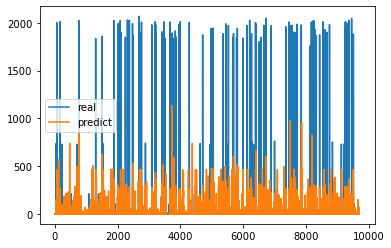

Epoch: 40; MSE loss: 6408327.500
31.73029358337246
41811.886744755655
Epoch: 41; MSE loss: 5961756.000
32.31867393053481
41229.12719619796
Epoch: 42; MSE loss: 5407588.000
29.566791010368185
43503.85890959436
Epoch: 43; MSE loss: 6030643.500
26.727215617687847
45847.47068276226
Epoch: 44; MSE loss: 5817571.000
28.097499067263772
43776.24579529961
Epoch: 45; MSE loss: 5612903.000
25.498624657907477
46958.44489891418
Epoch: 46; MSE loss: 5130044.000
27.047864806781043
45220.799606608365
Epoch: 47; MSE loss: 5786046.500
26.90792047807017
45734.619139392846
Epoch: 48; MSE loss: 5414002.500
28.357803089186618
42472.91029535401
Epoch: 49; MSE loss: 5582571.500
25.43164524804035
47115.01108270104
Epoch: 50; Test MAE loss on target data is: 25.432
Epoch: 50; Test MSE loss on target data is: 47115.011


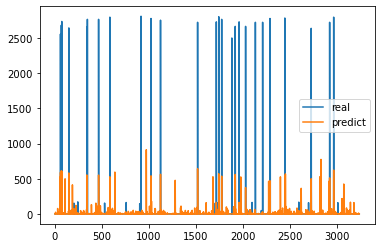

Epoch: 50; Test MAE loss on source data is: 25.591
Epoch: 50; Test MSE loss on source data is: 27380.115


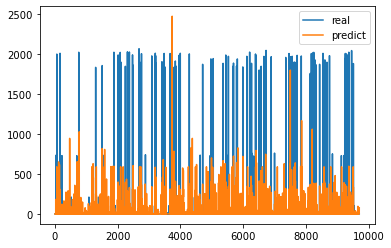

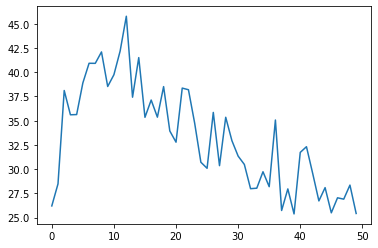

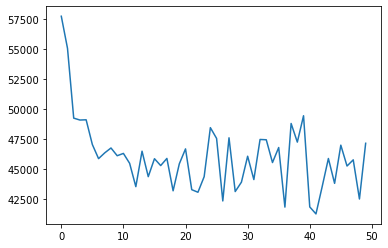

------------Domain Adaptation------------
Epoch: 0; MSE loss: 5669773.991
Epoch: 0; disc loss: 2895777.450
Epoch: 0; ceod loss: 2796.989
28.518985460898975
43441.889791952584
Parameter containing:
tensor([0.3346, 0.3341, 0.3313], device='cuda:0', requires_grad=True)
Epoch: 1; MSE loss: 5624992.721
Epoch: 1; disc loss: 2228649.891
Epoch: 1; ceod loss: 2771.795
23.537359628666312
53310.45510978899
Parameter containing:
tensor([0.3353, 0.3384, 0.3263], device='cuda:0', requires_grad=True)
Epoch: 2; MSE loss: 5617726.590
Epoch: 2; disc loss: 2120296.250
Epoch: 2; ceod loss: 2890.509
27.882049091544918
43783.26581542999
Parameter containing:
tensor([0.3360, 0.3465, 0.3175], device='cuda:0', requires_grad=True)
Epoch: 3; MSE loss: 5602579.608
Epoch: 3; disc loss: 2025894.963
Epoch: 3; ceod loss: 2779.917
25.93348237249361
46300.409232225764
Parameter containing:
tensor([0.3327, 0.3560, 0.3113], device='cuda:0', requires_grad=True)
Epoch: 4; MSE loss: 5363337.760
Epoch: 4; disc loss: 2054053.

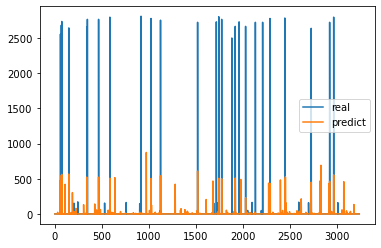

Epoch: 9; Test MAE loss on source data is: 23.086


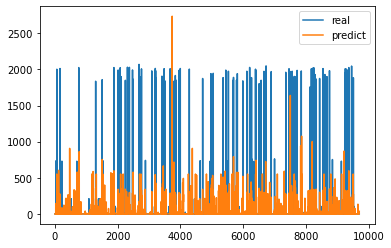

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


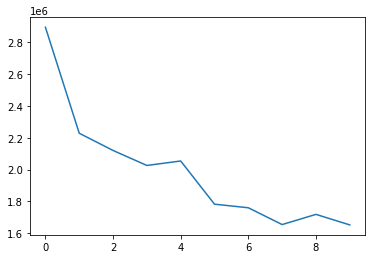

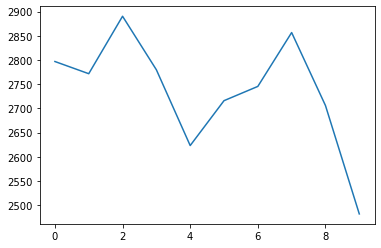

-------------------------- total running losses in 10 epoches as follows---------------------------------


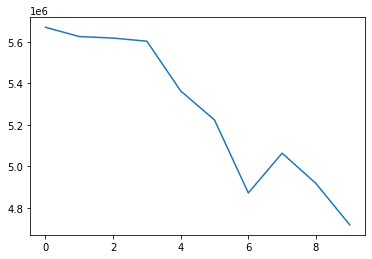

Epoch: 10; MSE loss: 5239699.235
Epoch: 10; disc loss: 1613452.951
Epoch: 10; ceod loss: 2533.152
23.54148798641134
53359.50247030615
Parameter containing:
tensor([0.2472, 0.5619, 0.1909], device='cuda:0', requires_grad=True)
Epoch: 11; MSE loss: 4530344.914
Epoch: 11; disc loss: 1763445.338
Epoch: 11; ceod loss: 2532.793
27.280987334361953
40105.164537487624
Parameter containing:
tensor([0.2372, 0.5977, 0.1651], device='cuda:0', requires_grad=True)
Epoch: 12; MSE loss: 4771195.720
Epoch: 12; disc loss: 1894184.755
Epoch: 12; ceod loss: 2585.506
24.096469065574627
45780.01793596203
Parameter containing:
tensor([0.2302, 0.6244, 0.1454], device='cuda:0', requires_grad=True)
Epoch: 13; MSE loss: 4715649.761
Epoch: 13; disc loss: 2318271.805
Epoch: 13; ceod loss: 2571.703
25.46777489614634
41808.59497177068
Parameter containing:
tensor([0.2250, 0.6497, 0.1253], device='cuda:0', requires_grad=True)
Epoch: 14; MSE loss: 4691724.201
Epoch: 14; disc loss: 2071311.263
Epoch: 14; ceod loss: 2885

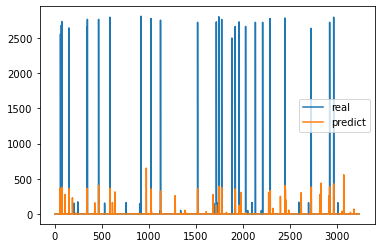

Epoch: 19; Test MAE loss on source data is: 21.943


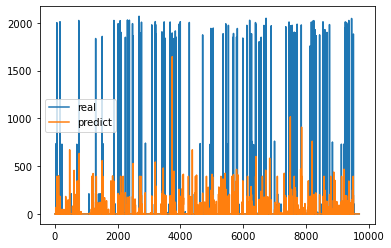

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


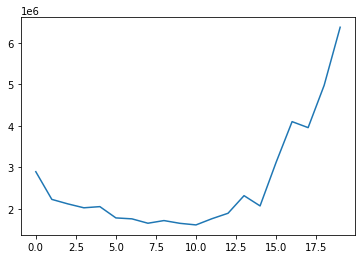

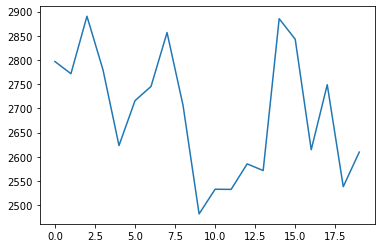

-------------------------- total running losses in 10 epoches as follows---------------------------------


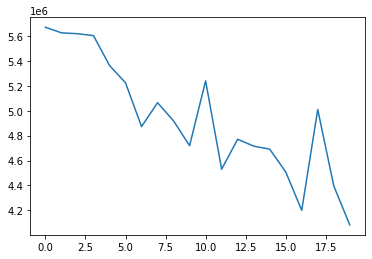

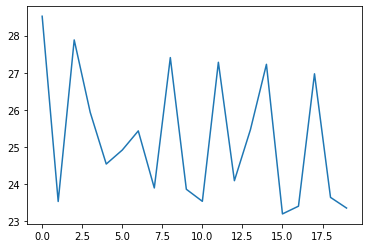

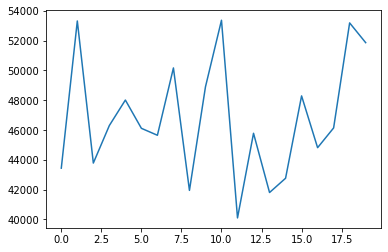

23.36089612085263
0.8229160210225845
0.9162305184730369
Parameter containing:
tensor([0.1872, 0.7795, 0.0333], device='cuda:0', requires_grad=True)


In [ ]:
import importlib
# import models.hdisc_msda 
# importlib.reload(models.hdisc_msda)
# from models.hdisc_msda import Disc_MSDANet
import matplotlib.pyplot as plt

#Number of experiments to launch
num_data_sets=len(fileList)
num_domains=num_data_sets-1
nb_experiments = 1

#-np.inf
params= {'input_dim': 19, 'output_dim': 1, 'n_sources': num_data_sets-1, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': 0, 'max_pred': np.inf}

#Number of epochs
epochs_pretrain, epochs_adapt =50,20

for exp in range(nb_experiments):
    print('\n ----------------------------- %i / %i -----------------------------'%(exp+1, nb_experiments))
    mse_list, mae_list =  {}, {}
    alphas = {}
    for i in range(num_data_sets):
        print('\n---------------------------------------------- domain num %i is running----------------------------------'%(i))
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        
        ############################# Build and define model ####################################
        params['feature_extractor'] = get_feature_extractor()
        params['h_pred'] = get_predictor(output_dim=1)
        params['h_disc'] = get_discriminator(num_domains, output_dim=1)
        model = Disc_MSDANet(params).to(device)

#         #Pre-training
        print('------------Pre-training------------')
        lr = 0.0001
        lr1=0.00001
        batch_size =64
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        mae_loss,mse_loss=[],[]
        for epoch in range(epochs_pretrain):
            running_loss=0.0
            model.train()
#             input_sizes = [data.shape[0] for data in source_insts]
#             max_input_size = max(input_sizes)
#             K=int(max_input_size/batch_size)
#             print('K value is:', K)

            loader = multi_data_loader(source_insts, source_labels, batch_size)
    
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_t = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                loss_pred = model.train_prediction(x_bs, x_t, y_bs, clip=1, pred_only=False)
#                 print("predictor is:", model.h_pred.weight.data) 
                running_loss+=loss_pred
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            model.eval()
            prediction=model.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            if (epoch+1)%10==0:
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()        
     
                
        print('------------Domain Adaptation------------')
        disc_losslist, ceod_losslist, loss_list=[],[],[]
        mae_loss,mse_loss=[],[]
        lr = 0.0001
        lr1=0.000001
        batch_size =64
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        
        for epoch in range(epochs_adapt):
            running_loss = 0.0
            discloss = 0.0
            ceodloss = 0.0
            model.train()
            loader = multi_data_loader(source_insts, source_labels, batch_size)
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_bt = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)

                #Train h to minimize source loss

            #stage 1
                for a in range(5):
                    disc_loss1 = model.train_disc(x_bs, x_bt, y_bs, clip=1)
                for b in range(1):
                    loss,source_loss,ceod_loss,disc_loss=model.train_all_feat(x_bs, x_bt, y_bs, clip=1)
#                     print("extractor is:", model.feature_extractor[5][0].weight) 
#                     print("discriminator is ", model.h_disc[0].weight.data)
#                     print("Hybrid loss is ", loss)
            #stage 2  
               # loss,source_loss,ceod_loss,disc_loss=model.train_all(x_bs, x_bt, y_bs, clip=1)
            #maximize discrepancy by opt_disc
#                 print("###############finish test########################")
                for c in range(1):
                    loss,source_loss,ceod_loss=model.train_all_pred(x_bs, x_bt, y_bs, clip=1)
                for d in range(2):
                    disc_loss=model.train_all_alpha(x_bs, x_bt, y_bs, clip=1)
#                     print("predictor is ", model.h_pred.weight.data)
                running_loss += loss.item()
                discloss += disc_loss.item()
                ceodloss+=ceod_loss.item()
            loss_list.append(running_loss)
            disc_losslist.append(discloss)
            ceod_losslist.append(ceodloss)
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            print('Epoch: %i; disc loss: %.3f'%(epoch, discloss))
            print('Epoch: %i; ceod loss: %.3f'%(epoch, ceodloss))
            model.eval()
#             print(X_t)
            prediction=model.predict(X_t).cpu().detach().numpy()
#             print(prediction)
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            print(model.alpha)
            if (epoch+1)%10==0:
                print('--------------------------results as follows ---------------------------------')
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
        #                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()

                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
            if (epoch+1)%10==0:
                print('--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),disc_losslist,label='discripency')
                plt.show()
                plt.plot(range(len(loss_list)),ceod_losslist,label='CEOD loss')
                plt.show()
                print('-------------------------- total running losses in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),loss_list,label='Total_loss')
                plt.show()
#             if disc_loss<=100:
#                 break;
                
            # if stopT<=28:
            #     break;
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()
        model.eval()
        prediction=model.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))
        print(model.alpha)

In [ ]:
# ######################################microwave###############################################################
# #trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
# # trainfile2="/content/drive/MyDrive/training_data/microwave_house_3_training_.csv"

# # trainfile1="/content/drive/MyDrive/ukdale_training/microwave_house_2_training_.csv"
# # trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
# trainfile4="/content/drive/MyDrive/refit_training/microwave/microwave_house_10_training_.csv"
# trainfile3="/content/drive/MyDrive/refit_training/microwave/microwave_house_17_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[16,2,16,16]
# data_insts, data_labels, num_insts,on = [], [], [],[]
# threshold=200
# for i in range(len(fileList)):
#     X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
#     Y=Y.reshape(-1,1)
#     data_insts.append(X)
#     data_labels.append(Y)
#     num_insts.append(X.shape[0])
# min_size=min(num_insts)
# x_tem, y_tem=[],[]
# for j in range(len(fileList)):
#   ridx = np.random.choice(num_insts[j], min_size)
#   x_tem.append(data_insts[j][ridx, :])
#   y_tem.append(data_labels[j][ridx, :])
#   num_insts[j]=x_tem[j].shape[0]
# data_insts=x_tem
# data_labels=y_tem 
# print(num_insts)

In [ ]:
 ######################################microwave###############################################################
#trainfile4="/content/drive/MyDrive/training_data/dishwasher_test_.csv"
trainfile1="training_data/microwave_house_3_training_.csv"

trainfile2="ukdale_training/microwave_house_1_training_.csv"
# trainfile3="/content/drive/MyDrive/ukdale_training/fridge_house_2_training_.csv"
trainfile3="refit_training/microwave/microwave_house_10_training_.csv"
trainfile4="refit_training/microwave/microwave_house_17_training_.csv"

# fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
# stepsizeList=[2,16,16,16]
# data_insts, data_labels, num_insts,on = [], [], [],[]
# threshold=200
# for i in range(len(fileList)):
#     X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
#     Y=Y.reshape(-1,1)
#     data_insts.append(X)
#     data_labels.append(Y)
#     num_insts.append(X.shape[0])
# min_size=min(num_insts)
# x_tem, y_tem=[],[]
# for j in range(len(fileList)):
#   ridx = np.random.choice(num_insts[j], min_size)
#   x_tem.append(data_insts[j][ridx, :])
#   y_tem.append(data_labels[j][ridx, :])
#   num_insts[j]=x_tem[j].shape[0]
# data_insts=x_tem
# data_labels=y_tem 
# print(num_insts)

fileList=[trainfile1,trainfile2,trainfile3,trainfile4]
stepsizeList=[1,16,16,16]
data_insts, data_labels, num_insts,on = [], [], [],[]
threshold=200
for i in range(len(fileList)):
    X,Y=dataProvider(fileList[i], 19, stepsizeList[i], threshold)
    X_on=X[Y>0]
    Y_on=Y[Y>0]
    X_off=X[Y==0]
    Y_off=Y[Y==0]
    ridx = np.random.choice(X_off.shape[0], int(len(Y_on)*30))
    X_off = X_off[ridx, :]
    Y_on=Y_on.reshape(-1,1)
    Y_off=Y_off.reshape(-1,1)
    Y_off = Y_off[ridx, :]
    X_pre=np.concatenate([X_on,X_off,X_on,X_on], axis=0)
    Y_pre=np.concatenate([Y_on,Y_off,Y_on,Y_on], axis=0)
#     X_pre=np.concatenate([X_on,X_off], axis=0)
#     Y_pre=np.concatenate([Y_on,Y_off], axis=0)
    on.append(Y_on)
    data_insts.append(X_pre)
    data_labels.append(Y_pre)
    num_insts.append(X_pre.shape[0])
    r_order = np.arange(num_insts[i])
    np.random.shuffle(r_order)
    data_insts[i] = data_insts[i][r_order, :]
    data_labels[i] = data_labels[i][r_order,:]
print(num_insts)
min_size=min(num_insts)
x_tem, y_tem=[],[]
for j in range(len(fileList)):
  ridx = np.random.choice(num_insts[j], min_size)
  x_tem.append(data_insts[j][ridx, :])
  y_tem.append(data_labels[j][ridx, :])
  num_insts[j]=x_tem[j].shape[0]
data_insts=x_tem
data_labels=y_tem 
print(num_insts)

[294, 2032, 450, 404]
[294, 294, 294, 294]



 ----------------------------- 1 / 1 -----------------------------

---------------------------------------------- domain num 0 is running----------------------------------
------------Pre-training------------
Epoch: 0; MSE loss: 15517825.000
869.1148450664207
1412607.4205337162
Epoch: 1; MSE loss: 15796524.000
869.3566736232088
1412942.0802754739
Epoch: 2; MSE loss: 14584863.000
853.1170020089984
1357219.0412185937
Epoch: 3; MSE loss: 14848122.000
829.1136553274035
1279630.3007059188
Epoch: 4; MSE loss: 15155964.000
847.0594123876995
1335811.1811003827
Epoch: 5; MSE loss: 14092018.000
823.6377911109709
1249859.3654761738
Epoch: 6; MSE loss: 14098266.000
826.5493567138068
1258285.0511903372
Epoch: 7; MSE loss: 12805501.000
819.0697328545953
1227791.9549018384
Epoch: 8; MSE loss: 13765672.000
808.570282445789
1195147.4756872703
Epoch: 9; MSE loss: 13369129.000
801.028377479079
1171846.615900334
Epoch: 10; Test MAE loss on target data is: 801.028
Epoch: 10; Test MSE loss on target data 

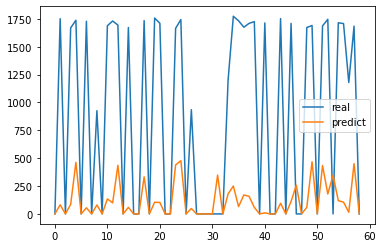

Epoch: 10; Test MAE loss on source data is: 575.640
Epoch: 10; Test MSE loss on source data is: 729638.393


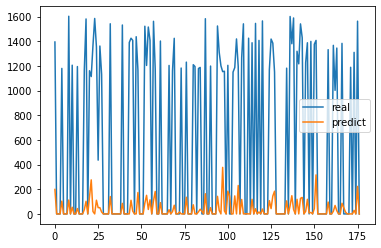

Epoch: 10; MSE loss: 13248108.000
788.0166194829563
1127324.9952468877
Epoch: 11; MSE loss: 12666886.000
767.1086268451927
1070124.1609339805
Epoch: 12; MSE loss: 12075486.000
755.8929019647802
1046522.707667107
Epoch: 13; MSE loss: 12019327.000
754.8786367750437
1045008.2288393916
Epoch: 14; MSE loss: 11341023.000
699.4519860003627
902409.1678949365
Epoch: 15; MSE loss: 11107818.000
687.396576116314
883523.0411094142
Epoch: 16; MSE loss: 10887343.000
702.7904972248831
915716.0650394228
Epoch: 17; MSE loss: 9930625.000
697.9565809648589
900883.6100901539
Epoch: 18; MSE loss: 9892652.000
658.3359880393507
812677.5675097114
Epoch: 19; MSE loss: 9539659.000
630.5989487642622
762863.5975163917
Epoch: 20; Test MAE loss on target data is: 630.599
Epoch: 20; Test MSE loss on target data is: 762863.598


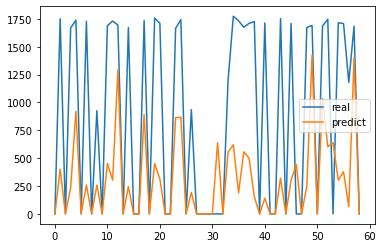

Epoch: 20; Test MAE loss on source data is: 491.683
Epoch: 20; Test MSE loss on source data is: 536709.898


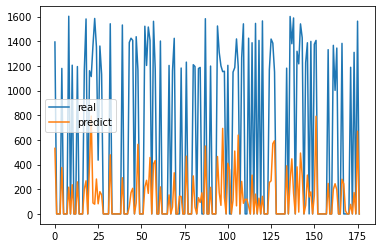

Epoch: 20; MSE loss: 10328716.000
599.9218406785005
696572.7867823576
Epoch: 21; MSE loss: 9522283.000
659.1572090515309
829430.5494360183
Epoch: 22; MSE loss: 8970390.000
566.81596663308
669075.3532679322
Epoch: 23; MSE loss: 8294490.500
579.6642272903421
718221.4172307153
Epoch: 24; MSE loss: 6835839.500
542.4351033787269
644733.4304830442
Epoch: 25; MSE loss: 7459839.000
447.1880859547416
449528.9391705431
Epoch: 26; MSE loss: 6888320.000
496.1689714765818
539071.6976948867
Epoch: 27; MSE loss: 6254549.000
497.20494633475266
558333.2041815701
Epoch: 28; MSE loss: 5927393.000
472.263394371938
486746.4554408816
Epoch: 29; MSE loss: 6798903.000
464.7850701068081
462121.44611489086
Epoch: 30; Test MAE loss on target data is: 464.785
Epoch: 30; Test MSE loss on target data is: 462121.446


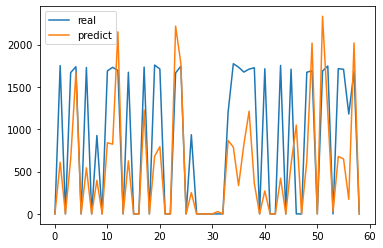

Epoch: 30; Test MAE loss on source data is: 392.006
Epoch: 30; Test MSE loss on source data is: 361847.805


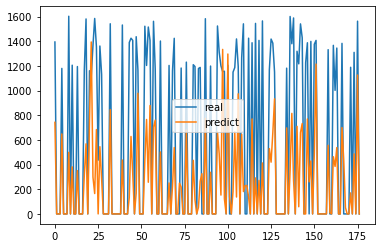

Epoch: 30; MSE loss: 5725514.000
488.49107326356705
537695.6197729969
Epoch: 31; MSE loss: 5613853.000
484.8985364235054
572994.1679544061
Epoch: 32; MSE loss: 5114857.000
406.73648812676555
356042.21736611344
Epoch: 33; MSE loss: 4521162.500
477.31333397471974
470225.70813970955
Epoch: 34; MSE loss: 4674760.000
370.59748653907565
332948.04904035473
Epoch: 35; MSE loss: 4471976.000
428.245047531559
387675.0306828635
Epoch: 36; MSE loss: 3995176.750
451.518973312809
434432.28371495806
Epoch: 37; MSE loss: 4628886.000
456.7269014692576
472530.96033067716
Epoch: 38; MSE loss: 4246160.500
433.78079421910866
438777.3789599352
Epoch: 39; MSE loss: 4174389.250
427.42327303266796
392245.1294206689
Epoch: 40; Test MAE loss on target data is: 427.423
Epoch: 40; Test MSE loss on target data is: 392245.129


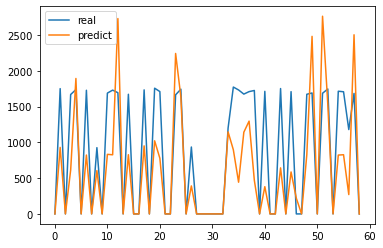

Epoch: 40; Test MAE loss on source data is: 333.471
Epoch: 40; Test MSE loss on source data is: 270073.015


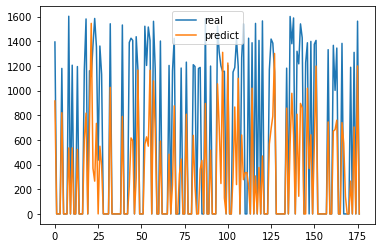

Epoch: 40; MSE loss: 4050085.750
396.5698337016133
337208.96090937377
Epoch: 41; MSE loss: 4079819.250
403.82590644103664
354239.5028265344
Epoch: 42; MSE loss: 3844576.500
463.59642970629335
525523.1623368835
Epoch: 43; MSE loss: 4026433.250
409.1391047246039
375636.257104754
Epoch: 44; MSE loss: 3790936.250
383.32069336627166
350921.5983849807
Epoch: 45; MSE loss: 3194037.000
432.08132279390674
436492.9459427555
Epoch: 46; MSE loss: 3621325.250
422.2746588927878
426214.4966068664
Epoch: 47; MSE loss: 3700650.250
366.22101864572306
396255.5706380281
Epoch: 48; MSE loss: 3358575.000
424.5328984664659
556594.286650581
Epoch: 49; MSE loss: 4100891.250
422.7204529498257
467442.7285177794
Epoch: 50; Test MAE loss on target data is: 422.720
Epoch: 50; Test MSE loss on target data is: 467442.729


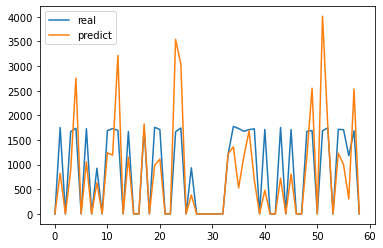

Epoch: 50; Test MAE loss on source data is: 288.558
Epoch: 50; Test MSE loss on source data is: 217895.295


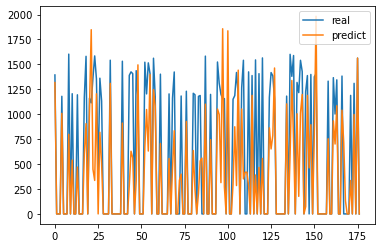

Epoch: 50; MSE loss: 4045231.000
374.8479052182645
334170.6053125639
Epoch: 51; MSE loss: 3673720.500
376.17030151280983
351744.40949043084
Epoch: 52; MSE loss: 3360354.750
379.9126516223628
424925.4950762749
Epoch: 53; MSE loss: 3658190.500
404.2300794353593
364445.0886953255
Epoch: 54; MSE loss: 3480276.250
399.2778664712852
273068.3773951189
Epoch: 55; MSE loss: 3468219.500
367.11976097667286
336701.5686028576
Epoch: 56; MSE loss: 3318014.250
427.1998370326845
412272.8533181859
Epoch: 57; MSE loss: 3278839.250
419.51522999564133
408405.9102346361
Epoch: 58; MSE loss: 3238635.000
389.75064362779176
353756.281501365
Epoch: 59; MSE loss: 3104834.500
382.6928173431569
331577.2972671591
Epoch: 60; Test MAE loss on target data is: 382.693
Epoch: 60; Test MSE loss on target data is: 331577.297


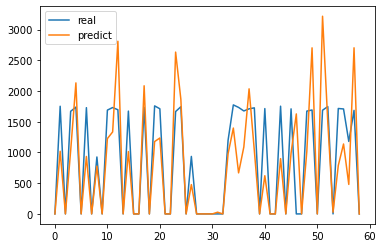

Epoch: 60; Test MAE loss on source data is: 254.795
Epoch: 60; Test MSE loss on source data is: 165548.316


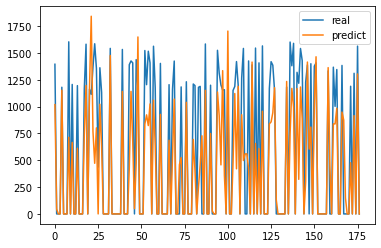

Epoch: 60; MSE loss: 3188232.000
378.6088775807182
305659.3883257059
Epoch: 61; MSE loss: 2993377.750
329.56211451622056
241015.53306237503
Epoch: 62; MSE loss: 2978926.250
302.0950189795198
244116.03803320669
Epoch: 63; MSE loss: 2882402.000
359.7411050742629
297324.9344282205
Epoch: 64; MSE loss: 2495819.750
408.62890566270903
383698.07694046985
Epoch: 65; MSE loss: 2698856.500
391.5546183613061
336573.6406662713
Epoch: 66; MSE loss: 2159069.500
318.4035342938483
246375.40529363274
Epoch: 67; MSE loss: 2480112.250
339.43195011117365
275408.38470415026
Epoch: 68; MSE loss: 2649999.250
345.30760494598564
260377.49326887302
Epoch: 69; MSE loss: 2425880.750
311.57875918803245
210445.97516595904
Epoch: 70; Test MAE loss on target data is: 311.579
Epoch: 70; Test MSE loss on target data is: 210445.975


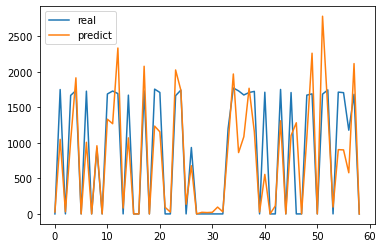

Epoch: 70; Test MAE loss on source data is: 252.898
Epoch: 70; Test MSE loss on source data is: 138393.784


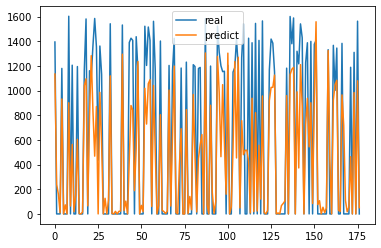

Epoch: 70; MSE loss: 2466524.000
335.16251898485393
293394.8394382389
Epoch: 71; MSE loss: 2605043.750
403.6351136622456
359332.20046561165
Epoch: 72; MSE loss: 2528690.000
373.9053017352261
290832.55390362494
Epoch: 73; MSE loss: 2320662.000
321.6981394560324
257399.40703062736
Epoch: 74; MSE loss: 2367558.250
328.4497576837486
261837.76774413962
Epoch: 75; MSE loss: 2669981.000
379.90754839794783
328237.03280189924
Epoch: 76; MSE loss: 2088938.375
354.81215386740905
286951.9989315685
Epoch: 77; MSE loss: 2140452.750
376.53270156774147
293292.1854538753
Epoch: 78; MSE loss: 1917858.375
416.08792351329396
343304.31746525125
Epoch: 79; MSE loss: 2368524.500
376.42303141362254
302801.969503613
Epoch: 80; Test MAE loss on target data is: 376.423
Epoch: 80; Test MSE loss on target data is: 302801.970


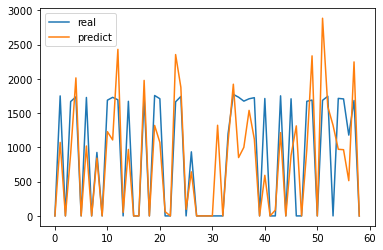

Epoch: 80; Test MAE loss on source data is: 253.799
Epoch: 80; Test MSE loss on source data is: 142493.853


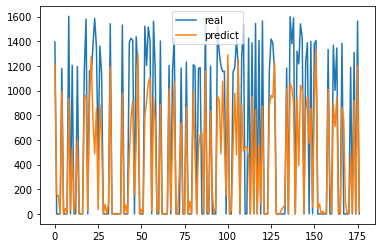

Epoch: 80; MSE loss: 2184149.500
369.3570168166511
261467.79405489497
Epoch: 81; MSE loss: 2225621.000
354.1771749588056
273595.3473554404
Epoch: 82; MSE loss: 2045391.875
375.48600013646706
316434.62595827726
Epoch: 83; MSE loss: 1978244.125
380.23886468316203
378182.4824429474
Epoch: 84; MSE loss: 1975465.125
352.7784278136862
352310.2752328689
Epoch: 85; MSE loss: 2176288.750
373.3260895384234
343691.22499141766
Epoch: 86; MSE loss: 2214715.250
377.60444850302014
300097.3541225096
Epoch: 87; MSE loss: 1931123.500
375.0063110879586
340871.79991154437
Epoch: 88; MSE loss: 1856815.250
356.6819162698789
255947.10625378118
Epoch: 89; MSE loss: 1882563.875
327.0507715947211
234848.96222791084
Epoch: 90; Test MAE loss on target data is: 327.051
Epoch: 90; Test MSE loss on target data is: 234848.962


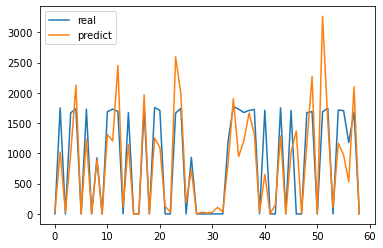

Epoch: 90; Test MAE loss on source data is: 235.451
Epoch: 90; Test MSE loss on source data is: 114371.587


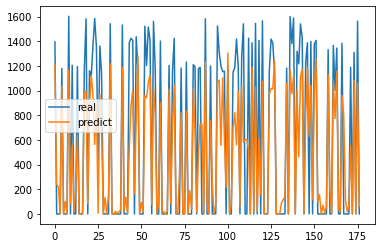

Epoch: 90; MSE loss: 2038459.500
354.5992991991636
330223.95587405295
Epoch: 91; MSE loss: 2050465.750
424.70550130854895
374023.6810858765
Epoch: 92; MSE loss: 1879152.000
341.997543895312
270842.63533561444
Epoch: 93; MSE loss: 1784016.750
335.3782026410777
272505.70871638536
Epoch: 94; MSE loss: 1945962.000
364.38737899435444
318575.22151547775
Epoch: 95; MSE loss: 1532084.250
417.0672591688943
477571.11525067675
Epoch: 96; MSE loss: 2083025.625
375.3821223415224
333966.4612611114
Epoch: 97; MSE loss: 1599663.625
343.4869729165977
269909.3451516284
Epoch: 98; MSE loss: 1707156.500
329.5545550894603
264807.72634601564
Epoch: 99; MSE loss: 2078631.625
414.2799691776772
443075.70447534684
Epoch: 100; Test MAE loss on target data is: 414.280
Epoch: 100; Test MSE loss on target data is: 443075.704


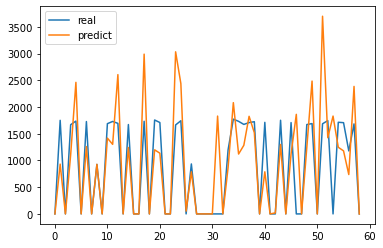

Epoch: 100; Test MAE loss on source data is: 192.363
Epoch: 100; Test MSE loss on source data is: 95812.841


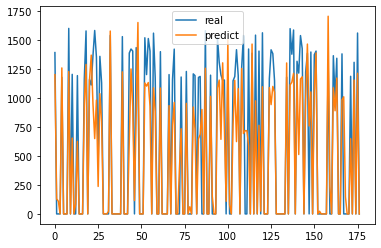

Epoch: 100; MSE loss: 1794012.375
386.165580016745
381774.58335244644
Epoch: 101; MSE loss: 1917815.000
369.4917051455396
332299.13393240346
Epoch: 102; MSE loss: 1793429.500
337.1464012827577
275973.759619776
Epoch: 103; MSE loss: 1891305.125
356.07999851205255
317343.8749333934
Epoch: 104; MSE loss: 1907141.500
375.988811039992
295247.30619270715
Epoch: 105; MSE loss: 1852791.625
354.80734854498826
262786.8938352176
Epoch: 106; MSE loss: 1821058.750
304.65143945122844
213321.34097080157
Epoch: 107; MSE loss: 1874165.625
307.3610719368283
275758.5859031443
Epoch: 108; MSE loss: 2018207.125
373.80248277739616
356558.1179720897
Epoch: 109; MSE loss: 1789015.500
410.891071944587
471371.93760236894
Epoch: 110; Test MAE loss on target data is: 410.891
Epoch: 110; Test MSE loss on target data is: 471371.938


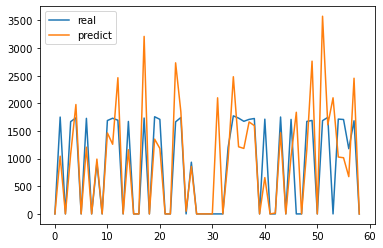

Epoch: 110; Test MAE loss on source data is: 190.766
Epoch: 110; Test MSE loss on source data is: 94459.877


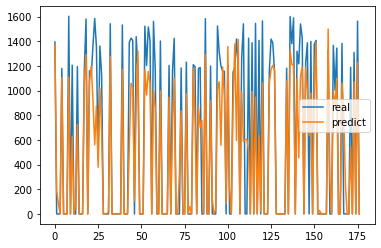

Epoch: 110; MSE loss: 1753503.250
397.74457276338916
456094.03049276856
Epoch: 111; MSE loss: 1548936.125
373.8762282355358
402050.19204461796
Epoch: 112; MSE loss: 1841020.625
331.0365885341235
287475.5415107391
Epoch: 113; MSE loss: 1699994.875
344.81363137563073
280762.7317331466
Epoch: 114; MSE loss: 1597176.250
389.08040560706195
436463.2568323547
Epoch: 115; MSE loss: 1604519.750
415.0765699397373
463549.93965170364
Epoch: 116; MSE loss: 1764941.375
354.92573706847804
334935.9757123596
Epoch: 117; MSE loss: 1698825.625
338.75995252361406
291606.95420222374
Epoch: 118; MSE loss: 1702974.875
369.7515244228018
310828.11689668155
Epoch: 119; MSE loss: 1574854.875
360.55270293068753
304052.10833584075
Epoch: 120; Test MAE loss on target data is: 360.553
Epoch: 120; Test MSE loss on target data is: 304052.108


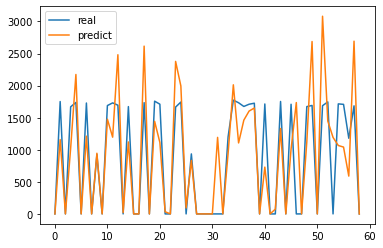

Epoch: 120; Test MAE loss on source data is: 183.685
Epoch: 120; Test MSE loss on source data is: 85492.622


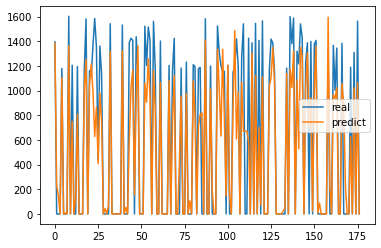

Epoch: 120; MSE loss: 1559791.500
368.60678153388244
319336.26244793914
Epoch: 121; MSE loss: 1560169.750
382.3836976821813
336393.3856740679
Epoch: 122; MSE loss: 1545003.500
414.20305016081215
529069.5081925252
Epoch: 123; MSE loss: 1587871.625
390.8565349686617
405273.74875980685
Epoch: 124; MSE loss: 1573162.375
381.43604006470935
383245.9340988993
Epoch: 125; MSE loss: 1507353.250
343.23025601058356
256307.174876447
Epoch: 126; MSE loss: 1831975.625
347.47998322740114
274655.11675758264
Epoch: 127; MSE loss: 1361835.250
349.35533833369027
303269.6839538276
Epoch: 128; MSE loss: 1759508.000
356.17786389151536
322433.02305621945
Epoch: 129; MSE loss: 1488767.000
371.561668455264
318834.2383724845
Epoch: 130; Test MAE loss on target data is: 371.562
Epoch: 130; Test MSE loss on target data is: 318834.238


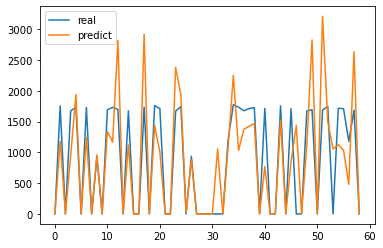

Epoch: 130; Test MAE loss on source data is: 181.603
Epoch: 130; Test MSE loss on source data is: 88272.525


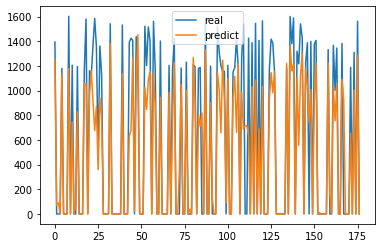

Epoch: 130; MSE loss: 1541923.500
404.60020095480365
454504.7331815421
Epoch: 131; MSE loss: 1281458.875
381.25697022238694
380817.8192516555
Epoch: 132; MSE loss: 1200326.375
393.44226537585934
406210.86690303223
Epoch: 133; MSE loss: 1302409.250
340.8594098279705
273845.05108521075
Epoch: 134; MSE loss: 1278794.375
341.85799735548807
326163.0240027548
Epoch: 135; MSE loss: 1244741.500
345.36287932746154
327477.9815079957
Epoch: 136; MSE loss: 1287686.125
355.38871071163544
304162.83043208293
Epoch: 137; MSE loss: 1479428.750
347.47280745856506
290713.16648274416
Epoch: 138; MSE loss: 1342562.750
369.86082427245753
475568.17395004653
Epoch: 139; MSE loss: 1347628.250
363.3911340142374
336303.50115296943
Epoch: 140; Test MAE loss on target data is: 363.391
Epoch: 140; Test MSE loss on target data is: 336303.501


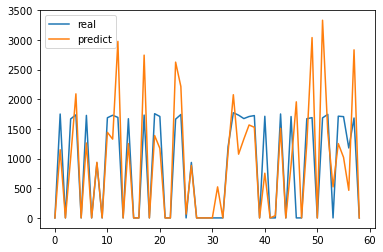

Epoch: 140; Test MAE loss on source data is: 167.863
Epoch: 140; Test MSE loss on source data is: 78951.650


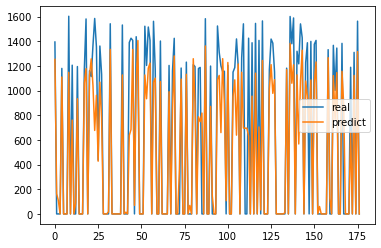

Epoch: 140; MSE loss: 1420513.500
378.0155552794031
357638.331648525
Epoch: 141; MSE loss: 1340195.625
357.65601358036537
323359.01123833103
Epoch: 142; MSE loss: 1431741.000
330.72024106171176
271297.5903703819
Epoch: 143; MSE loss: 1209807.500
344.0252738025903
277574.73952759657
Epoch: 144; MSE loss: 1355325.625
340.8852233671199
318810.7976653308
Epoch: 145; MSE loss: 1507054.250
365.6522604516671
322463.6577931399
Epoch: 146; MSE loss: 1275587.000
342.3145546131889
279129.48340609815
Epoch: 147; MSE loss: 1594858.250
308.5006635418046
231771.45122241485
Epoch: 148; MSE loss: 1330028.625
346.01946918034963
351885.119901841
Epoch: 149; MSE loss: 1542716.375
371.86230330817443
305592.1053701833
Epoch: 150; Test MAE loss on target data is: 371.862
Epoch: 150; Test MSE loss on target data is: 305592.105


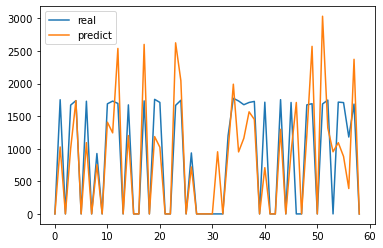

Epoch: 150; Test MAE loss on source data is: 196.202
Epoch: 150; Test MSE loss on source data is: 96748.045


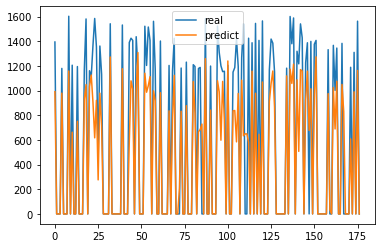

Epoch: 150; MSE loss: 1297429.375
352.94703972811084
279514.3097958876
Epoch: 151; MSE loss: 1557840.250
375.6765827351371
353792.1574477718
Epoch: 152; MSE loss: 1106979.250
384.5850366249596
387795.019061713
Epoch: 153; MSE loss: 1331006.625
369.69156227542857
330391.90734594857
Epoch: 154; MSE loss: 1203770.000
349.5061719646562
273449.40548781364
Epoch: 155; MSE loss: 1161673.750
371.6569251475361
377579.9259229531
Epoch: 156; MSE loss: 1420739.125
357.54496394442975
362691.4787929968
Epoch: 157; MSE loss: 1338927.750
329.58983202573273
283355.0095235838
Epoch: 158; MSE loss: 1288480.500
311.0964614523333
225027.6157480288
Epoch: 159; MSE loss: 1280286.750
296.68294304777675
254789.52770763534
Epoch: 160; Test MAE loss on target data is: 296.683
Epoch: 160; Test MSE loss on target data is: 254789.528


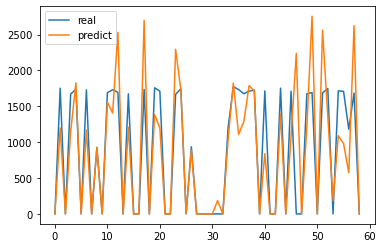

Epoch: 160; Test MAE loss on source data is: 150.471
Epoch: 160; Test MSE loss on source data is: 66467.027


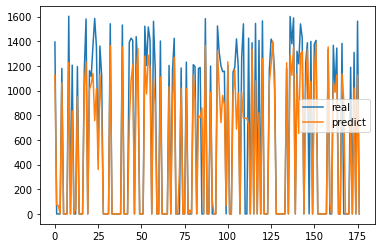

Epoch: 160; MSE loss: 1393097.625
316.5130375145519
286051.40132688556
Epoch: 161; MSE loss: 1403835.250
388.3291354570012
431920.8168853659
Epoch: 162; MSE loss: 1051762.750
362.062001546224
297852.08734226524
Epoch: 163; MSE loss: 1153316.875
356.2273879401428
338941.42971351463
Epoch: 164; MSE loss: 1254698.000
367.92225534902457
301894.2870642701
Epoch: 165; MSE loss: 1347860.500
347.3195705198299
292171.2606899705
Epoch: 166; MSE loss: 1160283.500
352.976189220019
309664.05433491385
Epoch: 167; MSE loss: 1093014.000
315.4305400848389
322960.203000523
Epoch: 168; MSE loss: 1187036.500
339.81986215020305
311847.60339038837
Epoch: 169; MSE loss: 1207539.000
347.15300392969857
306268.35404086614
Epoch: 170; Test MAE loss on target data is: 347.153
Epoch: 170; Test MSE loss on target data is: 306268.354


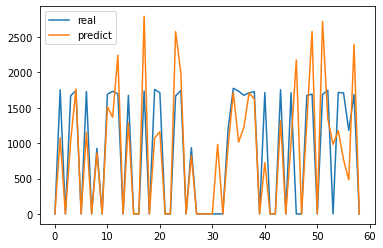

Epoch: 170; Test MAE loss on source data is: 173.309
Epoch: 170; Test MSE loss on source data is: 79670.493


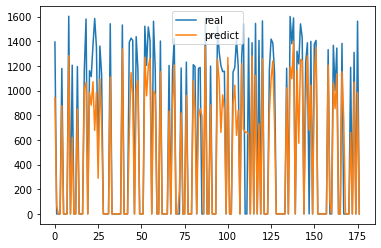

Epoch: 170; MSE loss: 1198946.500
356.42356760488394
325453.73188440484
Epoch: 171; MSE loss: 1111133.625
358.5345910713498
353473.61639306817
Epoch: 172; MSE loss: 1177268.500
356.9805676896694
370196.5774931059
Epoch: 173; MSE loss: 1174898.875
339.0695424483995
323245.0581132291
Epoch: 174; MSE loss: 1049317.250
350.0390988797118
304816.7352613496
Epoch: 175; MSE loss: 1202695.500
320.8342590816951
299218.42728419235
Epoch: 176; MSE loss: 1134994.125
336.8453849156698
319558.83392677555
Epoch: 177; MSE loss: 1187784.625
339.9641317863249
298136.12358232884
Epoch: 178; MSE loss: 1058647.375
343.7171101758709
338498.812065686
Epoch: 179; MSE loss: 1231486.000
309.29228544504633
256532.0006834939
Epoch: 180; Test MAE loss on target data is: 309.292
Epoch: 180; Test MSE loss on target data is: 256532.001


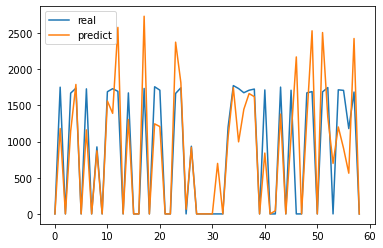

Epoch: 180; Test MAE loss on source data is: 144.137
Epoch: 180; Test MSE loss on source data is: 59217.396


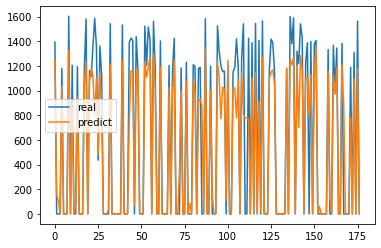

Epoch: 180; MSE loss: 1088386.125
293.1147957279184
220777.54130429725
Epoch: 181; MSE loss: 1314974.750
311.97753768317443
213712.5027932268
Epoch: 182; MSE loss: 1019065.375
347.04367189353474
338698.7124742636
Epoch: 183; MSE loss: 1064869.625
335.9260799386407
283061.2397853999
Epoch: 184; MSE loss: 1159922.375
335.07875828285006
328725.9502431821
Epoch: 185; MSE loss: 1076234.500
331.4875164139742
284950.10004319134
Epoch: 186; MSE loss: 1104829.875
331.0988222973495
326230.37737394654
Epoch: 187; MSE loss: 1107336.250
339.26634052513685
300617.4781685078
Epoch: 188; MSE loss: 1043398.000
301.3062088960982
260929.9319632058
Epoch: 189; MSE loss: 971775.625
304.1438822773217
224020.37527836981
Epoch: 190; Test MAE loss on target data is: 304.144
Epoch: 190; Test MSE loss on target data is: 224020.375


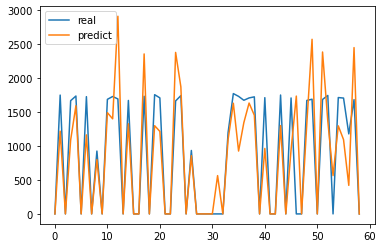

Epoch: 190; Test MAE loss on source data is: 153.701
Epoch: 190; Test MSE loss on source data is: 67692.107


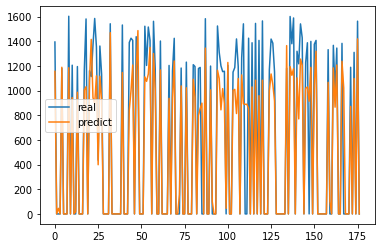

Epoch: 190; MSE loss: 1219125.625
329.4702659973317
307559.09477416554
Epoch: 191; MSE loss: 1088865.625
368.69828011895305
374421.39020362584
Epoch: 192; MSE loss: 1091048.375
330.14378658661064
285890.55857861537
Epoch: 193; MSE loss: 966866.062
302.29113631598693
219181.27947796608
Epoch: 194; MSE loss: 1009381.562
307.24707257006804
261200.39581430925
Epoch: 195; MSE loss: 1133081.750
347.62836727853556
400823.9891501317
Epoch: 196; MSE loss: 1196709.125
306.10396968173444
217478.54234762842
Epoch: 197; MSE loss: 929991.688
303.4732275480605
223318.3163597177
Epoch: 198; MSE loss: 1022714.375
302.5645343327927
254482.5610561007
Epoch: 199; MSE loss: 1024982.375
301.2096530246196
235828.87678066103
Epoch: 200; Test MAE loss on target data is: 301.210
Epoch: 200; Test MSE loss on target data is: 235828.877


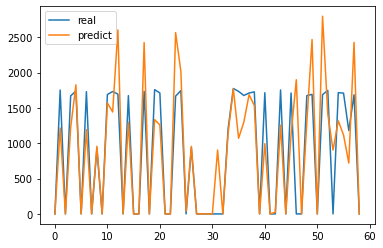

Epoch: 200; Test MAE loss on source data is: 132.891
Epoch: 200; Test MSE loss on source data is: 57203.263


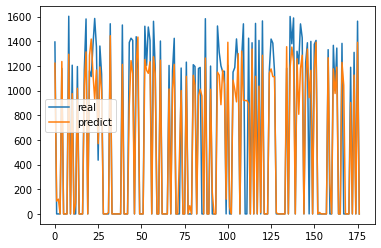

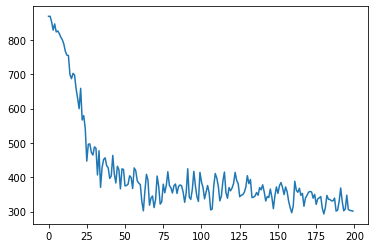

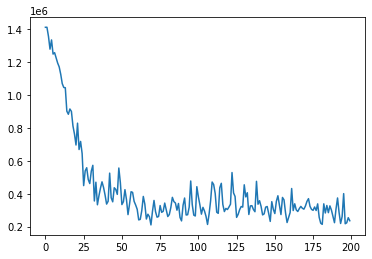

------------Domain Adaptation------------
Epoch: 0; MSE loss: 168131.521
Epoch: 0; disc loss: 277240.035
Epoch: 0; ceod loss: 34.803
294.92822438040696
227302.2681684094
Parameter containing:
tensor([0.3334, 0.3333, 0.3333], device='cuda:0', requires_grad=True)
Epoch: 1; MSE loss: 249353.703
Epoch: 1; disc loss: 309162.594
Epoch: 1; ceod loss: 35.304
325.29602878376596
302147.69484635355
Parameter containing:
tensor([0.3333, 0.3333, 0.3334], device='cuda:0', requires_grad=True)
Epoch: 2; MSE loss: 147697.965
Epoch: 2; disc loss: 319047.648
Epoch: 2; ceod loss: 39.256
320.1066435797741
287709.7133373349
Parameter containing:
tensor([0.3334, 0.3332, 0.3335], device='cuda:0', requires_grad=True)
Epoch: 3; MSE loss: 168721.070
Epoch: 3; disc loss: 286799.887
Epoch: 3; ceod loss: 39.380
316.890358790166
278636.8824879046
Parameter containing:
tensor([0.3334, 0.3331, 0.3335], device='cuda:0', requires_grad=True)
Epoch: 4; MSE loss: 153429.547
Epoch: 4; disc loss: 280835.750
Epoch: 4; ceod lo

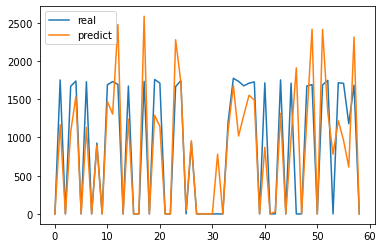

Epoch: 9; Test MAE loss on source data is: 149.358


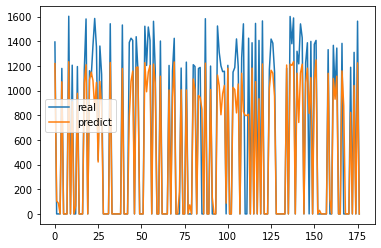

--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------


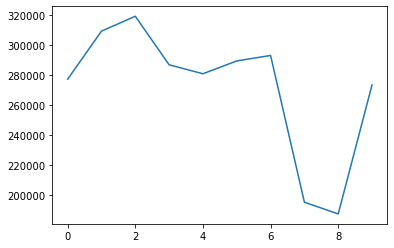

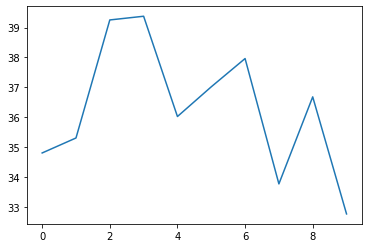

-------------------------- total running losses in 10 epoches as follows---------------------------------


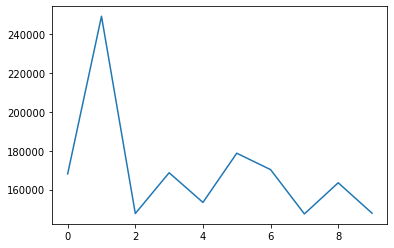

Epoch: 10; MSE loss: 179018.922
Epoch: 10; disc loss: 253127.074
Epoch: 10; ceod loss: 35.300
326.4336978890802
307528.29395796085
Parameter containing:
tensor([0.3335, 0.3325, 0.3340], device='cuda:0', requires_grad=True)
Epoch: 11; MSE loss: 151831.910
Epoch: 11; disc loss: 229973.875
Epoch: 11; ceod loss: 34.676
317.75448625640007
248435.29678501756
Parameter containing:
tensor([0.3335, 0.3325, 0.3340], device='cuda:0', requires_grad=True)


KeyboardInterrupt: 

In [ ]:
import importlib
# import models.hdisc_msda 
# importlib.reload(models.hdisc_msda)
# from models.hdisc_msda import Disc_MSDANet
import matplotlib.pyplot as plt

#Number of experiments to launch
num_data_sets=len(fileList)
num_domains=num_data_sets-1
nb_experiments = 1

#-np.inf
params= {'input_dim': 19, 'output_dim': 1, 'n_sources': num_data_sets-1, 'loss': torch.nn.MSELoss(),
         'weighted_loss': weighted_mse, 'min_pred': 0, 'max_pred': np.inf}

#Number of epochs
epochs_pretrain, epochs_adapt =200,20

for exp in range(nb_experiments):
    print('\n ----------------------------- %i / %i -----------------------------'%(exp+1, nb_experiments))
    mse_list, mae_list =  {}, {}
    alphas = {}
    for i in range(num_data_sets):
        print('\n---------------------------------------------- domain num %i is running----------------------------------'%(i))
        # Build source instances.
        source_insts = []
        source_labels = []
        for j in range(num_data_sets):
            if j != i:
                source_insts.append(data_insts[j])
                source_labels.append(data_labels[j])
        # Build target instances.
        target_idx = i
        target_insts = data_insts[i]
        target_labels = data_labels[i]
        target_insts0, X_t, target_labels0, y_t =train_test_split(target_insts, target_labels, test_size=0.2,random_state=100)
        X_t= X_t.reshape(X_t.shape[0],1, X_t.shape[1])
        X_t = torch.tensor(X_t, requires_grad=False).type(torch.FloatTensor).to(device)
        
        X=np.concatenate(source_insts, axis=0)
        Y=np.concatenate(source_labels, axis=0)
        
        x_train_all, x_test, y_train_all, y_test =train_test_split(X, Y, test_size=0.2,random_state=100)
        x_test= x_test.reshape(x_test.shape[0],1, x_test.shape[1])
        x_test = torch.tensor(x_test, requires_grad=False).type(torch.FloatTensor).to(device)
        
        ############################# Build and define model ####################################
        params['feature_extractor'] = get_feature_extractor()
        params['h_pred'] = get_predictor(output_dim=1)
        params['h_disc'] = get_discriminator(num_domains, output_dim=1)
        model = Disc_MSDANet(params).to(device)

#         #Pre-training
        print('------------Pre-training------------')
        lr = 0.001
        lr1=0.0001
        batch_size =16
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        mae_loss,mse_loss=[],[]
        for epoch in range(epochs_pretrain):
            running_loss=0.0
            model.train()
#             input_sizes = [data.shape[0] for data in source_insts]
#             max_input_size = max(input_sizes)
#             K=int(max_input_size/batch_size)
#             print('K value is:', K)

            loader = multi_data_loader(source_insts, source_labels, batch_size)
    
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_t = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)
                loss_pred = model.train_prediction(x_bs, x_t, y_bs, clip=1, pred_only=False)
#                 print("predictor is:", model.h_pred.weight.data) 
                running_loss+=loss_pred
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            model.eval()
            prediction=model.predict(X_t).cpu().detach().numpy()
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            if (epoch+1)%10==0:
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
#                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                reg_mse = get_mse(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on target data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()
                
                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                reg_mse = get_mse(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch+1, reg_loss))
                print('Epoch: %i; Test MSE loss on source data is: %.3f'%(epoch+1, reg_mse))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
        
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()        
     
                
        print('------------Domain Adaptation------------')
        disc_losslist, ceod_losslist, loss_list=[],[],[]
        mae_loss,mse_loss=[],[]
        lr = 0.0001
        lr1=0.0001
        batch_size =64
        b1=0.99
        b2=0.999
#         opt_feat=torch.optim.SGD([{'params': model.feature_extractor.parameters()}], lr=0.0001, momentum=0.8)
#         opt_pred=torch.optim.SGD([{'params': model.h_pred.parameters()}], lr=0.0001, momentum=0.8)
        opt_feat = torch.optim.Adam([{'params': model.feature_extractor.parameters()}],lr=lr,betas=(b1, b2))
        opt_pred = torch.optim.Adam([{'params': model.h_pred.parameters()}],lr=lr,betas=(b1, b2))
        opt_disc = torch.optim.Adam([{'params': model.h_disc.parameters()}],lr=lr,betas=(b1, b2))
        opt_alpha = torch.optim.Adam([{'params': model.alpha}],lr=lr,betas=(b1, b2))
        opt_mu = torch.optim.Adam([{'params': model.mu}],lr=lr1,betas=(b1, b2))
        opt_beta = torch.optim.Adam([{'params': model.beta}],lr=lr1,betas=(b1, b2))
        model.optimizers(opt_feat, opt_pred, opt_disc, opt_alpha,opt_mu,opt_beta)
        
        for epoch in range(epochs_adapt):
            running_loss = 0.0
            discloss = 0.0
            ceodloss = 0.0
            model.train()
            loader = multi_data_loader(source_insts, source_labels, batch_size)
            for x_bs, y_bs in loader:
                for j in range(num_domains):
                    x_bs[j]= x_bs[j].reshape(x_bs[j].shape[0],1,x_bs[j].shape[1])
                    x_bs[j] = torch.tensor(x_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)
                    y_bs[j] = torch.tensor(y_bs[j], requires_grad=False).type(torch.FloatTensor).to(device)                 
                ridx = np.random.choice(target_insts.shape[0], batch_size)
                tinputs = target_insts[ridx, :]
                tinputs= tinputs.reshape(tinputs.shape[0],1,tinputs.shape[1])
                x_bt = torch.tensor(tinputs, requires_grad=False).type(torch.FloatTensor).to(device)

                #Train h to minimize source loss

            #stage 1
                for a in range(5):
                    disc_loss1 = model.train_disc(x_bs, x_bt, y_bs, clip=1)
                for b in range(1):
                    loss,source_loss,ceod_loss,disc_loss=model.train_all_feat(x_bs, x_bt, y_bs, clip=1)
#                     print("extractor is:", model.feature_extractor[5][0].weight) 
#                     print("discriminator is ", model.h_disc[0].weight.data)
#                     print("Hybrid loss is ", loss)
            #stage 2  
               # loss,source_loss,ceod_loss,disc_loss=model.train_all(x_bs, x_bt, y_bs, clip=1)
            #maximize discrepancy by opt_disc
#                 print("###############finish test########################")
                for c in range(1):
                    loss,source_loss,ceod_loss=model.train_all_pred(x_bs, x_bt, y_bs, clip=1)
                for d in range(3):
                    disc_loss=model.train_all_alpha(x_bs, x_bt, y_bs, clip=1)
#                     print("predictor is ", model.h_pred.weight.data)
                running_loss += loss.item()
                discloss += disc_loss.item()
                ceodloss+=ceod_loss.item()
            loss_list.append(running_loss)
            disc_losslist.append(discloss)
            ceod_losslist.append(ceodloss)
            print('Epoch: %i; MSE loss: %.3f'%(epoch, running_loss))
            print('Epoch: %i; disc loss: %.3f'%(epoch, discloss))
            print('Epoch: %i; ceod loss: %.3f'%(epoch, ceodloss))
            model.eval()
#             print(X_t)
            prediction=model.predict(X_t).cpu().detach().numpy()
#             print(prediction)
            stopT=get_mae(y_t, prediction)
            mae_loss.append(stopT)
            print(stopT)
            cur_loss=get_mse(y_t, prediction)
            mse_loss.append(cur_loss)
            print(cur_loss)
            print(model.alpha)
            if (epoch+1)%10==0:
                print('--------------------------results as follows ---------------------------------')
                model.eval()
                prediction=model.predict(X_t).cpu().detach().numpy()
        #                 source_loss, disc = model.compute_loss(x_bs, X_t, y_s)
                reg_loss = get_mae(y_t, prediction)
                print('Epoch: %i; Test MAE loss on target data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(X_t)), y_t, label='real')
                plt.plot(range(len(X_t)),prediction, label='predict')
                plt.legend()               
                plt.show()

                prediction=model.predict(x_test).cpu().detach().numpy()
                reg_loss = get_mae(y_test, prediction)
                print('Epoch: %i; Test MAE loss on source data is: %.3f'%(epoch, reg_loss))
                plt.plot(range(len(x_test)), y_test, label='real')
                plt.plot(range(len(x_test)),prediction, label='predict')
                plt.legend()               
                plt.show()
            if (epoch+1)%10==0:
                print('--------------------------regression discrepency and conditional MMD in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),disc_losslist,label='discripency')
                plt.show()
                plt.plot(range(len(loss_list)),ceod_losslist,label='CEOD loss')
                plt.show()
                print('-------------------------- total running losses in 10 epoches as follows---------------------------------')
                plt.plot(range(len(loss_list)),loss_list,label='Total_loss')
                plt.show()
#             if disc_loss<=100:
#                 break;
                
            # if stopT<=28:
            #     break;
        plt.plot(range(len(mae_loss)),mae_loss,label='loss converage')
        plt.show()
        plt.plot(range(len(mse_loss)),mse_loss,label='loss converage')
        plt.show()
        model.eval()
        prediction=model.predict(X_t).cpu().detach().numpy()
        stopT=get_mae(y_t, prediction)
        print(stopT)
        print(get_sae(y_t, prediction))
        print(get_nde(y_t, prediction))
        print(model.alpha)